# 翼状胬肉区域分割模型

这是项目的第二个任务：实现对眼部裂隙灯检查图片中翼状胬肉区域的精准分割。我们将使用U-Net模型解决这一问题。

# 初始化

In [1]:
# ================== 数据集路径 =================
# 数据路径
image_dir =          r"f:/train"
# colab路径
colab_zip_path = "/content/drive/My Drive/train.zip"
colab_extract_path = "/content/trains/"
# Kaggle路径
kaggle_extract_path = "/kaggle/input/pterygium/train/"
kaggle_temp_path = "/kaggle/working/"

# =================== 验证集路径 =================
# 验证集路径
val_image_dir =      r"f:/val_img"
# colab路径
# Kaggle路径
kaggle_val_path = "/kaggle/input/pterygium/val_img/"

# ================== 掩码输出路径 ================
output_mask_dir = r"f:/mask" # 后处理后的二值掩码 (RGB 128,0,0)
output_mask_model_output_dir = r"f:/mask_original" # # 模型原始输出阈值化后的二值掩码 (RGB 128,0,0)
output_mask_prob_dir = r"f:/mask_probability" # 模型原始输出概率图 (RGB 0-255)
# colab路径
output_maskfiles_colab = "/content/mask"
output_maskmodeloutputfiles_colab = "/content/mask_original"
output_maskprobfiles_colab = "/content/mask_probability"
# Kaggle路径
output_maskfiles_kaggle = "/kaggle/working/mask"
output_maskmodeloutputfile_kaggle = "/kaggle/working/mask_original"
output_maskprobfiles_kaggle = "/kaggle/working/mask_probability"

# ================== 训练参数 ==================
DEBUG_MODE = True # 设置为 True 以启用调试模式加速训练 (图像缩放 1/4)
patch_size = 256
patch_stride = patch_size // 2 # 定义训练时的步长（产生50%重叠）
predict_stride = patch_size // 2 # 定义预测时的步长（产生50%重叠）
target_input_size = (patch_size, patch_size)
train_model_select = 'unet' # 'unet', 'deeplabv3', 'unet_attention'
MIN_FOREGROUND_RATIO = 0 # 离线patching，保留的Mask Patch中前景像素(128)最小比例，设为0则不过滤
HEALTHY_PTERYGIUM_PATCH_RATIO = 0.3 # 健康和翼状胬肉patch比例，设为0则不平衡采样
tpu_batch_size = 16
# 512分辨率下，unet为36，deeplabv3为20
cuda_batch_size = 19 if train_model_select == 'deeplabv3' else 36
windows_batch_size = 3
num_epochs = 30
log_interval = 5

if patch_size == 256: cuda_batch_size *= 4

In [2]:
def setup_matplotlib_agg_backend_if_no_gui():    
    # 检查是否在非 Windows 系统上且没有设置 DISPLAY 环境变量
    # 这是判断是否缺少 GUI 的常见启发式方法
    try:
        shell = get_ipython().__class__.__name__ # type: ignore
        # 'ZMQInteractiveShell' 表示 Jupyter Notebook 或 QtConsole
        # 'TerminalInteractiveShell' 表示 IPython 命令行
        if 'Shell' in shell:
            # Jupyter/IPython 环境
            print('检测到jupyter环境')
            get_ipython().run_line_magic('matplotlib', 'inline') # type: ignore
            return True
        else:
            # 其他情况（理论上不应发生在此 try 块）
            raise NameError
    except NameError:
        print("检测到可能没有 GUI 环境，将 Matplotlib 后端设置为 'Agg'。")
        matplotlib.use('Agg') # type: ignore
        return False      # 标准 Python 解释器 (get_ipython 未定义)
    except Exception as e:
        print(f"警告：尝试将 Matplotlib 后端设置为 'Agg' 时出错: {e}")
        return False

In [3]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.ndimage import binary_fill_holes
import shap
import collections
import subprocess
import torch.backends.cudnn as cudnn
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torchvision.models import ResNet34_Weights 
from torchvision import transforms, models
from torchvision.transforms import functional as F
from skimage.morphology import binary_opening, binary_closing, disk, square
try:
    subprocess.run(['pip', 'install','--upgrade','albumentations'], check=True)
except:
    print("pip install albumentations 失败")
    pass
import albumentations as A # type: ignore
from albumentations.pytorch import ToTensorV2 # type: ignore
import cv2
import torch.nn.functional as Fnn
from copy import deepcopy
import pandas as pd
import shutil
import numpy as np
from PIL import Image
import zipfile
import sys
import platform
import random
import time
import glob
from tqdm.autonotebook import tqdm # 好看！
import matplotlib
setup_matplotlib_agg_backend_if_no_gui()
import matplotlib.pyplot as plt
from skimage.measure import label
import matplotlib.font_manager

try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    _xla_available = True
    print("torch_xla 导入成功。")
except ImportError:
    _xla_available = False
    print("torch_xla 未安装或导入失败。将使用 CUDA 或 CPU。")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.23
    Uninstalling albucore-0.0.23:
      Successfully uninstalled albucore-0.0.23
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.5
    Uninstalling albumentations-2.0.5:
      Successfully uninstalled albumentations-2.0.5
检测到jupyter环境
torch_xla 未安装或导入失败。将使用 CUDA 或 CPU。


In [4]:
if platform.system() == "Windows":
    num_workers = 0
    print(f"检测到 Windows 系统，将 DataLoader 的 num_workers 设置为 {num_workers}。")
else:
    # 在非 Windows 系统（如 Linux/Colab）上
    num_workers = 4
    print(f"检测到非 Windows 系统 ({platform.system()})，将 DataLoader 的 num_workers 设置为 {num_workers}。")
    # 设置中文字体
    if not os.path.exists('simhei.ttf'):
        try:
            subprocess.run(['wget','-q','-O', 'simhei.ttf', "https://cdn.jsdelivr.net/gh/Haixing-Hu/latex-chinese-fonts/chinese/%E9%BB%91%E4%BD%93/SimHei.ttf"], check=True)
        except subprocess.CalledProcessError as e:
            print(f"下载字体失败: {e}")
    matplotlib.font_manager.fontManager.addfont('simhei.ttf')
    matplotlib.rc('font', family='SimHei')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
if _xla_available:
    num_workers = 0

# 配置GPU/TPU/CPU
if _xla_available:
    # 获取 XLA 设备 (TPU)
    # xm.xla_device() 会自动获取当前进程可用的 TPU核心
    device = xm.xla_device()
    print(f"检测到 TPU，使用的设备: {device}")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        cudnn.benchmark = True
        print("cuDNN benchmark 模式已启用")
        torch.cuda.empty_cache()
    print(f"CUDA 可用: {torch.cuda.is_available()}")
    print(f"使用的设备: {device}")

检测到非 Windows 系统 (Linux)，将 DataLoader 的 num_workers 设置为 4。
cuDNN benchmark 模式已启用
CUDA 可用: True
使用的设备: cuda


## 读取和准备数据
我们需要读取原始图像和对应的分割标签（mask）。标签中像素值为128的区域表示翼状胬肉，像素值为0的区域表示背景。

In [5]:
# ========== 多环境变量设置 ==========
if os.path.exists('.env'):
    from dotenv import load_dotenv
    load_dotenv('.env')

R2_ACCESS_KEY_ID = os.environ.get('R2_ACCESS_KEY_ID', '')
R2_SECRET_ACCESS_KEY = os.environ.get('R2_SECRET_ACCESS_KEY', '')
R2_BUCKET_NAME = os.environ.get('R2_BUCKET_NAME', '')
R2_ENDPOINT_URL = os.environ.get('R2_ENDPOINT_URL', '')

if 'google.colab' in sys.modules or os.path.exists("/kaggle/working"):
    if 'google.colab' in sys.modules:
        print('在 Google Colab 环境中运行')
        image_dir = os.path.join(colab_extract_path,"train")
        label_file = os.path.join(image_dir,"train_classification_label.xlsx")
        zip_path = colab_zip_path
        extract_path = colab_extract_path

        output_mask_dir = output_maskfiles_colab
        output_mask_model_output_dir = output_maskmodeloutputfiles_colab
        output_mask_prob_dir = output_maskprobfiles_colab
        print(f"Colab 环境：验证结果将验证压缩 {output_mask_dir} 到 {output_mask_dir}.zip")

        # Mount Google Drive
        from google.colab import drive # type: ignore
        from google.colab import userdata # type: ignore
        drive.mount('/content/drive')
        R2_ACCESS_KEY_ID = userdata.get("R2_ACCESS_KEY_ID")
        R2_SECRET_ACCESS_KEY = userdata.get("R2_SECRET_ACCESS_KEY")
        R2_BUCKET_NAME = userdata.get("R2_BUCKET_NAME")
        R2_ENDPOINT_URL = userdata.get("R2_ENDPOINT_URL")
    else:
        print('在 Kaggle 环境中运行')
        image_dir = os.path.join(kaggle_extract_path,"train")
        label_file = os.path.join(image_dir,"train_classification_label.xlsx")
        val_image_dir = os.path.join(kaggle_val_path,"val_img")
        
        output_mask_dir = output_maskfiles_kaggle
        output_mask_model_output_dir= output_maskmodeloutputfile_kaggle
        output_mask_prob_dir = output_maskprobfiles_kaggle
        print(f"Kaggle 环境：验证结果将压缩 {output_mask_dir} 到 {output_mask_dir}.zip")

        from kaggle_secrets import UserSecretsClient # type: ignore
        user_secrets = UserSecretsClient()
        R2_ACCESS_KEY_ID = user_secrets.get_secret("R2_ACCESS_KEY_ID")
        R2_SECRET_ACCESS_KEY = user_secrets.get_secret("R2_SECRET_ACCESS_KEY")
        R2_BUCKET_NAME = user_secrets.get_secret("R2_BUCKET_NAME")
        R2_ENDPOINT_URL = user_secrets.get_secret("R2_ENDPOINT_URL")

    if not os.path.exists(label_file):
        # 解压数据
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)    
else:
    print(f'不在云端环境中运行,使用本地数据路径{image_dir}')
label_file = os.path.join(image_dir,"train_classification_label.xlsx")

在 Kaggle 环境中运行
Kaggle 环境：验证结果将压缩 /kaggle/working/mask 到 /kaggle/working/mask.zip


## 离线Patching函数 (利用GPU加速)
用于将原始的大尺寸图像和对应的分割掩码离线切割成指定大小的Patches，并保存到磁盘。
该函数会尝试将大图加载到GPU进行裁剪和过滤，以加速处理过程（需要注意GPU显存）。

In [6]:
def create_offline_patches_gpu_mixed(
    input_image_dir,
    label_file_path,
    output_image_patch_dir,
    output_mask_patch_dir,
    patch_size,
    stride,
    device,
    min_foreground_ratio=0.01,
    healthy_pterygium_patch_ratio=1.2, # 健康Patch数量与病灶Patch数量的比例目标
    debug_mode=False
    ):
    """
    离线创建图像和掩码的Patches，尝试使用GPU加速，并根据标签文件筛选图像。
    包含策略性采样的健康图像 Patch (Mask 全零)。
    在调试模式下，原始大图会缩放到 1/4 大小后再进行 patching。

    Args:
        input_image_dir (str): 包含原始图像子文件夹 (如 0001, 0002...) 的目录。
        label_file_path (str): 包含图像标签的Excel文件路径。
        output_image_patch_dir (str): 保存图像Patch的目录。
        output_mask_patch_dir (str or None): 保存掩码Patch的目录。如果为 None，则不处理或保存掩码。
        patch_size (int): Patch的边长。
        stride (int): 切割Patch时的步长。
        device (torch.device): 用于计算的设备 (cuda or cpu)。
        min_foreground_ratio (float): 保留的Mask Patch中前景像素(值>0)的最小比例 (仅用于病灶图像)。设为0则不过滤。
        healthy_pterygium_patch_ratio (float): 目标健康 Patch 数量 / 病灶 Patch 数量 的比例。
        debug_mode (bool): 是否启用调试模式，缩放图像。

    Returns:
        tuple: (成功处理的大图数量, 创建的Patch对数量)
    """
    start_time = time.time()
    try:
        os.makedirs(output_image_patch_dir, exist_ok=True)
        if output_mask_patch_dir:
            os.makedirs(output_mask_patch_dir, exist_ok=True)
    except Exception as e:
        print(f"创建输出目录时出错: {e}")
        return 0, 0 # 如果目录创建失败，无法继续

    # 读取并筛选标签文件
    try:
        labels_df = pd.read_excel(label_file_path)
        # 将图像分为两组：病灶和健康
        pterygium_df = labels_df[labels_df['Pterygium'] > 0].reset_index(drop=True)
        healthy_df = labels_df[labels_df['Pterygium'] == 0].reset_index(drop=True)

        pterygium_folders = pterygium_df['Image'].astype(int).apply(lambda x: f"{x:04d}").tolist()
        healthy_folders = healthy_df['Image'].astype(int).apply(lambda x: f"{x:04d}").tolist()

        print(f"从 {os.path.basename(label_file_path)} 读取标签。")
        print(f"找到 {len(pterygium_folders)} 个翼状胬肉样本进行Patching。")
        print(f"找到 {len(healthy_folders)} 个健康样本。")

    except FileNotFoundError:
        print(f"错误: 标签文件未找到 {label_file_path}。无法进行Patching。")
        return 0, 0
    except Exception as e:
        print(f"读取或处理标签文件 {label_file_path} 时出错: {e}")
        return 0, 0

    total_processed_folders = 0
    total_created_patches = 0
    pterygium_patch_count = 0
    healthy_patch_count = 0

    # --- 阶段 1: 处理病灶图像 ---
    print("\n--- 处理病灶图像 ---")
    if DEBUG_MODE: print("\n调试模式已启用，图像缩放到 1/4 大小进行处理。")
    for folder_name in tqdm(pterygium_folders, desc="Patching 病灶图像", leave=False):
        image_path = os.path.join(input_image_dir, folder_name, f"{folder_name}.png")
        mask_path = os.path.join(input_image_dir, folder_name, f"{folder_name}_label.png")

        if not os.path.exists(image_path) or (output_mask_patch_dir and not os.path.exists(mask_path)):
            print(f"警告: 病灶图像或掩码文件未找到 {folder_name}，跳过。")
            continue

        try:
            img_pil = Image.open(image_path).convert('RGB')
            mask_pil = Image.open(mask_path).convert('RGB') # 掩码是 (128,0,0)

            # --- 调试模式下缩放 ---
            if debug_mode:
                original_w, original_h = img_pil.size
                new_w, new_h = original_w // 4, original_h // 4
                img_pil = img_pil.resize((new_w, new_h), Image.Resampling.BICUBIC if hasattr(Image, 'Resampling') else Image.BICUBIC) # Use BICUBIC for image
                mask_pil = mask_pil.resize((new_w, new_h), Image.Resampling.NEAREST if hasattr(Image, 'Resampling') else Image.NEAREST) # Use NEAREST for mask
            # --- 缩放结束 ---

            img_w, img_h = img_pil.size
            mask_w, mask_h = mask_pil.size

            if img_w != mask_w or img_h != mask_h:
                print(f"警告: 病灶图像和掩码尺寸不匹配 {folder_name}，跳过。 ({img_w}x{img_h} vs {mask_w}x{mask_h})")
                continue

            img_tensor_gpu = F.to_tensor(img_pil).to(device)
            mask_np_rgb = np.array(mask_pil)
            mask_binary = (mask_np_rgb[:, :, 0] == 128).astype(np.float32)
            mask_tensor_gpu = torch.from_numpy(mask_binary).unsqueeze(0).to(device)

            for y in range(0, img_h - patch_size + 1, stride):
                for x in range(0, img_w - patch_size + 1, stride):
                    img_patch_gpu = img_tensor_gpu[:, y:y+patch_size, x:x+patch_size]
                    mask_patch_gpu = mask_tensor_gpu[:, y:y+patch_size, x:x+patch_size]

                    # --- 应用前景过滤 (仅对病灶图像 Patch) ---
                    if min_foreground_ratio > 0:
                        foreground_ratio = torch.mean(mask_patch_gpu)
                        if foreground_ratio < min_foreground_ratio:
                            continue # 跳过前景过少的病灶 Patch

                    # --- 保存 Patch ---
                    img_patch_cpu = img_patch_gpu.cpu()
                    mask_patch_cpu = mask_patch_gpu.cpu()

                    patch_filename = f"{folder_name}_y{y}_x{x}.png"
                    img_save_path = os.path.join(output_image_patch_dir, patch_filename)
                    F.to_pil_image(img_patch_cpu).save(img_save_path)

                    if output_mask_patch_dir:
                        # 将 0/1 mask tensor 转换为 0/128 的 PIL 灰度图 (或 RGB 128,0,0)
                        mask_patch_np_uint8 = (mask_patch_cpu.squeeze().numpy() * 128).astype(np.uint8)
                        mask_rgb_array = np.stack((mask_patch_np_uint8, np.zeros_like(mask_patch_np_uint8), np.zeros_like(mask_patch_np_uint8)), axis=-1)
                        Image.fromarray(mask_rgb_array, mode='RGB').save(os.path.join(output_mask_patch_dir, patch_filename))


                    pterygium_patch_count += 1
                    total_created_patches += 1

            del img_tensor_gpu, mask_tensor_gpu
            if 'img_patch_gpu' in locals(): del img_patch_gpu
            if 'mask_patch_gpu' in locals() and mask_patch_gpu is not None: del mask_patch_gpu
            if device == torch.device("cuda"):
                torch.cuda.empty_cache()
            total_processed_folders += 1 # 成功处理一个病灶文件夹

        except Exception as e:
            print(f"\n处理病灶文件 {folder_name} 时发生未预料错误: {e}")
            if device == torch.device("cuda"):
                torch.cuda.empty_cache()


    print(f"病灶图像 Patching 完成。共创建 {pterygium_patch_count} 个病灶 Patches。")


    # --- 阶段 2: 策略性采样并处理健康图像 ---
    if output_mask_patch_dir and healthy_folders: # 只有在需要 Mask 且有健康图像时才处理
        print("\n--- 处理健康图像 ---")
        target_healthy_patch_count = int(pterygium_patch_count * healthy_pterygium_patch_ratio)
        print(f"目标健康 Patch 数量 (基于 {healthy_pterygium_patch_ratio}:1 比例): {target_healthy_patch_count}")

        # 粗略估计每张健康大图能产生的 Patch 数量 (基于原始或缩放后的尺寸)
        # 假设原始图像尺寸一致 5184x3456
        original_h, original_w = 3456, 5184
        img_h, img_w = (original_h // 4, original_w // 4) if debug_mode else (original_h, original_w)

        est_patches_per_full_image_precise = ((img_h - patch_size + stride) // stride) * ((img_w - patch_size + stride) // stride)
        if est_patches_per_full_image_precise <= 0: # 防止计算错误或尺寸太小
            est_patches_per_full_image_precise = (img_h // stride) * (img_w // stride) # 回退到粗略估计
            if est_patches_per_full_image_precise == 0: est_patches_per_full_image_precise = 1 # 至少1个

        # 估计需要多少张健康大图来达到目标 Patch 数量
        num_healthy_folders_to_sample = min(len(healthy_folders), max(1, int(target_healthy_patch_count / est_patches_per_full_image_precise)))
        print(f"估计需要采样约 {num_healthy_folders_to_sample} 张健康图像。")

        # 随机采样健康文件夹
        if num_healthy_folders_to_sample < len(healthy_folders):
            sampled_healthy_folders = random.sample(healthy_folders, num_healthy_folders_to_sample)
            print(f"已从 {len(healthy_folders)} 张中随机采样 {len(sampled_healthy_folders)} 张健康图像进行Patching。")
        else:
            sampled_healthy_folders = healthy_folders
            print(f"将对所有 {len(healthy_folders)} 张健康图像进行Patching。")


        # 遍历采样的健康图像文件夹进行 Patching
        for folder_name in tqdm(sampled_healthy_folders, desc="Patching 健康图像", leave=False):
            image_path = os.path.join(input_image_dir, folder_name, f"{folder_name}.png")

            if not os.path.exists(image_path):
                print(f"警告: 健康图像文件未找到 {image_path}，跳过文件夹 {folder_name}。")
                continue

            try:
                img_pil = Image.open(image_path).convert('RGB')

                # --- 调试模式下缩放 ---
                if debug_mode:
                    original_w, original_h = img_pil.size
                    new_w, new_h = original_w // 4, original_h // 4
                    img_pil = img_pil.resize((new_w, new_h), Image.Resampling.BICUBIC if hasattr(Image, 'Resampling') else Image.BICUBIC)
                # --- 缩放结束 ---

                img_w, img_h = img_pil.size

                # 为健康图像创建全零 Mask (与缩放或未缩放后的图像尺寸相同)
                mask_np_zero = np.zeros((img_h, img_w), dtype=np.float32) # 0/1 float32 格式
                mask_tensor_gpu = torch.from_numpy(mask_np_zero).unsqueeze(0).to(device)

                img_tensor_gpu = F.to_tensor(img_pil).to(device)

                for y in range(0, img_h - patch_size + 1, stride):
                    for x in range(0, img_w - patch_size + 1, stride):
                        img_patch_gpu = img_tensor_gpu[:, y:y+patch_size, x:x+patch_size]
                        mask_patch_gpu = mask_tensor_gpu[:, y:y+patch_size, x:x+patch_size] # 仍然是全零

                        # --- 不对健康图像的 Patch 应用前景过滤 ---

                        # --- 保存 Patch ---
                        img_patch_cpu = img_patch_gpu.cpu()
                        mask_patch_cpu = mask_patch_gpu.cpu() # 仍然是全零

                        patch_filename = f"{folder_name}_y{y}_x{x}.png"
                        img_save_path = os.path.join(output_image_patch_dir, patch_filename)
                        F.to_pil_image(img_patch_cpu).save(img_save_path)

                        if output_mask_patch_dir:
                            # 将 0/1 的全零 mask tensor 转换为 0/128 的 PIL 灰度图 (仍然是全零图像)
                            mask_patch_np_uint8 = (mask_patch_cpu.squeeze().numpy() * 128).astype(np.uint8)
                            mask_rgb_array = np.stack((mask_patch_np_uint8, np.zeros_like(mask_patch_np_uint8), np.zeros_like(mask_patch_np_uint8)), axis=-1)
                            Image.fromarray(mask_rgb_array, mode='RGB').save(os.path.join(output_mask_patch_dir, patch_filename))

                        healthy_patch_count += 1
                        total_created_patches += 1

                del img_tensor_gpu, mask_tensor_gpu
                if 'img_patch_gpu' in locals(): del img_patch_gpu
                if 'mask_patch_gpu' in locals() and mask_patch_gpu is not None: del mask_patch_gpu
                if device == torch.device("cuda"):
                    torch.cuda.empty_cache()
                total_processed_folders += 1 # 成功处理一个健康文件夹

            except Exception as e:
                print(f"\n处理健康文件 {folder_name} 时发生未预料错误: {e}")
                if device == torch.device("cuda"):
                    torch.cuda.empty_cache()

    print(f"健康图像 Patching 完成。共创建 {healthy_patch_count} 个健康 Patches。")


    end_time = time.time()
    print("-" * 30)
    print("离线Patching完成！")
    print(f"成功处理大图数量: {total_processed_folders}") # 包括病灶和采样的健康图像文件夹
    print(f"总共创建Patch数量: {total_created_patches}") # 病灶 Patch + 健康 Patch
    print(f"其中病灶 Patch 数量: {pterygium_patch_count}")
    print(f"其中健康 Patch 数量: {healthy_patch_count}")
    if pterygium_patch_count > 0:
        print(f"健康 Patch / 病灶 Patch 实际比例: {healthy_patch_count / pterygium_patch_count:.2f}")
    print(f"总耗时: {end_time - start_time:.2f} 秒")
    print("-" * 30)

    return total_processed_folders, total_created_patches

## Cloudflare R2 缓存patching

In [7]:
import boto3
import botocore
def create_r2_client():
    """尝试创建并返回一个配置好的 boto3 R2 客户端。"""
    # 确认环境变量已加载 (这些变量应在之前的单元格中设置)
    required_vars = ['R2_ENDPOINT_URL', 'R2_ACCESS_KEY_ID', 'R2_SECRET_ACCESS_KEY', 'R2_BUCKET_NAME']
    if not all(var in globals() and globals()[var] for var in required_vars):
        print("R2 配置不完整（缺少 Endpoint URL, Access Key, Secret Key 或 Bucket Name）。跳过 R2 缓存。")
        return None, False # 返回 None 和 R2 未配置标志

    global r2_configured # 声明我们要修改全局变量
    r2_configured = True # 标记 R2 已配置

    try:
        print("正在创建 R2 (boto3 S3) 客户端...")
        s3_client = boto3.client(
            service_name='s3',
            endpoint_url=R2_ENDPOINT_URL,
            aws_access_key_id=R2_ACCESS_KEY_ID,
            aws_secret_access_key=R2_SECRET_ACCESS_KEY,
            region_name='auto', # R2 通常使用 'auto'
            config=botocore.config.Config(signature_version='s3v4') # 明确签名版本
        )
        # 尝试列出 buckets (可选，作为连接测试)
        # s3_client.list_buckets()
        print("R2 客户端创建成功。")
        return s3_client, True
    except Exception as e:
        print(f"创建 R2 客户端时出错: {e}")
        r2_configured = False # 出错则标记为未配置
        return None, False

def check_r2_cache(s3_client, bucket_name, cache_key):
    """检查指定的缓存键是否存在于 R2 存储桶中。"""
    if not s3_client: return False
    try:
        s3_client.head_object(Bucket=bucket_name, Key=cache_key)
        return True
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == '404':
            return False # 文件未找到
        else:
            # 其他错误 (如权限问题)
            print(f"检查 R2 缓存时出错 (Key: {cache_key}): {e}")
            return False
    except Exception as e:
        print(f"检查 R2 缓存时发生未知错误: {e}")
        return False

def download_from_r2(s3_client, bucket_name, cache_key, local_path):
    """从 R2 下载文件到本地路径，带进度条。"""
    if not s3_client: return False
    try:
        # 获取文件大小以显示进度
        response = s3_client.head_object(Bucket=bucket_name, Key=cache_key)
        total_size = int(response.get('ContentLength', 0))

        print(f"正在从 R2 下载 {cache_key} 到 {local_path} ({total_size / (1024*1024):.2f} MB)...")
        with tqdm(total=total_size, unit='B', unit_scale=True, desc=cache_key, leave=False) as pbar:
            s3_client.download_file(
                Bucket=bucket_name,
                Key=cache_key,
                Filename=local_path,
                Callback=lambda bytes_transferred: pbar.update(bytes_transferred)
            )
        print(f"文件 {cache_key} 下载完成。")
        return True
    except botocore.exceptions.ClientError as e:
        print(f"从 R2 下载文件时出错 (Key: {cache_key}): {e}")
        # 如果文件下载失败，尝试删除本地可能不完整的文件
        if os.path.exists(local_path):
            try: os.remove(local_path)
            except: pass
        return False
    except Exception as e:
        print(f"下载 R2 文件时发生未知错误: {e}")
        if os.path.exists(local_path):
            try: os.remove(local_path)
            except: pass
        return False

def upload_to_r2(s3_client, bucket_name, local_path, cache_key):
    """将本地文件上传到 R2，带进度条。"""
    if not s3_client or not os.path.exists(local_path):
        print(f"上传 R2 失败：客户端未初始化或本地文件不存在 ({local_path})。")
        return False
    try:
        total_size = os.path.getsize(local_path)
        print(f"正在上传 {local_path} ({total_size / (1024*1024):.2f} MB) 到 R2 作为 {cache_key}...")
        with tqdm(total=total_size, unit='B', unit_scale=True, desc=cache_key, leave=False) as pbar:
            s3_client.upload_file(
                Filename=local_path,
                Bucket=bucket_name,
                Key=cache_key,
                Callback=lambda bytes_transferred: pbar.update(bytes_transferred)
            )
        print(f"文件 {cache_key} 上传完成。")
        return True
    except botocore.exceptions.ClientError as e:
        print(f"上传文件到 R2 时出错 (Key: {cache_key}): {e}")
        return False
    except Exception as e:
        print(f"上传 R2 文件时发生未知错误: {e}")
        return False

def zip_directory(folder_path, zip_path):
    """压缩指定文件夹的内容到 zip 文件。"""
    if not os.path.isdir(folder_path):
        print(f"错误：要压缩的文件夹不存在 {folder_path}")
        return False
    print(f"正在压缩目录 {folder_path} 到 {zip_path}...")
    try:
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # 获取文件夹内的所有文件和子文件夹
            file_paths = []
            for root, dirs, files in os.walk(folder_path):
                for filename in files:
                    file_paths.append(os.path.join(root, filename))

            # 使用 tqdm 显示压缩进度 (按文件数)
            with tqdm(total=len(file_paths), desc="压缩文件", unit="file", leave=False) as pbar:
                for file in file_paths:
                    # 计算文件在 zip 中的相对路径
                    arcname = os.path.relpath(file, folder_path)
                    zipf.write(file, arcname)
                    pbar.update(1)
        print("目录压缩完成。")
        return True
    except Exception as e:
        print(f"压缩目录时出错: {e}")
        # 如果压缩失败，删除可能不完整的 zip 文件
        if os.path.exists(zip_path):
            try: os.remove(zip_path)
            except: pass
        return False

def unzip_directory(zip_path, extract_to_folder):
    """解压缩 zip 文件到指定文件夹。"""
    if not os.path.exists(zip_path):
        print(f"错误：要解压的 zip 文件不存在 {zip_path}")
        return False
    print(f"正在解压缩文件 {zip_path} 到 {extract_to_folder}...")
    try:
        os.makedirs(extract_to_folder, exist_ok=True) # 确保目标文件夹存在
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # 获取 zip 文件中的成员数量以显示进度
            total_files = len(zip_ref.namelist())
            with tqdm(total=total_files, desc="解压缩文件", unit="file", leave=False) as pbar:
                # 使用 extractall 并更新进度条可能不直接，改为逐个提取
                for member in zip_ref.infolist():
                    zip_ref.extract(member, extract_to_folder)
                    pbar.update(1)
                    # 或者直接用 extractall，进度条可能不准确但更快
                    # zip_ref.extractall(extract_to_folder)
        print("文件解压缩完成。")
        return True
    except Exception as e:
        print(f"解压缩文件时出错: {e}")
        # 如果解压失败，可以选择是否删除不完整的解压目录
        # if os.path.exists(extract_to_folder):
        #     shutil.rmtree(extract_to_folder)
        return False

In [8]:
if os.path.exists("/kaggle/input/pterygium/train/"):
    INPUT_IMAGE_DIR = "/kaggle/input/pterygium/train/train"
    OUTPUT_PATCH_DIR = "/kaggle/working/train_patches"
elif 'google.colab' in sys.modules:
    INPUT_IMAGE_DIR = "/content/trains/train"
    OUTPUT_PATCH_DIR = "/content/train_patches"
elif os.name == 'nt':
    INPUT_IMAGE_DIR = "f:/train"
    OUTPUT_PATCH_DIR = "f:/train_patches"
else:
    INPUT_IMAGE_DIR = "data/train/train"
    OUTPUT_PATCH_DIR = "data/train_patches"

OUTPUT_IMAGE_PATCH_DIR = os.path.join(OUTPUT_PATCH_DIR, "images")
OUTPUT_MASK_PATCH_DIR = os.path.join(OUTPUT_PATCH_DIR, "masks")
LOCAL_TEMP_ZIP_PATH = os.path.join(os.path.dirname(OUTPUT_PATCH_DIR), "patch_cache_temp.zip") # 临时zip文件路径

print(f"使用设备: {device}") # 确保 device 已定义
print(f"输入图像目录: {INPUT_IMAGE_DIR}")
print(f"输出 Patch 目录: {OUTPUT_PATCH_DIR}")
print(f"Patch 大小: {patch_size}x{patch_size}")
print(f"步长: {patch_stride}")
print(f"最小前景比例阈值: {MIN_FOREGROUND_RATIO}")

使用设备: cuda
输入图像目录: /kaggle/input/pterygium/train/train
输出 Patch 目录: /kaggle/working/train_patches
Patch 大小: 256x256
步长: 128
最小前景比例阈值: 0



# 执行离线Patching
调用函数开始处理
如果输出目录已存在且包含文件，你可能想先清空或跳过

In [9]:
# --- 生成缓存键 ---
try:
    cache_key = f"v1-{os.path.basename(INPUT_IMAGE_DIR)}-{os.path.basename(label_file)}-{patch_size}-{patch_stride}-{MIN_FOREGROUND_RATIO}-{HEALTHY_PTERYGIUM_PATCH_RATIO}"
    if DEBUG_MODE: cache_key = f"{cache_key}-DEBUG"
    R2_CACHE_KEY = f"patch_cache_{cache_key}.zip"
    print(f"生成的 R2 缓存键: {R2_CACHE_KEY}")
except Exception as e:
    print(f"生成缓存键时出错: {e}。无法使用 R2 缓存。")

# --- R2 缓存检查与处理 ---
r2_client, r2_configured = create_r2_client()
run_patching = True
patch_count = 0

# 调试
#if os.path.exists(OUTPUT_PATCH_DIR):
#    run_patching = False
#    r2_configured = False # 强制跳过 R2 检查
#    print(f"输出目录 {OUTPUT_PATCH_DIR} 已存在，跳过本地 Patching。")

if r2_client and r2_configured:
    print("\n--- 正在检查 R2 缓存 ---")
    if check_r2_cache(r2_client, R2_BUCKET_NAME, R2_CACHE_KEY):
        print(f"在 R2 上找到缓存文件: {R2_CACHE_KEY}")
        # 检查本地目录是否需要更新
        should_download = True
        if os.path.exists(OUTPUT_PATCH_DIR):
            print(f"本地目录 {OUTPUT_PATCH_DIR} 已存在。将删除旧目录以下载最新缓存。")
            try:
                shutil.rmtree(OUTPUT_PATCH_DIR)
            except Exception as e:
                print(f"删除本地旧目录 {OUTPUT_PATCH_DIR} 时出错: {e}。继续尝试下载...")
        else:
            print(f"本地目录 {OUTPUT_PATCH_DIR} 不存在。准备下载缓存。")


        if should_download:
            if download_from_r2(r2_client, R2_BUCKET_NAME, R2_CACHE_KEY, LOCAL_TEMP_ZIP_PATH):
                if unzip_directory(LOCAL_TEMP_ZIP_PATH, OUTPUT_PATCH_DIR):
                    print("成功从 R2 下载并解压缓存。")
                    run_patching = False # 不需要本地 patching
                    # 清理下载的 zip 文件
                    try:
                        os.remove(LOCAL_TEMP_ZIP_PATH)
                        print(f"已删除临时文件: {LOCAL_TEMP_ZIP_PATH}")
                    except Exception as e:
                        print(f"删除临时文件 {LOCAL_TEMP_ZIP_PATH} 时出错: {e}")
                    # 统计下载的 patches 数量
                    try:
                        existing_patches = glob.glob(os.path.join(OUTPUT_IMAGE_PATCH_DIR, "*.png"))
                        patch_count = len(existing_patches)
                        print(f"使用 R2 缓存中的 {patch_count} 个 patches。")
                    except Exception as e:
                        print(f"无法统计下载的 patches 数量: {e}")
                        patch_count = 0
                else:
                    print("解压 R2 缓存失败。将尝试本地 Patching。")
                    # 清理可能不完整的解压目录
                    if os.path.exists(OUTPUT_PATCH_DIR): shutil.rmtree(OUTPUT_PATCH_DIR)
            else:
                print("从 R2 下载缓存失败。将尝试本地 Patching。")
    else:
        print(f"在 R2 上未找到对应的缓存文件 ({R2_CACHE_KEY})。")
else:
    print("\nR2 客户端未配置或创建失败，将跳过 R2 缓存检查。")

# --- 本地 Patching (如果需要) ---
if run_patching:
    print("\n--- 执行本地 Patching ---")
    shutil.rmtree(OUTPUT_PATCH_DIR, ignore_errors=True) # 清理旧目录
    os.makedirs(OUTPUT_PATCH_DIR, exist_ok=True)

    # 调用你的 patching 函数
    processed_count, patch_count = create_offline_patches_gpu_mixed(
        input_image_dir=INPUT_IMAGE_DIR,
        label_file_path=label_file,
        output_image_patch_dir=OUTPUT_IMAGE_PATCH_DIR,
        output_mask_patch_dir=OUTPUT_MASK_PATCH_DIR,
        patch_size=patch_size,
        stride=patch_stride,
        device=device, # 确保 device 已定义
        min_foreground_ratio=MIN_FOREGROUND_RATIO,
        healthy_pterygium_patch_ratio=HEALTHY_PTERYGIUM_PATCH_RATIO,
        debug_mode=DEBUG_MODE
    )

    # --- 上传到 R2 (如果 Patching 成功且 R2 已配置) ---
    if patch_count > 0 and r2_client and r2_configured:
        print("\n--- 准备上传 Patching 结果到 R2 ---")
        if zip_directory(OUTPUT_PATCH_DIR, LOCAL_TEMP_ZIP_PATH):
            if upload_to_r2(r2_client, R2_BUCKET_NAME, LOCAL_TEMP_ZIP_PATH, R2_CACHE_KEY):
                print(f"成功上传缓存 {R2_CACHE_KEY} 到 R2。")
            else:
                print(f"上传缓存 {R2_CACHE_KEY} 到 R2 失败。")
            # 清理本地 zip 文件
            try:
                os.remove(LOCAL_TEMP_ZIP_PATH)
                print(f"已删除本地临时 zip 文件: {LOCAL_TEMP_ZIP_PATH}")
            except Exception as e:
                print(f"删除本地临时 zip 文件 {LOCAL_TEMP_ZIP_PATH} 时出错: {e}")
        else:
            print("压缩 Patching 结果失败，无法上传到 R2。")
    elif patch_count == 0:
        print("本地 Patching 未生成任何文件，跳过上传。")
    else: # R2 未配置
        print("R2 未配置，跳过上传缓存步骤。")

elif not run_patching:
    print("\nPatching 步骤已跳过（使用 R2 缓存）。")
else:
    raise Exception("出现未知状态，未执行 Patching 也未使用缓存。")

生成的 R2 缓存键: patch_cache_v1-train-train_classification_label.xlsx-256-128-0-0.3-DEBUG.zip
正在创建 R2 (boto3 S3) 客户端...
R2 客户端创建成功。

--- 正在检查 R2 缓存 ---
在 R2 上找到缓存文件: patch_cache_v1-train-train_classification_label.xlsx-256-128-0-0.3-DEBUG.zip
本地目录 /kaggle/working/train_patches 不存在。准备下载缓存。
正在从 R2 下载 patch_cache_v1-train-train_classification_label.xlsx-256-128-0-0.3-DEBUG.zip 到 /kaggle/working/patch_cache_temp.zip (1184.78 MB)...


patch_cache_v1-train-train_classification_label.xlsx-256-128-0-0.3-DEBUG.zip:   0%|          | 0.00/1.24G [00:…

文件 patch_cache_v1-train-train_classification_label.xlsx-256-128-0-0.3-DEBUG.zip 下载完成。
正在解压缩文件 /kaggle/working/patch_cache_temp.zip 到 /kaggle/working/train_patches...


解压缩文件:   0%|          | 0/35100 [00:00<?, ?file/s]

文件解压缩完成。
成功从 R2 下载并解压缓存。
已删除临时文件: /kaggle/working/patch_cache_temp.zip
使用 R2 缓存中的 17550 个 patches。

Patching 步骤已跳过（使用 R2 缓存）。


# 数据增强

In [10]:
# 训练时的增强
train_transform = A.Compose([
    # --- 空间变换 ---
    A.HorizontalFlip(p=0.5),
    A.Affine(
        scale=(0.9, 1.1),              # 缩放范围
        translate_percent=(-0.0625, 0.0625), # 平移范围 (两轴相同比例)
                                        # 或使用 dict: translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)}
        rotate=(-15, 15),              # 旋转范围
        interpolation=cv2.INTER_LINEAR, # 图像插值
        mask_interpolation=cv2.INTER_NEAREST, # !!! 关键：必须为掩码设置最近邻插值 !!!
        border_mode=cv2.BORDER_CONSTANT, # 边界模式 (使用正确的参数名)
        fill=0,                        # 图像填充值
        fill_mask=0,                   # 掩码填充值
        keep_ratio=True,               # 保持长宽比
        p=0.7                          # 应用概率
    ),
    # 弹性变形
    A.ElasticTransform(
        alpha=1,
        sigma=50,
        interpolation=cv2.INTER_LINEAR,   # 图像插值
        mask_interpolation=cv2.INTER_NEAREST, # !!! 关键：掩码必须用最近邻插值 !!!
        approximate=False,              # 使用精确计算 (默认)
        p=0.5                           # 应用概率
    ),

    # --- 强度/颜色变换 (只作用于图像) ---
    # OneOf: 从列表中随机选一个应用
    A.OneOf([
        A.GaussNoise(std_range=(0.01, 0.05), mean_range=(0.0, 0.0), p=1.0),
        A.GaussianBlur(blur_limit=(3, 7), p=1.0),
    ], p=0.3), # 应用其中一种噪声/模糊的概率
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.4), # gamma 在 0.8 到 1.2 之间

    # --- 遮挡 ---
    A.CoarseDropout(
        num_holes_range=(1, 8),
        hole_height_range=(8, 32),
        hole_width_range=(8, 32),
        fill=0,
        fill_mask=0,
        p=0.3
    ),

    # --- 标准化 & 转 Tensor ---
    # 注意：Normalize 必须在 ToTensorV2 之前或之后都可以，但通常放在最后
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2() # 将 NumPy [H,W,C] 转为 PyTorch [C,H,W]
])

# 验证/测试时的变换 (通常只有 Resize, Normalize, ToTensor)
# 模型输入是 Patch，这里不需要 Resize
val_transform_alb = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# 创建数据加载器
设置训练和验证数据加载器，包括数据增强策略。

In [11]:
class PterygiumSegDataset(Dataset):
    def __init__(self, image_patch_dir, mask_patch_dir, file_list=None, transform=None):
            """
            初始化数据集 (加载离线 Patches)
            :param image_patch_dir: 包含图像 patch 文件的目录
            :param mask_patch_dir: 包含对应掩码 patch 文件的目录
            :param file_list: (可选) 一个文件名列表，只加载这些文件。如果为 None，加载目录下所有文件。
            :param transform: (可选) 预处理和数据增强的转换函数
            """
            self.image_patch_dir = image_patch_dir
            self.mask_patch_dir = mask_patch_dir
            self.transform = transform
    
            # 获取 patch 的文件名列表
            if file_list is None:
                self.image_filenames = sorted([
                    f for f in os.listdir(image_patch_dir)
                    if os.path.isfile(os.path.join(image_patch_dir, f)) and f.endswith('.png')
                ])
            else:
                self.image_filenames = sorted([f for f in file_list if f.endswith('.png')]) # 使用提供的列表

            if not self.image_filenames:
                # 检查是否是因为目录不存在或为空
                if not os.path.isdir(image_patch_dir):
                    raise FileNotFoundError(f"图像 patch 目录不存在: {image_patch_dir}")
                elif not os.listdir(image_patch_dir) and file_list is None:
                    print(f"警告: 目录 {image_patch_dir} 为空。")
                    # Dataset 将为空，len() == 0
                elif file_list is not None and not self.image_filenames:
                    print(f"警告: 提供的 file_list 为空或不包含 .png 文件。")
                else:
                    # 目录存在但 filtered list 为空
                    print(f"警告: 在目录 {image_patch_dir} 中未找到匹配的 .png 文件 (可能检查 file_list)。")
    
            # 定义图像标准化 (这个总是在最后应用)
            self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            
            print(f"数据集初始化: 找到 {len(self.image_filenames)} 个 patches in {image_patch_dir}" + (f" (来自 file_list)" if file_list is not None else ""))

    def __len__(self):
        """返回数据集中样本的数量 (即 patch 的数量)"""
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        获取指定索引的图像 patch 和 掩码 patch
        :param idx: 索引
        :return: 图像 patch 张量和对应掩码 patch 张量
        """
        # 获取文件名
        patch_filename = self.image_filenames[idx]
        
        # 构建完整路径
        img_path = os.path.join(self.image_patch_dir, patch_filename)
        mask_path = os.path.join(self.mask_patch_dir, patch_filename)

        # 加载图像和掩码 patch (PIL Images)
        try:
            image_patch = Image.open(img_path).convert("RGB")
            mask_patch = Image.open(mask_path).convert("RGB") # 掩码是 (128,0,0)
        except FileNotFoundError:
            print(f"错误: 文件未找到 {img_path} 或 {mask_path}")
            # 返回一个虚拟数据或引发错误
            dummy_size = (3, 256, 256) # 假设 patch size 是 256x256，如果不同需要修改
            if hasattr(self, 'patch_size'): dummy_size = (3, self.patch_size, self.patch_size)
            return torch.zeros(dummy_size), torch.zeros((1, dummy_size[1], dummy_size[2]))
        except Exception as e:
            print(f"加载 patch 时出错 {patch_filename}: {e}")
            # 返回虚拟数据
            dummy_size = (3, 256, 256)
            if hasattr(self, 'patch_size'): dummy_size = (3, self.patch_size, self.patch_size)
            return torch.zeros(dummy_size), torch.zeros((1, dummy_size[1], dummy_size[2]))

        # --- 掩码处理：转换为单通道二值Tensor ---
        # 将 PIL Mask 转换为 NumPy array (H, W, C)
        mask_np = np.array(mask_patch)
        # 将 Image PIL 转换为 NumPy array (H, W, C) 以便传递给 albumentations
        image_patch_np = np.array(image_patch)
        # 检查红色通道是否为 128 来确定翼状胬肉区域
        mask_binary_np = (mask_np[:, :, 0] == 128).astype(np.uint8)
        
        # 应用 albumentations 变换
        if self.transform:
            augmented = self.transform(image=image_patch_np, mask=mask_binary_np)
            image_tensor = augmented['image'] # 已经是 Tensor [C,H,W]
            mask_tensor = augmented['mask'].unsqueeze(0).float() # 已经是 Tensor [H,W]，增加通道维度 -> [1,H,W]
        else:
            # 如果没有 transform，手动进行标准化和 Tensor 转换
            # --- 图像处理 ---
            image_tensor = F.to_tensor(image_patch) # (C, H, W)
            image_tensor = self.normalize(image_tensor) # 应用标准化
            # --- 掩码处理 ---
            # 将 NumPy 二进制掩码转换为 PyTorch Tensor，并增加通道维度
            mask_tensor = torch.from_numpy(mask_binary_np).unsqueeze(0).float() # [1, H, W], float32

        return image_tensor, mask_tensor

In [12]:
# 确保 Patch 目录存在且包含文件
if not os.path.exists(OUTPUT_IMAGE_PATCH_DIR) or not os.listdir(OUTPUT_IMAGE_PATCH_DIR):
    raise FileNotFoundError(f"错误：无法找到生成的图像 Patches 于 {OUTPUT_IMAGE_PATCH_DIR}。请先成功执行 Patching 步骤。")
if not os.path.exists(OUTPUT_MASK_PATCH_DIR) or not os.listdir(OUTPUT_MASK_PATCH_DIR):
    raise FileNotFoundError(f"错误：无法找到生成的掩码 Patches 于 {OUTPUT_MASK_PATCH_DIR}。请先成功执行 Patching 步骤。")

# 1. 获取所有 Patch 文件名
all_patch_files = sorted([
    f for f in os.listdir(OUTPUT_IMAGE_PATCH_DIR)
    if os.path.isfile(os.path.join(OUTPUT_IMAGE_PATCH_DIR, f)) and f.endswith('.png')
])

if not all_patch_files:
    raise ValueError(f"错误：在 {OUTPUT_IMAGE_PATCH_DIR} 中未找到任何 Patch 文件。")

# 2. 按原始图像 ID 分组 Patch 文件名
#    假设文件名格式为 "XXXX_yYYY_xZZZ.png"，其中 XXXX 是原始图像 ID
patches_by_original_image = collections.defaultdict(list)
for filename in all_patch_files:
    try:
        # 提取前4位作为原始图像 ID
        original_image_id = filename[:4]
        # 检查是否是有效的数字ID (可选，增加健壮性)
        if original_image_id.isdigit():
            patches_by_original_image[original_image_id].append(filename)
        else:
            print(f"警告：无法从文件名 {filename} 中提取有效的原始图像 ID，跳过此文件。")
    except IndexError:
        print(f"警告：文件名 {filename} 格式不符合预期，无法提取原始图像 ID，跳过此文件。")

if not patches_by_original_image:
    raise ValueError("错误：无法根据文件名对任何 Patch 进行分组。请检查文件名格式。")

# 3. 获取所有唯一的原始图像 ID
unique_original_ids = sorted(list(patches_by_original_image.keys()))
print(f"从 {len(all_patch_files)} 个 Patches 中识别出 {len(unique_original_ids)} 个唯一的原始图像来源。")

# 4. 在唯一的原始图像 ID 层面进行训练/验证划分
#    这样可以保证同一原始图像的所有 Patches 都在同一个集合中
val_split_ratio = 0.2 # 验证集占原始图像 ID 的比例
try:
    train_ids, val_ids = train_test_split(
        unique_original_ids,
        test_size=val_split_ratio,
        random_state=42 # 保证划分可复现
    )
except ValueError as e:
    print(f"错误：无法进行 train_test_split。可能是唯一 ID 数量过少。错误信息: {e}")
    # 可以根据情况处理，例如使用所有数据进行训练，或者调整比例
    if len(unique_original_ids) < 2:
        print("唯一原始图像 ID 少于 2 个，无法划分验证集。将使用所有数据进行训练。")
        train_ids = unique_original_ids
        val_ids = []
    else:
        # 其他错误，重新抛出
        raise e

print(f"划分结果：{len(train_ids)} 个原始图像用于训练，{len(val_ids)} 个原始图像用于验证。")

# 5. 根据划分的 ID 列表，构建训练和验证的 Patch 文件名列表
train_filenames = []
for img_id in train_ids:
    train_filenames.extend(patches_by_original_image[img_id])

val_filenames = []
for img_id in val_ids:
    val_filenames.extend(patches_by_original_image[img_id])

print(f"划分后的 Patch 数量：训练集 {len(train_filenames)} Patches，验证集 {len(val_filenames)} Patches。")
# 注意：这里的 Patch 数量比例不一定会严格等于原始图像 ID 的比例 (val_split_ratio)，
# 因为不同原始图像产生的 Patch 数量可能不同。

# --- 计算训练集 Patch 的权重用于 WeightedRandomSampler ---
print("\n正在计算训练集 Patches 的前景/背景分布并生成采样权重...")
foreground_patch_indices = [] # 存储包含前景像素的 Patch 索引
background_patch_indices = [] # 存储纯背景 Patch 索引 (不包含前景像素)

# 遍历训练集的文件名，检查对应的 Mask 文件
for i, filename in enumerate(tqdm(train_filenames, desc="检查 Patch 前景")):
    mask_path = os.path.join(OUTPUT_MASK_PATCH_DIR, filename)
    try:
        mask_pil = Image.open(mask_path).convert("RGB")
        mask_np_rgb = np.array(mask_pil)
        # 检查红色通道是否有值 128
        if np.any(mask_np_rgb[:, :, 0] == 128):
            foreground_patch_indices.append(i)
        else:
            background_patch_indices.append(i)
    except FileNotFoundError:
        print(f"警告: 计算权重时未找到 Mask 文件 {mask_path}，跳过此 Patch。")
        # 可以选择将这个 Patch 视为背景或完全忽略
        background_patch_indices.append(i) # 暂时将未找到 Mask 的视为背景
    except Exception as e:
        print(f"警告: 计算权重时处理 Mask 文件 {mask_path} 时出错: {e}，跳过此 Patch。")
        background_patch_indices.append(i) # 暂时将处理出错的视为背景

num_fg_patches = len(foreground_patch_indices)
num_bg_patches = len(background_patch_indices)
total_patches = num_fg_patches + num_bg_patches

print(f"训练集中包含前景的 Patches 数量: {num_fg_patches}")
print(f"训练集中纯背景的 Patches 数量: {num_bg_patches}")
print(f"训练集 Patch 总数 (用于采样器): {total_patches}")

if total_patches == 0:
    raise ValueError("错误：训练集 Patch 总数为零，无法创建 DataLoader。")

# 计算权重
# 目标是让前景 Patch 的采样概率高于背景 Patch
# 一个简单的策略是让前景 Patch 的权重与背景 Patch 的总数成正比，
# 背景 Patch 的权重与前景 Patch 的总数成正比。
# 或者，更直接地，让纯背景 Patch 的权重等于 前景 Patch 数量 / 背景 Patch 数量，前景 Patch 的权重为 1。
# 这样，总的前景权重 ~= 总的背景权重。
weight_for_bg = num_fg_patches / (num_bg_patches + 1e-6) if num_bg_patches > 0 else 1.0 # 避免除以零
weight_for_fg = 1.0 # 将前景权重设为基准 1

# 创建权重列表，对应 train_filenames 的顺序
patch_weights = torch.zeros(total_patches)
patch_weights[foreground_patch_indices] = weight_for_fg
patch_weights[background_patch_indices] = weight_for_bg

print(f"纯背景 Patch 权重: {weight_for_bg:.4f}")
print(f"包含前景 Patch 权重: {weight_for_fg:.4f}")


# 6. 创建独立的训练和验证 Dataset 实例
train_dataset_offline = PterygiumSegDataset(
    image_patch_dir=OUTPUT_IMAGE_PATCH_DIR,
    mask_patch_dir=OUTPUT_MASK_PATCH_DIR,
    file_list=train_filenames, # 传入分组后的训练文件名列表
    transform=train_transform
)
# 只有在 val_filenames 不为空时才创建验证集
if val_filenames:
    val_dataset_offline = PterygiumSegDataset(
        image_patch_dir=OUTPUT_IMAGE_PATCH_DIR,
        mask_patch_dir=OUTPUT_MASK_PATCH_DIR,
        file_list=val_filenames, # 传入分组后的验证文件名列表
        transform=val_transform_alb
    )
else:
    val_dataset_offline = None # 如果没有验证 ID，则验证集为空
    print("警告：验证集为空。")

# 7. 创建 DataLoader
train_loader_batch_size = tpu_batch_size if _xla_available else (cuda_batch_size if torch.cuda.is_available() else windows_batch_size)
val_loader_batch_size = train_loader_batch_size

# --- 创建 WeightedRandomSampler ---
if total_patches > 0:
    # replacement=True 允许重复采样，通常用于训练，防止一个 Epoch 只看到一次样本
    # num_samples=len(patch_weights) 表示每个 Epoch 采样总共 len(patch_weights) 次
    sampler = torch.utils.data.WeightedRandomSampler(patch_weights, num_samples=len(patch_weights), replacement=True)
    print(f"创建 WeightedRandomSampler，每个 Epoch 采样 {len(patch_weights)} 个 Patches。")
else:
    sampler = None # 没有 Patches，无法创建 Sampler
    print("警告：没有训练 Patch，无法创建 WeightedRandomSampler。")


# 创建 DataLoader (使用 Sampler 并禁用 shuffle)
if sampler:
    train_loader = DataLoader(
        train_dataset_offline,
        batch_size=train_loader_batch_size,
        sampler=sampler, # 使用加权采样器
        shuffle=False, # 使用 sampler 时必须设置 shuffle=False
        num_workers=num_workers,
        pin_memory=not _xla_available and torch.cuda.is_available(),
        drop_last=True if _xla_available else False # 对于不规则采样，drop_last=True 确保批次大小一致
    )
    print(f"\n训练集大小 (Patches): {len(train_dataset_offline)}")
    print(f"训练 DataLoader 批次数: {len(train_loader)}")
else:
    train_loader = None # 没有 Patches，无法创建 DataLoader
    print("\n训练 DataLoader 为 None (因为没有训练 Patch)。")


# 只有在验证集存在时才创建 val_loader
if val_dataset_offline:
    val_loader = DataLoader(
        val_dataset_offline,
        batch_size=val_loader_batch_size,
        shuffle=False, # 验证时不需要打乱
        num_workers=num_workers,
        pin_memory=not _xla_available and torch.cuda.is_available(),
        drop_last=True if _xla_available else False
    )
    if train_loader: # 如果 train_loader 也存在，一起打印
        print(f"验证集大小 (Patches): {len(val_dataset_offline)}")
        print(f"验证 DataLoader 批次数: {len(val_loader)}")
    else: # 如果只有 val_loader 存在 (不应该发生，因为 train_filenames 应该有数据)
        print(f"验证集大小 (Patches): {len(val_dataset_offline)}")
        print(f"验证 DataLoader 批次数: {len(val_loader)}")
else:
    val_loader = None
    print("验证集为空，无法创建验证 DataLoader。")
    # 可能需要调整后续的训练/验证循环逻辑，跳过验证步骤

# 清理不再需要的大列表
del all_patch_files, patches_by_original_image, unique_original_ids
del train_filenames, val_filenames #, train_filenames, val_filenames # 如果后续不再需要这些列表
del foreground_patch_indices, background_patch_indices, patch_weights
print("数据加载器和采样器创建完成。")

从 17550 个 Patches 中识别出 390 个唯一的原始图像来源。
划分结果：312 个原始图像用于训练，78 个原始图像用于验证。
划分后的 Patch 数量：训练集 14040 Patches，验证集 3510 Patches。

正在计算训练集 Patches 的前景/背景分布并生成采样权重...


检查 Patch 前景:   0%|          | 0/14040 [00:00<?, ?it/s]

训练集中包含前景的 Patches 数量: 5119
训练集中纯背景的 Patches 数量: 8921
训练集 Patch 总数 (用于采样器): 14040
纯背景 Patch 权重: 0.5738
包含前景 Patch 权重: 1.0000
数据集初始化: 找到 14040 个 patches in /kaggle/working/train_patches/images (来自 file_list)
数据集初始化: 找到 3510 个 patches in /kaggle/working/train_patches/images (来自 file_list)
创建 WeightedRandomSampler，每个 Epoch 采样 14040 个 Patches。

训练集大小 (Patches): 14040
训练 DataLoader 批次数: 98
验证集大小 (Patches): 3510
验证 DataLoader 批次数: 25
数据加载器和采样器创建完成。


# 测试数据加载器
取一个批次的数据出来看看形状和内容是否正确。


从训练加载器获取一个批次的数据:
图像批次形状: torch.Size([144, 3, 256, 256])
掩码批次形状: torch.Size([144, 1, 256, 256])
图像数据类型: torch.float32
掩码数据类型: torch.float32
掩码最小值: 0.0
掩码最大值: 1.0


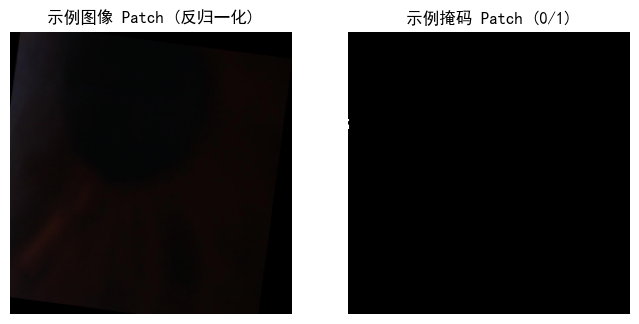

In [13]:
try:
    images_batch, masks_batch = next(iter(train_loader))
    print("\n从训练加载器获取一个批次的数据:")
    print(f"图像批次形状: {images_batch.shape}") # 应该类似 [BATCH_SIZE, 3, PATCH_SIZE, PATCH_SIZE]
    print(f"掩码批次形状: {masks_batch.shape}")   # 应该类似 [BATCH_SIZE, 1, PATCH_SIZE, PATCH_SIZE]
    print(f"图像数据类型: {images_batch.dtype}")
    print(f"掩码数据类型: {masks_batch.dtype}")
    print(f"掩码最小值: {masks_batch.min()}") # 应该是 0.0
    print(f"掩码最大值: {masks_batch.max()}") # 应该是 1.0
    
    # 可视化一个样本
    sample_idx = 0
    img_sample = images_batch[sample_idx].permute(1, 2, 0).numpy() # CHW -> HWC
    mask_sample = masks_batch[sample_idx].squeeze().numpy()       # 1HW -> HW
    
    # 反归一化以便显示
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_sample = std * img_sample + mean
    img_sample = np.clip(img_sample, 0, 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img_sample)
    axes[0].set_title("示例图像 Patch (反归一化)")
    axes[0].axis('off')
    axes[1].imshow(mask_sample, cmap='gray')
    axes[1].set_title("示例掩码 Patch (0/1)")
    axes[1].axis('off')
    plt.show()

except StopIteration:
    print("错误：无法从 DataLoader 获取数据，请检查数据集是否为空或配置是否正确。")
except Exception as e:
    print(f"测试 DataLoader 时出错: {e}")

# 构建DeepLabV3分割模型
使用 torchvision 的 DeepLabV3 实现，并可选择 ResNet34 或 ResNet50 作为骨干网络。

In [14]:
def create_deeplabv3(backbone_name='resnet50', num_classes=1, pretrained_backbone=True):
    """
    创建 DeepLabV3 模型，可选择 ResNet50 或 ResNet34 骨干网络。

    Args:
        backbone_name (str): 骨干网络名称 ('resnet50' or 'resnet34').
        num_classes (int): 输出类别的数量 (对于二元分割为 1).
        pretrained_backbone (bool): 是否为骨干网络加载 ImageNet 预训练权重。

    Returns:
        torch.nn.Module: 配置好的 DeepLabV3 模型。
    """
    print(f"创建 DeepLabV3 模型，骨干网络: {backbone_name}, 类别数: {num_classes}, 预训练骨干: {pretrained_backbone}")

    weights_backbone = None
    if pretrained_backbone:
        if backbone_name == 'resnet50':
            weights_backbone = models.ResNet50_Weights.IMAGENET1K_V1
        elif backbone_name == 'resnet34':
            weights_backbone = models.ResNet34_Weights.IMAGENET1K_V1
        else:
            # 对于其他骨干网络，如果需要预训练，可以在这里添加
            pass # 保持 weights_backbone = None

    # --- 加载标准的 DeepLabV3 (默认用 ResNet50 或 ResNet101) ---
    # 我们先加载一个标准的预训练模型，然后根据需要修改其骨干和分类头
    # 使用 ResNet50 作为基础加载，因为它有官方的分割预训练权重
    model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT, progress=True)
    print("已加载基于 ResNet50 的预训练 DeepLabV3 (COCO weights)。")

    # --- 如果需要，用 ResNet34 替换骨干网络 ---
    if backbone_name == 'resnet34':
        print("将骨干网络替换为 ResNet34...")
        # 加载预训练的 ResNet34
        resnet34_backbone = models.resnet34(weights=weights_backbone)
        # 替换 DeepLabV3 模型中的 'backbone' 部分
        # 注意：这需要 DeepLabV3 实现允许直接替换 backbone 模块，
        # 或者我们需要手动匹配层结构。torchvision 的实现通常可以。
        # 我们需要保留 ResNet34 的 stem 和 layer1 到 layer4
        model.backbone.conv1 = resnet34_backbone.conv1
        model.backbone.bn1 = resnet34_backbone.bn1
        model.backbone.relu = resnet34_backbone.relu
        model.backbone.maxpool = resnet34_backbone.maxpool
        model.backbone.layer1 = resnet34_backbone.layer1 # 输出 64 channels (low-level features)
        model.backbone.layer2 = resnet34_backbone.layer2
        model.backbone.layer3 = resnet34_backbone.layer3
        model.backbone.layer4 = resnet34_backbone.layer4 # 输出 512 channels
        print("ResNet34 骨干网络替换完成。")
        # 重要提示：替换骨干后，模型不再完全使用原始的 COCO 分割权重，
        # 只有骨干部分（如果 pretrained_backbone=True）具有 ImageNet 权重。
        # ASPP 和分类头是从 ResNet50 的权重初始化的，需要微调。

    # --- 修改分类头以匹配 num_classes ---
    # DeepLabV3 有两个分类头：主分类头 (classifier) 和辅助分类头 (aux_classifier)
    # 我们需要修改两者的最后一个卷积层

    # 1. 修改主分类头 (model.classifier)
    #    通常是 DeepLabHead -> ASPP -> Conv2d(aspp_channels, aspp_channels) -> ReLU -> Dropout -> Conv2d(aspp_channels, num_classes)
    #    我们需要找到并替换最后一个 Conv2d
    #    对于 ResNet50/101/34，ASPP 的输出通道数通常是 256
    try:
        # 获取主分类头最后一个卷积层的输入通道数
        last_conv_in_channels = model.classifier[-1].in_channels
        # 创建新的最后一个卷积层
        model.classifier[-1] = nn.Conv2d(last_conv_in_channels, num_classes, kernel_size=1)
        print(f"主分类头已修改为输出 {num_classes} 类。")
    except Exception as e:
        print(f"自动修改主分类头失败: {e}")
        print("模型分类器结构:", model.classifier)
        # 如果失败，你可能需要手动检查 model.classifier 的结构并进行替换

    # 2. 修改辅助分类头 (model.aux_classifier) (如果存在且需要训练)
    #    通常是 FCNHead -> Conv2d -> ReLU -> Dropout -> Conv2d
    #    它接收来自骨干网络中间层（如 layer3）的特征
    if hasattr(model, 'aux_classifier') and model.aux_classifier is not None:
        try:
            # 获取辅助分类头最后一个卷积层的输入通道数
            # ResNet layer3 输出通道: ResNet50/101=1024, ResNet34=256
            # 这个值需要与 FCNHead 内部的通道数匹配
            # 或者直接获取最后一个 Conv2d 的 in_channels
            last_aux_conv_in_channels = model.aux_classifier[-1].in_channels
            # 创建新的最后一个卷积层
            model.aux_classifier[-1] = nn.Conv2d(last_aux_conv_in_channels, num_classes, kernel_size=1)
            print(f"辅助分类头已修改为输出 {num_classes} 类。")
        except Exception as e:
            print(f"自动修改辅助分类头失败: {e}")
            print("模型辅助分类器结构:", model.aux_classifier)
            # 你可以选择禁用辅助损失或手动修复
            # model.aux_classifier = None # 禁用辅助损失

    return model

# 构建U-Net分割模型
U-Net是一种经典的图像分割模型，其结构包括下采样路径（编码器）和上采样路径（解码器），以及跳跃连接。

## 辅助层

In [15]:
class DoubleConv(nn.Module):
    """双卷积块：(Conv -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """下采样层：MaxPool + DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """上采样层：UpConv + DoubleConv（带跳跃连接）"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # 使用双线性插值或转置卷积进行上采样
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, mid_channels=in_channels // 2)
        else:
            # 当使用转置卷积时，上采样会改变通道数
            # 输入的 in_channels 是拼接后的通道数
            # 转置卷积的输入应该是来自深层解码器的通道数，这里需要推断
            # 假设深层解码器输出通道数 = 跳跃连接通道数 = in_channels / 2
            deep_channels = in_channels // 2
            skip_channels = in_channels // 2
            self.up = nn.ConvTranspose2d(deep_channels, deep_channels, kernel_size=2, stride=2)
            # DoubleConv 的输入通道数仍然是拼接后的 in_channels
            self.conv = DoubleConv(in_channels, out_channels) # mid_channels 会默认为 out_channels

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # 输入可能不是整数倍的2，需要进行尺寸调整
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = Fnn.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # 连接特征图
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """输出卷积层"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

## 注意力

In [16]:
class Attention_block(nn.Module):
    """
    注意力门 (Attention Gate - AG) 用于 UNet，旨在抑制无关区域，突出相关区域。
    """
    def __init__(self, F_g, F_l, F_int):
        """
        初始化注意力门。
        Args:
            F_g (int): 来自下一层解码器（Gating Signal）的特征通道数。
            F_l (int): 来自编码器跳跃连接（Input Feature）的特征通道数。
            F_int (int): 中间层的特征通道数。
        """
        super(Attention_block, self).__init__()

        # 对 Gating Signal (g) 进行处理
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        # 对 Input Feature (x) 进行处理
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        # 计算注意力系数
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        """
        前向传播。
        Args:
            g: Gating Signal，来自更深层解码器的输出。
            x: Input Feature，来自编码器的跳跃连接。
        Returns:
            torch.Tensor: 经过注意力加权后的 Input Feature (x)。
        """
        # g 通常需要上采样以匹配 x 的尺寸，但这通常在 Up 模块或调用前完成
        # 这里假设 g 和 x 已经具有相同的空间尺寸

        # 对 g 和 x 分别进行线性变换
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        # 将变换后的 g 和 x 相加，并通过 ReLU
        # 注意：这里 g1 和 x1 必须有相同的空间尺寸
        psi = self.relu(g1 + x1)

        # 计算注意力系数 alpha (通道数为 1)
        psi = self.psi(psi) # (N, 1, H, W)

        # 将注意力系数 alpha 应用到 x 上 (逐元素相乘)
        # alpha 会自动广播到 x 的通道维度
        return x * psi

## UNet

In [17]:
class UNet(nn.Module):
    """完整的UNet模型"""
    def __init__(self, n_channels=3, n_classes=1, bilinear=True, dropout_p=0.5):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.dropout_p = dropout_p

        # 加载预训练的ResNet
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

        # 编码器部分 (使用ResNet的层)
        self.inc = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        ) # 输出通道: 64
        self.maxpool = resnet.maxpool
        self.down1 = resnet.layer1 # 输出通道: 64
        self.down2 = resnet.layer2 # 输出通道: 128
        self.down3 = resnet.layer3 # 输出通道: 256
        self.down4 = resnet.layer4 # 输出通道: 512

        # --- 瓶颈层后 Dropout 层 ---
        self.dropout = nn.Dropout(self.dropout_p)

        # 解码器部分 (调整通道数以匹配ResNet)
        factor = 2 if bilinear else 1
        self.up1 = Up(512 + 256, 512 // factor, bilinear) # down4(512) + down3(256) -> 256
        self.up2 = Up(256 + 128, 256 // factor, bilinear) # up1(256) + down2(128) -> 128
        self.up3 = Up(128 + 64, 128 // factor, bilinear)  # up2(128) + down1(64) -> 64
        self.up4 = Up(64 + 64, 64, bilinear)             # up3(64) + inc(64) -> 64
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # 编码路径 (ResNet)
        x1 = self.inc(x)       # (N, 64, H/2, W/2) after initial conv+bn+relu (stride=2)
        x_pool = self.maxpool(x1) # (N, 64, H/4, W/4)
        x2 = self.down1(x_pool) # (N, 64, H/4, W/4)
        x3 = self.down2(x2)     # (N, 128, H/8, W/8)
        x4 = self.down3(x3)     # (N, 256, H/16, W/16)
        x5 = self.down4(x4)     # (N, 512, H/32, W/32)

        # --- Dropout 层 ---
        x5_dropout = self.dropout(x5)

        # 解码路径 (带跳跃连接)
        x = self.up1(x5_dropout, x4) # 输入: x5(512), x4(256) -> 输出: 256
        x = self.up2(x, x3)  # 输入: x(256), x3(128) -> 输出: 128
        x = self.up3(x, x2)  # 输入: x(128), x2(64) -> 输出: 64
        x = self.up4(x, x1)  # 输入: x(64), x1(64) -> 输出: 64
        logits = self.outc(x)
        return logits

In [18]:
class UNetAttention(nn.Module):
    """UNet模型+ResNet+Dropout+注意力"""
    def __init__(self, n_channels=3, n_classes=1, bilinear=True, dropout_p=0.5):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.dropout_p = dropout_p

        # 加载预训练的ResNet
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

        # 编码器部分 (使用ResNet的层)
        self.inc = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        ) # 输出通道: 64
        self.maxpool = resnet.maxpool
        self.down1 = resnet.layer1 # 输出通道: 64
        self.down2 = resnet.layer2 # 输出通道: 128
        self.down3 = resnet.layer3 # 输出通道: 256
        self.down4 = resnet.layer4 # 输出通道: 512

        # --- 瓶颈层后 Dropout 层 ---
        self.dropout = nn.Dropout(self.dropout_p)

        # 解码器部分 (调整通道数以匹配ResNet)
        self.up1 = Up(in_channels=768, out_channels=256, bilinear=bilinear)
        # up2: 输入拼接自 x3_att(128) 和 d1(256), 输出 128
        self.up2 = Up(in_channels=384, out_channels=128, bilinear=bilinear)
        # up3: 输入拼接自 x2_att(64) 和 d2(128), 输出 64
        self.up3 = Up(in_channels=192, out_channels=64, bilinear=bilinear)
        # up4: 输入拼接自 x1_att(64) 和 d3(64), 输出 64
        self.up4 = Up(in_channels=128, out_channels=64, bilinear=bilinear)
        
        # --- 注意力门实例 ---
        # F_g: 来自深层解码器的通道数, F_l: 来自编码器跳跃连接的通道数, F_int: 中间通道数 (通常设为 F_l // 2 或 F_g // 2)
        self.att1 = Attention_block(F_g=512, F_l=256, F_int=128) # 处理 x4
        self.att2 = Attention_block(F_g=256, F_l=128, F_int=64)  # 处理 x3
        self.att3 = Attention_block(F_g=128, F_l=64, F_int=32)   # 处理 x2 (down1 的输出)
        self.att4 = Attention_block(F_g=64, F_l=64, F_int=32)    # 处理 x1 (inc 的输出)

        # --- 上采样层 (用于匹配 Attention Gate 输入尺寸) ---
        # 这里我们选择在 Attention Gate 内部处理尺寸匹配，或者在上采样模块 Up 中处理
        # 为了简化，我们在调用 Attention Gate 前确保 g 和 x 尺寸一致
        self.up_bilinear_x2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # --- 输出卷积 ---
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # 编码路径 (ResNet)
        x1 = self.inc(x)       # (N, 64, H/2, W/2) after initial conv+bn+relu (stride=2)
        x_pool = self.maxpool(x1) # (N, 64, H/4, W/4)
        x2 = self.down1(x_pool) # (N, 64, H/4, W/4)
        x3 = self.down2(x2)     # (N, 128, H/8, W/8)
        x4 = self.down3(x3)     # (N, 256, H/16, W/16)
        x5 = self.down4(x4)     # (N, 512, H/32, W/32)

        # --- Dropout 层 ---
        x5_dropout = self.dropout(x5)

        # 解码路径 (带跳跃连接)
        # --- 解码路径 ---
        # Level 1: 处理 x4 (来自 down3)
        g1 = self.up_bilinear_x2(x5_dropout) # 上采样 gating signal (来自瓶颈层)
        x4_att = self.att1(g=g1, x=x4)       # 计算注意力加权的 x4
        d1 = self.up1(g1, x4_att)            # 使用加权的 x4 进行上采样和合并

        # Level 2: 处理 x3 (来自 down2)
        g2 = self.up_bilinear_x2(d1)         # 上采样 gating signal (来自上一解码层)
        x3_att = self.att2(g=g2, x=x3)       # 计算注意力加权的 x3
        d2 = self.up2(g2, x3_att)            # 使用加权的 x3 进行上采样和合并

        # Level 3: 处理 x2 (来自 down1)
        g3 = self.up_bilinear_x2(d2)         # 上采样 gating signal
        x2_att = self.att3(g=g3, x=x2)       # 计算注意力加权的 x2
        d3 = self.up3(g3, x2_att)            # 使用加权的 x2 进行上采样和合并

        # Level 4: 处理 x1 (来自 inc)
        g4 = self.up_bilinear_x2(d3)         # 上采样 gating signal
        x1_att = self.att4(g=g4, x=x1)       # 计算注意力加权的 x1
        # 注意：这里的 Up 模块 (up4) 输入通道数需要匹配拼接后的通道数
        # Up(in_channels=64+64, out_channels=64)
        d4 = self.up4(g4, x1_att)            # 使用加权的 x1 进行上采样和合并

        logits = self.outc(d4)
        return logits

# 初始化模型

In [19]:
if train_model_select == 'unet':
    model = UNet(n_classes=1, bilinear=True, dropout_p=0.5).to(device)
elif train_model_select == 'unet_attention':
    model = UNetAttention(n_classes=1, bilinear=True, dropout_p=0.5).to(device)
elif train_model_select == 'deeplabv3':
    model = create_deeplabv3(backbone_name='resnet50', num_classes=1, pretrained_backbone=True).to(device)
if torch.cuda.device_count() > 1:
    print(f"检测到 {torch.cuda.device_count()} 块GPU, 由于多卡存在问题，只使用GPU0")
    #model = nn.DataParallel(model)

os.system('pip install torchinfo')
from torchinfo import summary

#print("\n模型摘要:")
#summary(model, input_size=(cuda_batch_size if torch.cuda.is_available() else windows_batch_size, 3, patch_size, patch_size))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 184MB/s]


# 定义损失函数和评估指标
我们使用组合损失函数：二元交叉熵损失和Dice损失的组合，以更好地处理类别不平衡问题。

## Dice损失

In [20]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, logits, targets):
        # 使用sigmoid将logits转换为概率
        probs = torch.sigmoid(logits)

        # 将维度展平
        batch_size = targets.size(0)
        probs = probs.view(batch_size, -1)
        targets = targets.view(batch_size, -1)

        # 计算交集
        intersection = (probs * targets).sum(dim=1)

        # 计算Dice系数
        dice = (2. * intersection + self.smooth) / (
            probs.sum(dim=1) + targets.sum(dim=1) + self.smooth)

        # 返回Dice损失
        return 1 - dice.mean()

# 评估指标：Dice系数
def dice_coefficient(y_pred, y_true, threshold=0.5, smooth=1e-6):
    """计算预测掩码和真实掩码之间的Dice系数"""
    assert y_pred.shape == y_true.shape, f"预测形状 {y_pred.shape} 与目标形状 {y_true.shape} 不匹配"
    # 应用阈值将概率转换为二值掩码
    y_pred = (torch.sigmoid(y_pred) > threshold).float()
    
    # 压平张量
    y_pred = y_pred.contiguous().view(-1)
    y_true = y_true.contiguous().view(-1)
    
    # 计算交集
    intersection = (y_pred * y_true).sum()
    
    # 计算Dice系数
    dice = (2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)
    
    return dice.item()

## 边界损失

In [21]:
from scipy.ndimage import distance_transform_edt as distance_transform

class BoundaryLoss(nn.Module):
    """
    计算边界损失。
    基于论文: "Boundary loss for highly unbalanced segmentation"
    https://arxiv.org/abs/1812.07032
    """
    def __init__(self, theta0=3, theta=5):
        super().__init__()
        self.theta0 = theta0
        self.theta = theta

    def forward(self, pred_probs, gt_masks):
        """
        计算边界损失。
        Args:
            pred_probs (torch.Tensor): 模型的概率图输出 (经过 Sigmoid), shape (N, 1, H, W)
            gt_masks (torch.Tensor): 真实的二值掩码 (0 或 1), shape (N, 1, H, W)
        Returns:
            torch.Tensor: 边界损失值 (标量)
        """
        n, c, _, _ = pred_probs.shape # 获取 Batch size 和 Channel

        # --- 1. 计算距离图 ---
        # 需要在 CPU 上使用 numpy 计算距离变换
        gt_masks_npy = gt_masks.cpu().numpy().astype(np.uint8) # (N, 1, H, W)
        dist_maps = np.zeros_like(gt_masks_npy, dtype=np.float32)

        for i in range(n):
            gt_mask_single = gt_masks_npy[i, 0, :, :] # (H, W)
            # 计算内部距离 (前景到边界) 和外部距离 (背景到边界)
            inside_dist = distance_transform(gt_mask_single)
            outside_dist = distance_transform(1 - gt_mask_single)
            # 合并成一个距离图，边界处为0，内部为正，外部为负 (或相反，取决于定义)
            # 这里我们让边界内部为正，外部为负
            dist_map = inside_dist - outside_dist
            dist_maps[i, 0, :, :] = dist_map

        # 将距离图转换回 Tensor 并移到目标设备
        dist_maps_tensor = torch.from_numpy(dist_maps).to(pred_probs.device)

        # --- 2. 计算边界区域的加权 ---
        # 使用边界指示函数 phi(d) = 1 if |d| <= theta else 0 (近似)
        # 这里使用一种更平滑的方式: 基于距离的加权，惩罚远离边界的错误预测
        # 我们使用论文中的方法：将距离图限制在一个范围内并归一化
        # 这里简化一下，直接使用距离图进行加权 (距离边界越远，乘积越大)
        # 或者使用类似水平集函数的思想 phi(x) = exp(-alpha * |x|)
        # 这里采用一个简单的方式：直接用距离图与预测概率相乘

        # --- 3. 计算损失 ---
        # 惩罚预测概率与符号距离的乘积
        # 目标：前景(gt=1, dist>0) 预测概率(pred)应接近1，损失为 (1-pred)*dist
        #       背景(gt=0, dist<0) 预测概率(pred)应接近0，损失为 pred*(-dist)
        # 合并为: loss = pred * (-dist) if gt=0 else (1-pred)*dist
        # 可以简化为: loss = |pred - gt| * |dist|  (近似, 需要验证)
        # 或者直接使用论文中的积分形式： integral[ phi(gt_dist) * pred_prob ] dx
        # 这里我们使用论文中的简化形式： L_B = mean( phi_g * pred_prob )
        # 其中 phi_g 是和 gt boundary 相关的 level set function

        # 简化实现: 计算预测概率与距离图的乘积的平均值
        # 我们希望在边界附近 (dist 接近 0) 的乘积小，在远离边界的错误区域乘积大
        # 使用绝对距离可能更直观
        abs_dist_maps = torch.abs(dist_maps_tensor)
        # loss_b = (pred_probs * abs_dist_maps).mean() # 简单版本

        # 尝试更接近原文的实现：
        # 计算 level set function phi_g (这里用 gt_masks 近似边界区域)
        # 惩罚边界区域 (gt_masks=1 附近) 的低概率 和 非边界区域 (gt_masks=0 附近) 的高概率
        # 这里直接使用论文提供的另一种形式：L_B = mean(gt * log(pred) + (1-gt) * log(1-pred)) * weight_map
        # weight_map 基于距离变换

        # 采用更直接的距离加权损失:
        # 对前景像素，惩罚 (1-probs) * dist_inside
        # 对背景像素，惩罚 probs * dist_outside
        # 需要分别计算内外距离图
        dist_inside_maps = np.zeros_like(gt_masks_npy, dtype=np.float32)
        dist_outside_maps = np.zeros_like(gt_masks_npy, dtype=np.float32)
        for i in range(n):
            gt_mask_single = gt_masks_npy[i, 0, :, :]
            dist_inside_maps[i, 0, :, :] = distance_transform(gt_mask_single)
            dist_outside_maps[i, 0, :, :] = distance_transform(1 - gt_mask_single)

        dist_inside_tensor = torch.from_numpy(dist_inside_maps).to(pred_probs.device)
        dist_outside_tensor = torch.from_numpy(dist_outside_maps).to(pred_probs.device)

        # 计算损失
        loss = (1 - gt_masks) * pred_probs * dist_outside_tensor + \
               gt_masks * (1 - pred_probs) * dist_inside_tensor

        # 对整个 Batch 和空间维度求平均
        return loss.mean()

## 组合损失

In [22]:
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        # BCEWithLogitsLoss 实例本身不存储 pos_weight, 在 forward 中传入
        self.bce_loss_fn = nn.BCEWithLogitsLoss()
        self.dice_loss_fn = DiceLoss()

    def forward(self, logits, targets, pos_weight=None):
        """
        计算组合损失。
        :param logits: 模型输出 (N, 1, H, W)
        :param targets: 真实掩码 (N, 1, H, W)
        :param pos_weight: 正样本权重 (scalar) for BCE loss.
        """
        # 更新BCE损失的pos_weight参数
        self.bce_loss_fn.pos_weight = pos_weight
        bce = self.bce_loss_fn(logits, targets)

        dice = self.dice_loss_fn(logits, targets)
        return self.bce_weight * bce + self.dice_weight * dice

In [23]:
# --- 组合损失 (加入边界损失) ---
class CombinedLossWithBoundary(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5, boundary_weight=1.0): # 增加边界损失权重
        super(CombinedLossWithBoundary, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.boundary_weight = boundary_weight # 新增权重
        self.bce_loss_fn = nn.BCEWithLogitsLoss()
        self.dice_loss_fn = DiceLoss()
        self.boundary_loss_fn = BoundaryLoss() # 实例化边界损失

    def forward(self, logits, targets, pos_weight=None):
        # 更新BCE损失的pos_weight参数
        self.bce_loss_fn.pos_weight = pos_weight
        bce = self.bce_loss_fn(logits, targets)

        dice = self.dice_loss_fn(logits, targets)

        # 计算边界损失 (需要概率图和真实掩码)
        # 注意：BoundaryLoss 内部会计算 sigmoid
        # 但我们这里传入 probs 和 targets 确保输入一致性
        probs = torch.sigmoid(logits)
        boundary = self.boundary_loss_fn(probs, targets)

        # 计算加权总损失
        total_loss = self.bce_weight * bce + \
                     self.dice_weight * dice + \
                     self.boundary_weight * boundary # 加入边界损失
        #print(f"bce: {bce.item():.4f}, dice: {dice.item():.4f}, boundary: {boundary.item():.4f}")
        return total_loss

In [24]:
# 初始化损失函数
criterion = CombinedLossWithBoundary(bce_weight=0.6, dice_weight=0.4, boundary_weight=0.01).to(device)

# bce: 0.8842, dice: 0.3501, boundary: 15.5918
# bce: 0.9119, dice: 0.3842, boundary: 18.1574
# bce: 0.7916, dice: 0.3559, boundary: 18.3994

#criterion = CombinedLoss(bce_weight=0.6, dice_weight=0.4).to(device)

try:
    print(f"使用的损失函数: {type(criterion).__name__}")
    print(f"  - BCE 权重: {criterion.bce_weight}")
    print(f"  - Dice 权重: {criterion.dice_weight}")
    print(f"  - Boundary 权重: {criterion.boundary_weight}")
except:
    pass

使用的损失函数: CombinedLossWithBoundary
  - BCE 权重: 0.6
  - Dice 权重: 0.4
  - Boundary 权重: 0.01


# 配置优化器和训练参数
设置Adam优化器和学习率调度器，为模型训练做准备。

In [25]:
# 配置优化器
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=7e-5)

# 学习率调度器
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6) # 使用基线超参数

# 训练模型
实现训练循环，包括前向传播、损失计算、反向传播、参数更新，并记录训练过程中的指标。同时实现早停机制。

In [26]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.0, mode='max', verbose=True):
        """
        Args:
            patience (int): 在性能没有提升多少轮后停止训练。
            min_delta (float): 被认为是性能提升的最小变化量。
            mode (str): 'min' 或 'max'。监控指标是越小越好还是越大越好。
            verbose (bool): 是否打印早停信息。
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state_dict_cpu = None # 直接存储 CPU 上的 state_dict

        if self.mode not in ['min', 'max']:
            raise ValueError("mode 必须是 'min' 或 'max'")

        self.delta_sign = 1 if mode == 'max' else -1

    def __call__(self, val_score, model_state_dict_cpu):
        """
        Args:
            val_score (float): 当前验证分数。
            model_state_dict_cpu (dict): 模型当前的 state_dict (已移至 CPU)。
        """
        score = val_score

        if self.best_score is None:
            self.best_score = score
            self.best_model_state_dict_cpu = deepcopy(model_state_dict_cpu) # 保存第一个状态
            if self.verbose:
                tqdm.write(f"EarlyStopping: 初始化最佳分数为 {self.best_score:.4f}")
        # 检查是否有足够的提升 (乘以 delta_sign 以统一处理 min/max)
        elif (score * self.delta_sign) > (self.best_score * self.delta_sign) + self.min_delta:
            self.best_score = score
            self.best_model_state_dict_cpu = deepcopy(model_state_dict_cpu) # 保存更好的状态
            self.counter = 0
            if self.verbose:
                tqdm.write(f"EarlyStopping: 发现改进。最佳分数更新为 {self.best_score:.4f}。计数器重置。")
        else:
            self.counter += 1
            if self.verbose:
                tqdm.write(f'EarlyStopping计数器: {self.counter}/{self.patience}。最佳分数仍为 {self.best_score:.4f}。')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    tqdm.write("EarlyStopping: 已达到耐心值，触发早停。")

    def load_best_weights(self, model):
        """将最佳权重加载回模型"""
        if self.best_model_state_dict_cpu:
            # 需要将 state_dict 移回模型所在的设备
            device = next(model.parameters()).device
            best_state_device = {k: v.to(device) for k, v in self.best_model_state_dict_cpu.items()}
            model.load_state_dict(best_state_device)
            if self.verbose:
                print("已将最佳模型权重加载回模型。")
        else:
            if self.verbose:
                print("警告：未找到可加载的最佳模型权重。")

In [27]:
def train_validate_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    """
    训练并验证模型一个完整的周期，支持单核TPU、CUDA和CPU。

    Args:
        model (nn.Module): 要训练的模型 (应已移动到目标 device)。
        train_loader (DataLoader): 训练数据加载器。
        val_loader (DataLoader): 验证数据加载器。
        criterion (nn.Module): 损失函数。
        optimizer: 优化器。
        scheduler: 学习率调度器。
        num_epochs (int): 训练的总轮数。
        device (torch.device or str): 目标设备 ('cpu', 'cuda', or xm.xla_device())。

    Returns:
        tuple: (最终验证Dice系数, 训练Dice历史, 验证Dice历史, 最佳模型在CPU上的state_dict)
            如果验证加载器为 None，则最终验证 Dice 为 0，验证历史为空。
    """
    start_time = time.time()
    is_tpu = 'xla' in str(device)
    print(f"\n--- 开始训练 ---")
    print(f"设备: {device}")
    print(f"轮数: {num_epochs}")
    print(f"优化器: {type(optimizer).__name__}")
    print(f"学习率调度器: {type(scheduler).__name__}")
    print(f"损失函数: {type(criterion).__name__}")

    # 初始化 EarlyStopping
    # 注意：如果 val_loader 为 None，早停将基于不存在的验证分数，实际上不会起作用，
    # 但我们仍然创建它以保持代码结构一致。训练将运行完所有 num_epochs。
    # 在这种情况下，我们保存最后一轮的模型。
    early_stopping = EarlyStopping(patience=7, mode='max', min_delta=0.001, verbose=True)

    # 配置混合精度 (仅用于 CUDA)
    use_amp = not is_tpu and torch.cuda.is_available()
    scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())
    print(f"使用混合精度 (AMP): {use_amp}")

    train_dice_history = []
    val_dice_history = []
    best_model_state_dict_cpu = None # 存储在CPU上的最佳权重

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # --- 训练阶段 ---
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_samples = 0
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)

        for images, masks in train_loader_tqdm:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            # --- 计算 pos_weight (移至设备) ---
            num_pixels = masks.numel()
            num_pos = torch.sum(masks)
            num_neg = num_pixels - num_pos
            # 避免除以零，并确保 pos_weight 合理
            pos_weight_value = torch.clamp(num_neg / (num_pos + 1e-6), min=1.0) # 至少为1，防止过分抑制前景
            pos_weight_tensor = torch.tensor([pos_weight_value], device=device)

            # --- 前向传播 (根据需要使用 AMP) ---
            with torch.amp.autocast(device_type=str(device).split(':')[0], enabled=use_amp):
                outputs = model(images)
                # 检查模型输出是否是字典 (DeepLabV3 训练时返回字典)
                if isinstance(outputs, collections.OrderedDict):
                    outputs = outputs['out'] # 取主输出
                # 确保掩码尺寸与输出匹配
                masks_downsampled = Fnn.interpolate(masks, size=outputs.shape[2:], mode='nearest')
                loss = criterion(outputs, masks_downsampled, pos_weight=pos_weight_tensor)

            # --- 反向传播和优化 ---
            if is_tpu:
                loss.backward()
                # xm.optimizer_step 会处理梯度同步（如果需要）和权重更新
                xm.optimizer_step(optimizer)
                # 对于单核 TPU，通常不需要显式的 xm.mark_step() 在这里
            else: # CPU 或 CUDA
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            # --- 累积指标 ---
            batch_size = images.size(0)
            train_loss += loss.item() * batch_size
            # dice_coefficient 应能在各种设备上运行
            current_dice = dice_coefficient(outputs.detach(), masks_downsampled.detach())
            train_dice += current_dice * batch_size
            train_samples += batch_size

            # --- 更新进度条 ---
            current_lr = optimizer.param_groups[0]['lr']
            train_loader_tqdm.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{current_dice:.4f}',
                'lr': f'{current_lr:.1e}',
                'pw': f'{pos_weight_value.item():.2f}'
            })

        # --- 计算平均训练指标 ---
        if train_samples > 0:
            train_loss /= train_samples
            train_dice /= train_samples
        else:
            train_loss, train_dice = 0.0, 0.0 # 处理空 loader 的情况
        train_dice_history.append(train_dice)

        # --- 验证阶段 (如果 val_loader 存在) ---
        current_val_dice = 0.0 # 初始化本轮验证分数
        if val_loader:
            model.eval()
            val_loss = 0.0
            val_dice = 0.0
            val_samples = 0
            val_loader_tqdm = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', leave=False)

            with torch.no_grad():
                for images, masks in val_loader_tqdm:
                    images, masks = images.to(device), masks.to(device)

                    # 前向传播 (验证时通常不使用 AMP autocast，但也可以用)
                    outputs = model(images)
                    # 检查模型输出是否是字典 (DeepLabV3 训练时返回字典)
                    if isinstance(outputs, collections.OrderedDict):
                        outputs = outputs['out'] # 取主输出
                    masks_downsampled = Fnn.interpolate(masks, size=outputs.shape[2:], mode='nearest')
                    # 验证时不使用 pos_weight
                    loss = criterion(outputs, masks_downsampled, pos_weight=None)

                    # --- 累积指标 ---
                    batch_size = images.size(0)
                    val_loss += loss.item() * batch_size
                    current_dice_val = dice_coefficient(outputs, masks_downsampled)
                    val_dice += current_dice_val * batch_size
                    val_samples += batch_size

                    val_loader_tqdm.set_postfix({
                        'loss': f'{loss.item():.4f}',
                        'dice': f'{current_dice_val:.4f}'
                        })


            # --- 计算平均验证指标 ---
            if val_samples > 0:
                val_loss /= val_samples
                val_dice /= val_samples
            else:
                val_loss, val_dice = 0.0, 0.0 # 处理空 loader
            val_dice_history.append(val_dice)
            current_val_dice = val_dice # 更新本轮验证分数用于早停

            epoch_duration = time.time() - epoch_start_time
            tqdm.write(f"Epoch [{epoch + 1}/{num_epochs}], "
                    f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, "
                    f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, "
                    f"LR: {current_lr:.1e}, Duration: {epoch_duration:.2f}s")

            # --- 早停检查 (仅当有验证集时) ---
            # 获取当前模型状态到 CPU
            current_model_state_cpu = {k: v.cpu() for k, v in model.state_dict().items()}
            early_stopping(current_val_dice, current_model_state_cpu) # 使用修改后的 ES 类
            if early_stopping.early_stop:
                best_model_state_dict_cpu = early_stopping.best_model_state_dict_cpu # 获取最佳状态
                break # 跳出 epoch 循环

        else:
            # 如果没有验证集，直接打印训练结果
            epoch_duration = time.time() - epoch_start_time
            tqdm.write(f"Epoch [{epoch + 1}/{num_epochs}], "
                    f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, "
                    f"LR: {current_lr:.1e}, Duration: {epoch_duration:.2f}s")
            # 没有验证集，无法早停，将保存最后一轮的模型状态
            if epoch == num_epochs - 1: # 如果是最后一轮
                best_model_state_dict_cpu = {k: v.cpu() for k, v in model.state_dict().items()}


        # --- 更新学习率 ---
        # CosineAnnealingLR 在每个 epoch 后调用 step()
        scheduler.step()

    # --- 训练结束处理 ---
    total_training_time = time.time() - start_time
    print("\n--- 训练完成 ---")

    # 如果没有提前停止，并且有最佳权重记录 (来自验证过程)
    if not early_stopping.early_stop and early_stopping.best_model_state_dict_cpu is not None:
        best_model_state_dict_cpu = early_stopping.best_model_state_dict_cpu
        print(f"训练完成 {num_epochs} 轮。使用验证集找到的最佳模型权重。")
    elif early_stopping.early_stop:
        print(f"训练因早停而在第 {epoch + 1} 轮结束。")
        # best_model_state_dict_cpu 已在 break 前被赋值
    elif best_model_state_dict_cpu is None: # 训练完成但从未有过最佳状态(例如val_loader=None)
        print("警告：训练完成，但没有记录最佳模型权重（可能因为没有验证集）。将使用最后一轮的模型权重。")
        # 此时 best_model_state_dict_cpu 应该已经被赋值为最后一轮的状态
        if best_model_state_dict_cpu is None: # 双重检查，理论上不应发生
            best_model_state_dict_cpu = {k: v.cpu() for k, v in model.state_dict().items()}


    # --- 使用最佳模型进行最终评估 (如果 val_loader 存在) ---
    final_val_dice = 0.0
    if val_loader and best_model_state_dict_cpu:
        print("\n使用最佳权重在验证集上进行最终评估...")
        # 将最佳权重加载回模型 (确保移回正确的设备)
        best_state_device = {k: v.to(device) for k, v in best_model_state_dict_cpu.items()}
        model.load_state_dict(best_state_device)
        model.eval()
        val_samples_final = 0
        val_dice_final = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Final Validation", leave=False):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                # 检查模型输出是否是字典 (DeepLabV3 训练时返回字典)
                if isinstance(outputs, collections.OrderedDict):
                    outputs = outputs['out'] # 取主输出
                masks_downsampled = Fnn.interpolate(masks, size=outputs.shape[2:], mode='nearest')
                batch_size = images.size(0)
                val_dice_final += dice_coefficient(outputs, masks_downsampled) * batch_size
                val_samples_final += batch_size
        if val_samples_final > 0:
            final_val_dice = val_dice_final / val_samples_final
        else:
            final_val_dice = 0.0
        print(f"最终(最佳)验证 Dice 系数: {final_val_dice:.4f}")
    elif not val_loader:
        print("没有提供验证集，跳过最终验证评估。")
    else: # 有 val_loader 但没有 best_model_state_dict_cpu
        print("警告：无法获取最佳模型权重，无法进行最终验证评估。")


    print(f"总训练耗时: {total_training_time:.2f} 秒")

    # 返回最终验证 Dice 和 CPU 上的最佳 state_dict
    return final_val_dice, train_dice_history, val_dice_history, best_model_state_dict_cpu

## 训练

In [28]:
# 开始训练
best_dice, train_dice_history, val_dice_history, best_model_weights = train_validate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler, # 如果是ReduceLROnPlateau, scheduler.step(val_dice)
    num_epochs=num_epochs,
    device=device
)


--- 开始训练 ---
设备: cuda
轮数: 30
优化器: AdamW
学习率调度器: CosineAnnealingLR
损失函数: CombinedLossWithBoundary
使用混合精度 (AMP): True


Epoch 1/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/30], Train Loss: 0.7870, Train Dice: 0.7180, Val Loss: 0.6174, Val Dice: 0.7257, LR: 5.0e-04, Duration: 224.91s
EarlyStopping: 初始化最佳分数为 0.7257


Epoch 2/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/30], Train Loss: 0.6033, Train Dice: 0.8065, Val Loss: 0.5420, Val Dice: 0.7570, LR: 5.0e-04, Duration: 190.46s
EarlyStopping: 发现改进。最佳分数更新为 0.7570。计数器重置。


Epoch 3/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/30], Train Loss: 0.5461, Train Dice: 0.8231, Val Loss: 0.4397, Val Dice: 0.8281, LR: 4.9e-04, Duration: 190.76s
EarlyStopping: 发现改进。最佳分数更新为 0.8281。计数器重置。


Epoch 4/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/30], Train Loss: 0.5135, Train Dice: 0.8356, Val Loss: 0.4531, Val Dice: 0.8264, LR: 4.9e-04, Duration: 191.29s
EarlyStopping计数器: 1/7。最佳分数仍为 0.8281。


Epoch 5/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/30], Train Loss: 0.4833, Train Dice: 0.8542, Val Loss: 0.5409, Val Dice: 0.7585, LR: 4.8e-04, Duration: 191.87s
EarlyStopping计数器: 2/7。最佳分数仍为 0.8281。


Epoch 6/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/30], Train Loss: 0.4745, Train Dice: 0.8558, Val Loss: 0.4386, Val Dice: 0.8346, LR: 4.7e-04, Duration: 192.71s
EarlyStopping: 发现改进。最佳分数更新为 0.8346。计数器重置。


Epoch 7/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/30], Train Loss: 0.4536, Train Dice: 0.8661, Val Loss: 0.4664, Val Dice: 0.8066, LR: 4.5e-04, Duration: 193.52s
EarlyStopping计数器: 1/7。最佳分数仍为 0.8346。


Epoch 8/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/30], Train Loss: 0.4510, Train Dice: 0.8688, Val Loss: 0.4208, Val Dice: 0.8270, LR: 4.4e-04, Duration: 193.24s
EarlyStopping计数器: 2/7。最佳分数仍为 0.8346。


Epoch 9/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/30], Train Loss: 0.4292, Train Dice: 0.8770, Val Loss: 0.3772, Val Dice: 0.8731, LR: 4.2e-04, Duration: 193.83s
EarlyStopping: 发现改进。最佳分数更新为 0.8731。计数器重置。


Epoch 10/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/30], Train Loss: 0.4103, Train Dice: 0.8921, Val Loss: 0.3846, Val Dice: 0.8757, LR: 4.0e-04, Duration: 192.48s
EarlyStopping: 发现改进。最佳分数更新为 0.8757。计数器重置。


Epoch 11/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/30], Train Loss: 0.3967, Train Dice: 0.8956, Val Loss: 0.3760, Val Dice: 0.8722, LR: 3.8e-04, Duration: 193.35s
EarlyStopping计数器: 1/7。最佳分数仍为 0.8757。


Epoch 12/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/30], Train Loss: 0.3454, Train Dice: 0.9033, Val Loss: 0.2997, Val Dice: 0.8593, LR: 3.5e-04, Duration: 191.62s
EarlyStopping计数器: 2/7。最佳分数仍为 0.8757。


Epoch 13/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/30], Train Loss: 0.3528, Train Dice: 0.8661, Val Loss: 0.1958, Val Dice: 0.8664, LR: 3.3e-04, Duration: 190.92s
EarlyStopping计数器: 3/7。最佳分数仍为 0.8757。


Epoch 14/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/30], Train Loss: 0.3063, Train Dice: 0.8725, Val Loss: 0.1843, Val Dice: 0.8587, LR: 3.0e-04, Duration: 191.71s
EarlyStopping计数器: 4/7。最佳分数仍为 0.8757。


Epoch 15/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/30], Train Loss: 0.2729, Train Dice: 0.8759, Val Loss: 0.1904, Val Dice: 0.8489, LR: 2.8e-04, Duration: 191.88s
EarlyStopping计数器: 5/7。最佳分数仍为 0.8757。


Epoch 16/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/30], Train Loss: 0.2733, Train Dice: 0.8741, Val Loss: 0.2180, Val Dice: 0.8318, LR: 2.5e-04, Duration: 191.26s
EarlyStopping计数器: 6/7。最佳分数仍为 0.8757。


Epoch 17/30 [Train]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17/30 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/30], Train Loss: 0.2428, Train Dice: 0.8846, Val Loss: 0.1566, Val Dice: 0.8693, LR: 2.2e-04, Duration: 194.62s
EarlyStopping计数器: 7/7。最佳分数仍为 0.8757。
EarlyStopping: 已达到耐心值，触发早停。

--- 训练完成 ---
训练因早停而在第 17 轮结束。

使用最佳权重在验证集上进行最终评估...


Final Validation:   0%|          | 0/25 [00:00<?, ?it/s]

最终(最佳)验证 Dice 系数: 0.8757
总训练耗时: 3301.71 秒


# 模型保存
保存训练好的模型

In [29]:
# 保存模型参数
def save_model(model, path):
    """保存模型参数到指定路径"""
    torch.save(model.state_dict(), path)
    print(f"模型参数已保存到 {path}")
model_save_path=f'/kaggle/working/{type(model).__name__}_pterygium_seg_{best_dice:.3f}_{time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())}.pth'
save_model(model,model_save_path)

模型参数已保存到 /kaggle/working/UNet_pterygium_seg_0.876_2025-05-13-15-51-09.pth


## 可视化学习曲线，分割结果

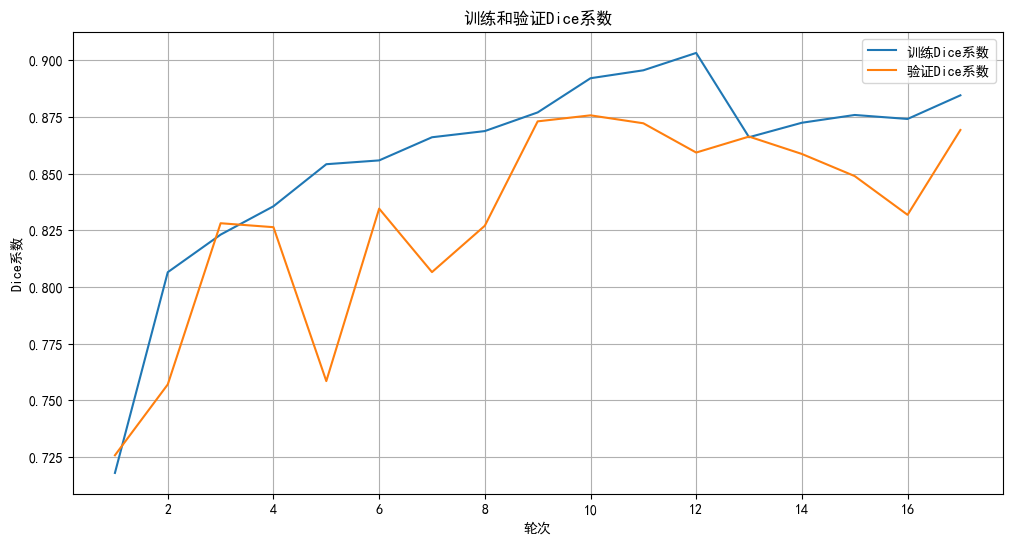

Outputs Min: -7.104243278503418, Max: 10.285655975341797, Mean: -5.1754937171936035


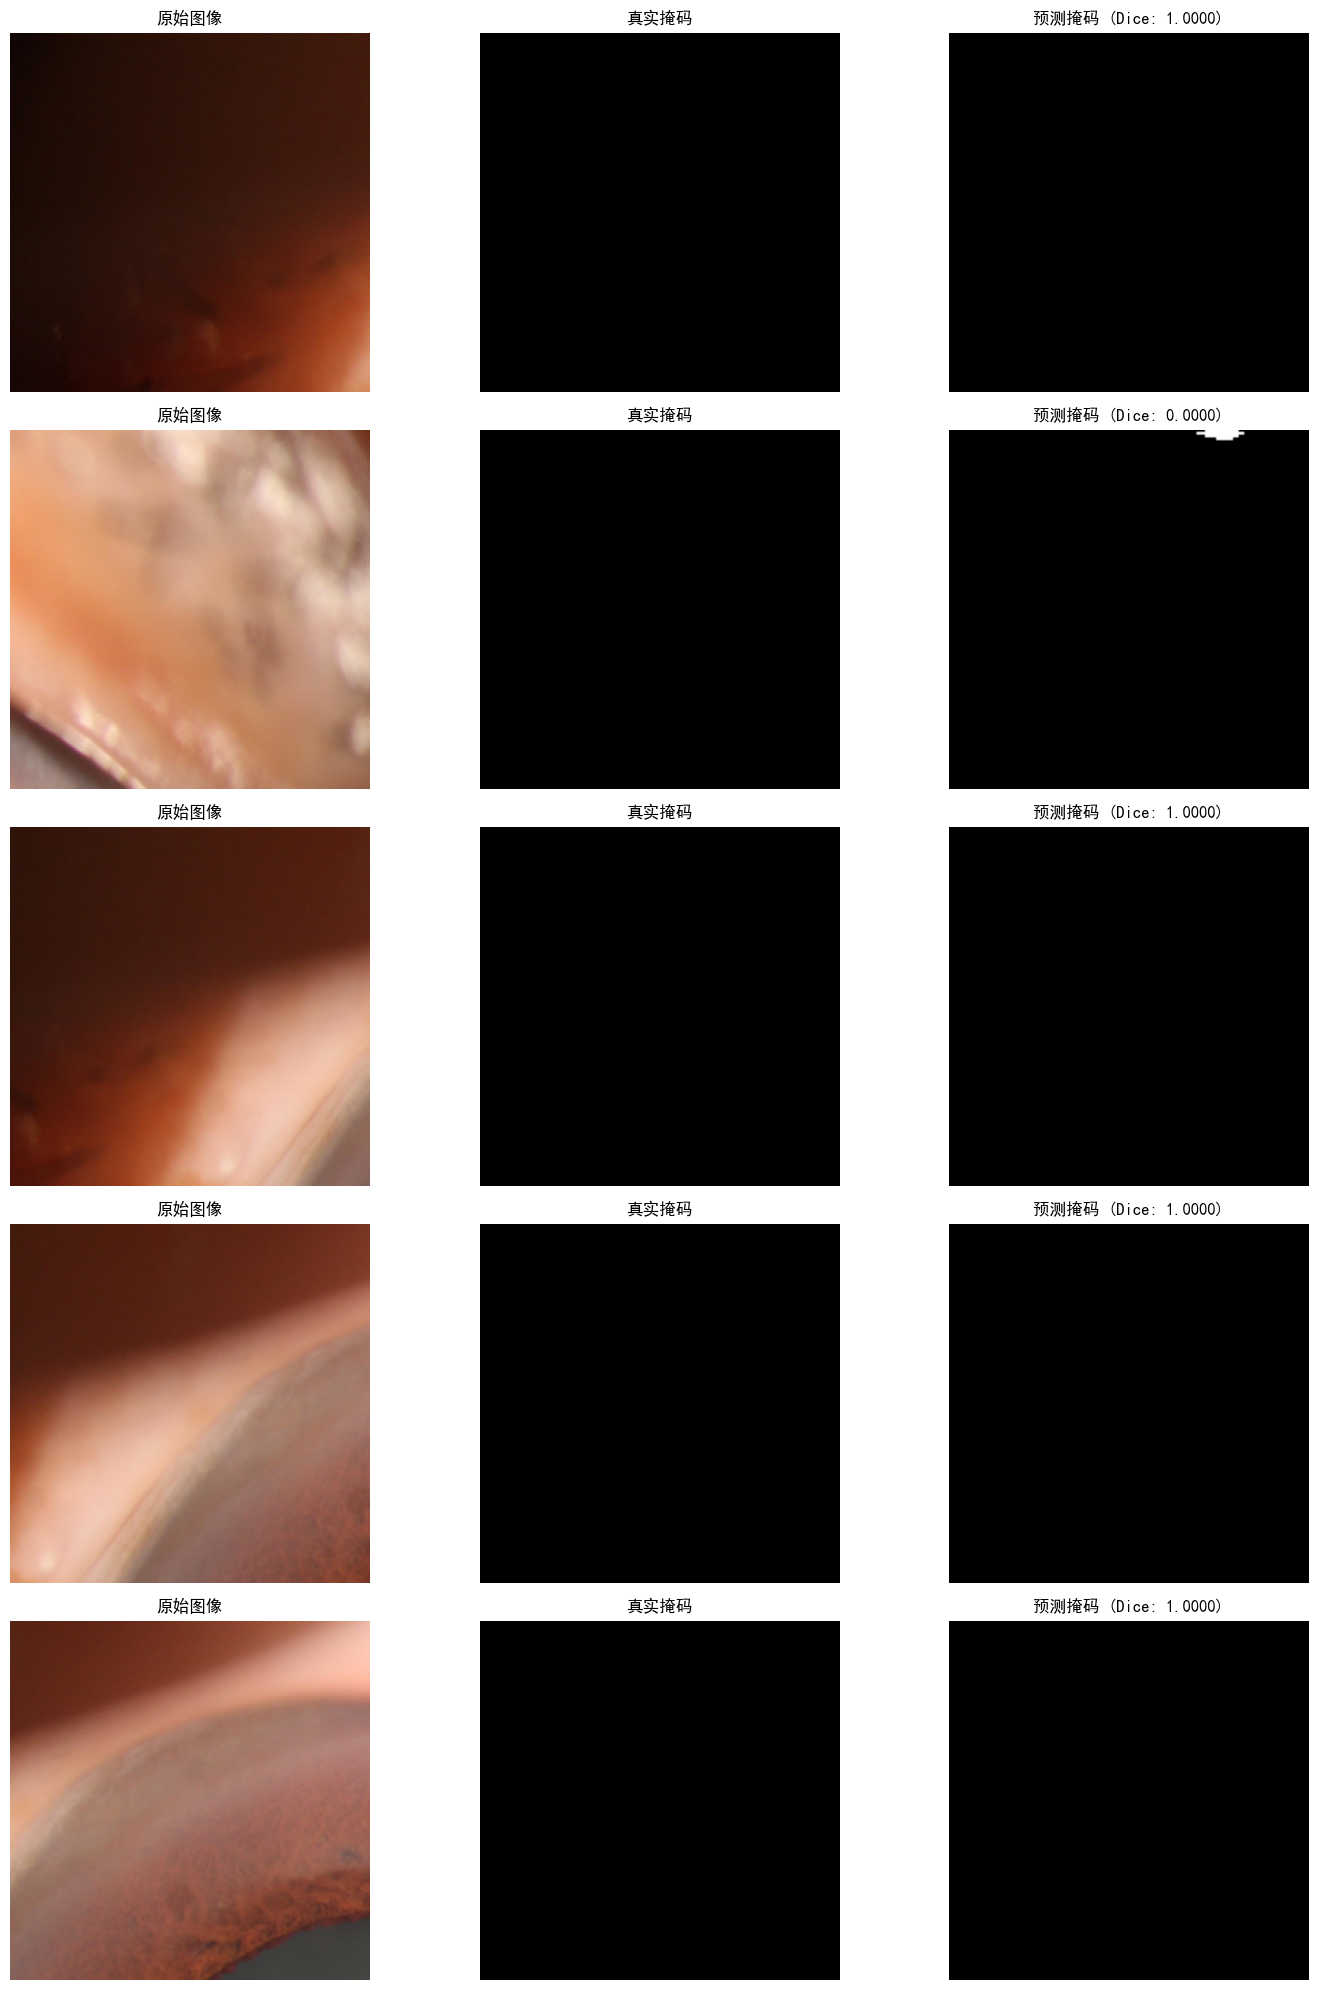

In [30]:
# 可视化学习曲线
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_dice_history) + 1), train_dice_history, label='训练Dice系数')
plt.plot(range(1, len(val_dice_history) + 1), val_dice_history, label='验证Dice系数')
plt.title('训练和验证Dice系数')
plt.xlabel('轮次')
plt.ylabel('Dice系数')
plt.legend()
plt.grid(True)
plt.show()

# 可视化分割结果
def visualize_segmentation(model, dataloader, num_samples=5):
    """可视化分割结果"""
    model.eval()
    dataiter = iter(dataloader)
    
    # 获取一批数据
    try:
        images, masks = next(dataiter)
    except StopIteration:
        print("数据集太小，无法获取足够的样本。")
        return
    
    # 限制样本数
    num_samples = min(num_samples, images.size(0))
    
    # 进行预测
    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        # 检查模型输出是否是字典 (DeepLabV3 训练时返回字典)
        if isinstance(outputs, collections.OrderedDict):
            outputs = outputs['out'] # 取主输出
        print(f"Outputs Min: {outputs.min()}, Max: {outputs.max()}, Mean: {outputs.mean()}")
        pred_masks = (torch.sigmoid(outputs) > 0.5).float()
    
    # 反标准化图像以便可视化
    images_np = []
    for img in images[:num_samples]:
        img = img.cpu().numpy().transpose(1, 2, 0)  # 转为HWC格式
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        images_np.append(img)
    
    # 准备掩码和预测
    masks_np = masks[:num_samples].cpu().numpy().squeeze(1)  # (N, H, W)
    pred_masks_np = pred_masks[:num_samples].cpu().numpy().squeeze(1)  # (N, H, W)
    
    # 可视化
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples))
    
    for i in range(num_samples):
        # 原始图像
        axes[i, 0].imshow(images_np[i])
        axes[i, 0].set_title('原始图像')
        axes[i, 0].axis('off')
        
        # 真实掩码
        axes[i, 1].imshow(masks_np[i], cmap='gray')
        axes[i, 1].set_title('真实掩码')
        axes[i, 1].axis('off')
        
        # 预测掩码
        axes[i, 2].imshow(pred_masks_np[i], cmap='gray')
        masks_downsampled = Fnn.interpolate(masks, size=outputs.shape[2:], mode='nearest')
        dice = dice_coefficient(outputs[i:i+1], masks_downsampled[i:i+1])
        axes[i, 2].set_title(f'预测掩码 (Dice: {dice:.4f})')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

try:
    visualize_segmentation(model, val_loader, num_samples=5) # 可视化验证集(resize后)的结果
except Exception as e:
    print(f"可视化分割结果时发生错误: {e}")

# 模型加载

In [31]:
# 配置模型路径
if platform.system() == "Windows":
    classification_model_path = 'w1.pth'
    model_save_path = 'work2model_dice-0.859_2025-04-24-08-47-19.pth'
else:
    # 在 Kaggle 中使用的路径
    classification_model_path = '/kaggle/input/pterygium-classification/pytorch/default/1/ResNet34Classifier_pterygium_classifier.pth'
    if 'model_save_path' not in locals().keys():
        model_save_path = '/kaggle/input/pterygiumseg/pytorch/default/5/UNet_pterygium_seg_0.933_2025-04-24-21-38-00.pth'

# 模型预测与应用

遍历测试图像，加载它们，进行预处理，然后使用加载的模型进行预测，最后将预测的掩码保存下来。

## 定义分类模型

In [32]:
# 定义test集的变换
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 构建 ResNet34 模型
from torchvision.models import ResNet34_Weights
class ResNet34Classifier(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.5):
        super().__init__()
        self.resnet34 = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        in_features = self.resnet34.fc.in_features
        self.resnet34.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.resnet34(x)

def predict_image(model, image_path, transform, device):
    """
    使用训练好的模型对单张图像进行预测
    :param model: 训练好的模型
    :param image_path: 图像路径
    :param transform: 图像预处理变换
    :param device: 设备（CPU 或 GPU）
    :return: 预测类别
    """
    model.eval()  # 设置模型为评估模式
    image = Image.open(image_path).convert("RGB")  # 加载图像并转换为RGB
    image = transform(image).unsqueeze(0).to(device)  # 应用预处理并添加批次维度

    with torch.no_grad():
        # 前向传播
        outputs = model(image)
        # 检查模型输出是否是字典 (DeepLabV3 训练时返回字典)
        if isinstance(outputs, collections.OrderedDict):
            outputs = outputs['out'] # 取主输出
        _, predicted = outputs.max(1)  # 获取预测类别
    return predicted.item()

classification_model = ResNet34Classifier(num_classes=3)
classification_model.load_state_dict(torch.load(classification_model_path, map_location=device, weights_only=True))
classification_model = classification_model.to(device)
classification_model.eval();

## 1. 加载训练好的模型

In [33]:
if train_model_select == 'unet':
    loaded_model = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)
elif train_model_select == 'unet_attention':
    loaded_model = UNetAttention(n_classes=1, bilinear=True, dropout_p=0.5).to(device)
elif train_model_select == 'deeplabv3':
    loaded_model = create_deeplabv3(backbone_name='resnet50', num_classes=1, pretrained_backbone=True).to(device)

# 加载最佳权重 (假设 best_model_weights 变量包含 state_dict)
if 'best_model_weights' in locals() and best_model_weights is not None:
    loaded_model.load_state_dict(best_model_weights)
    print("成功加载训练好的模型权重。")
else:
    # 如果没有 best_model_weights，尝试从文件加载（需要先保存）
    if os.path.exists(model_save_path):
        loaded_model.load_state_dict(torch.load(model_save_path, map_location=device, weights_only=True))
        print(f"从 {model_save_path} 加载模型权重。")
    else:
        print("警告: 未找到训练好的模型权重 (best_model_weights 或文件)。模型将使用随机初始化的权重。")

loaded_model.eval(); # 设置为评估模式

成功加载训练好的模型权重。


## 2. 定义 Tiling 预测函数

In [34]:
def predict_probability_map_from_tensor_with_tiling(model, image_tensor, patch_size, stride, device, batch_size=32):
    """
    处理单个大图张量，使用 Tiling (Unfold/Fold + 重叠平均) 进行分割预测，
    返回与输入张量相同尺寸的平均概率图。

    Args:
        model (nn.Module): 训练好的分割模型。
        image_tensor (torch.Tensor): 输入图像张量 (1 x C x H x W)。
        patch_size (int): Patch 大小 (边长)。
        stride (int): 切割 Patch 时的步长。
        device (torch.device): 计算设备 ('cuda' or 'cpu')。
        batch_size (int): 推理时的批次大小。

    Returns:
        torch.Tensor: 预测的裁剪回输入张量尺寸的平均概率图 (1 x N_Classes x H_in x W_in)。
                        返回的概率图已应用 Sigmoid，值在 [0, 1] 之间。
                        如果处理失败，返回 None。
    """
    if image_tensor is None or image_tensor.ndim != 4 or image_tensor.shape[0] != 1:
        print(f"错误: 输入图像张量格式不正确。期望 (1, C, H, W)，实际 {image_tensor.shape if image_tensor is not None else 'None'}")
        return None

    model.eval() # 确保模型在评估模式

    B, C, img_h, img_w = image_tensor.shape

    # --- 1. 图像填充 (如果需要) ---
    # 计算所需的 padding 以便能被 patch_size 完美覆盖且步长对齐
    # Note: Unfold/Fold handles partial patches at the border if stride doesn't align perfectly,
    # but padding ensures a full grid of patches.
    pad_w_needed = (patch_size - (img_w % patch_size)) % patch_size
    pad_h_needed = (patch_size - (img_h % patch_size)) % patch_size

    # Recalculate needed padding based on stride for a complete grid
    # ((img_dim - patch_size) // stride) * stride + patch_size is the minimal size
    # that allows a full tiling grid. Add stride if remainder exists.
    target_h = ((img_h - patch_size + stride) // stride) * stride + patch_size if img_h >= patch_size else patch_size
    target_w = ((img_w - patch_size + stride) // stride) * stride + patch_size if img_w >= patch_size else patch_size

    pad_h = target_h - img_h
    pad_w = target_w - img_w

    # Padding: (pad_left, pad_right, pad_top, pad_bottom) - for Tensor
    padding = (0, pad_w, 0, pad_h)
    
    # Apply padding using reflection mode
    padded_image_tensor = Fnn.pad(image_tensor, padding, mode='reflect')
    padded_h_actual = padded_image_tensor.shape[2]
    padded_w_actual = padded_image_tensor.shape[3]

    # --- 2. 使用 Unfold 提取 Patches ---
    unfold = nn.Unfold(kernel_size=(patch_size, patch_size), stride=stride)
    # 输入: (B, C, H, W) -> 输出: (B, C * ks[0] * ks[1], L) L是patch数量
    patches_unfolded = unfold(padded_image_tensor)
    B, C_ks_ks, L = patches_unfolded.shape

    # 将 unfolded patches 变形为模型所需的格式: (L, C, patch_size, patch_size)
    patches_for_model = patches_unfolded.permute(0, 2, 1).reshape(L, C, patch_size, patch_size)
    del patches_unfolded # 释放内存
    if device.type == 'cuda': torch.cuda.empty_cache() # 清理显存

    # --- 3. 分批进行模型推理 ---
    all_outputs_logits = []
    with torch.no_grad():
        for i in range(0, L, batch_size):
            batch_patches = patches_for_model[i:i+batch_size].to(device) # 将当前批次移到设备
            model_outputs = model(batch_patches) # Get the model output (might be a dict)
            if isinstance(model_outputs, collections.OrderedDict):
                # For segmentation models like DeepLabV3, 'out' key contains main output
                batch_outputs_logits = model_outputs.get('out', model_outputs) # Use .get for robustness
            else:
                # Assume it's already the main output tensor in eval mode for other models like UNet
                batch_outputs_logits = model_outputs

            # Ensure output logits have 4 dimensions (N, C, H, W)
            if batch_outputs_logits.ndim == 3:
                batch_outputs_logits = batch_outputs_logits.unsqueeze(1) # Add channel dim if missing

            all_outputs_logits.append(batch_outputs_logits.cpu()) # 将结果移回CPU以节省GPU内存
            del batch_patches, batch_outputs_logits # 释放批次显存
            if device.type == 'cuda': torch.cuda.empty_cache()

    # 合并所有批次的结果
    outputs_logits_all_patches = torch.cat(all_outputs_logits, dim=0) # (L, N_Classes, H_out, W_out)
    del all_outputs_logits, patches_for_model # 释放内存

    # 获取模型输出的 patch 尺寸
    L_cat, N_Classes, out_patch_h, out_patch_w = outputs_logits_all_patches.shape


    # --- 4. 填充/缩放模型输出 Patch 并使用 Fold 重建 Logits 图 ---
    # If model output patch size differs from input patch size, interpolate
    if out_patch_h != patch_size or out_patch_w != patch_size:
        # print(f"警告: 模型输出 Patch 尺寸 ({out_patch_h}x{out_patch_w}) 与输入 Patch 尺寸 ({patch_size}x{patch_size}) 不匹配! 将上采样...")
        outputs_logits_all_patches_rescaled = Fnn.interpolate(
            outputs_logits_all_patches,
            size=(patch_size, patch_size),
            mode='bilinear', # 双线性插值适用于 logits/概率
            align_corners=True
        )
        # print(f"输出 Patch 已上采样到 {outputs_logits_all_patches_rescaled.shape[2:]}")
    else:
        outputs_logits_all_patches_rescaled = outputs_logits_all_patches # 尺寸一致，无需插值


    # Reshape the *rescaled* outputs for Fold
    # Shape needed: (B, N_Classes * patch_size * patch_size, L)
    outputs_for_fold = outputs_logits_all_patches_rescaled.reshape(L_cat, N_Classes * patch_size * patch_size).permute(1, 0).unsqueeze(0) # (1, N_Classes*patch_size*patch_size, L_cat)
    del outputs_logits_all_patches, outputs_logits_all_patches_rescaled # Free memory

    # Define Fold operation using the *input* patch_size as kernel_size
    fold_logits = nn.Fold(output_size=(padded_h_actual, padded_w_actual), # Fold 输出尺寸是填充后图像的尺寸
                        kernel_size=(patch_size, patch_size), # Fold kernel size matches Unfold kernel size
                        stride=stride)

    # Execute Fold operation for logits (on device)
    # Move to device only right before fold to potentially save GPU memory
    output_logits_map = fold_logits(outputs_for_fold.to(device)) # (1, N_Classes, H_padded, W_padded)
    del outputs_for_fold # Free memory

    # --- 5. 计算 Count Map (使用与 Logits Fold 一致的参数) ---
    input_ones_for_fold = torch.ones(1, 1 * patch_size * patch_size, L_cat, device=device)
    fold_count = nn.Fold(output_size=(padded_h_actual, padded_w_actual),
                        kernel_size=(patch_size, patch_size),
                        stride=stride)
    count_map = fold_count(input_ones_for_fold) # (1, 1, H_padded, W_padded)
    count_map = count_map.clamp(min=1.0) # Prevent division by zero
    del input_ones_for_fold # Free memory

    # --- 6. 计算平均 Logits，转换为概率图，并裁剪 ---
    avg_logits_map = (output_logits_map / count_map).to('cpu')
    del output_logits_map, count_map # Free memory
    if device.type == 'cuda': torch.cuda.empty_cache() # 清理显存

    # 将平均 Logits 转换为概率图
    avg_prob_map = torch.sigmoid(avg_logits_map) # (1, N_Classes, H_padded, W_padded)
    del avg_logits_map

    # 裁剪回原始输入张量尺寸 (去掉 padding)
    avg_prob_map_cropped = avg_prob_map[:, :, :img_h, :img_w] # (1, N_Classes, H, W)

    return avg_prob_map_cropped

In [35]:
def load_and_preprocess_image_mask(image_path, mask_path=None, target_size=None, debug_mode=False, device='cpu'):
    """
    加载图像和可选的掩码，应用预处理（ToTensor, Normalize），
    并根据 debug_mode 进行缩放。

    Args:
        image_path (str): 图像文件路径。
        mask_path (str, optional): 掩码文件路径。默认为 None。
        target_size (tuple, optional): 缩放目标尺寸 (W, H)。如果 None，则不额外缩放。
                                        请注意，debug_mode 缩放优先于此。
        debug_mode (bool): 是否启用调试模式，缩放至原始尺寸的 1/4。
        device (str or torch.device): 将处理后的张量移动到的设备。

    Returns:
        tuple: (image_tensor (1 x C x H x W), mask_tensor (1 x 1 x H x W, 0/1 float), original_size (W, H))
                如果加载或处理失败，返回 (None, None, None)。
                返回的 Tensor 已经在指定的 device 上。
    """
    try:
        img_pil = Image.open(image_path).convert('RGB')
        original_w, original_h = img_pil.size

        mask_pil = None
        if mask_path and os.path.exists(mask_path):
            mask_pil = Image.open(mask_path).convert('RGB')
            mask_w, mask_h = mask_pil.size
            if mask_w != original_w or mask_h != original_h:
                print(f"警告: 图像 {os.path.basename(image_path)} 和掩码尺寸不匹配，跳过掩码加载。")
                mask_pil = None

        # --- 调试模式下缩放 ---
        if debug_mode:
            new_w, new_h = original_w // 4, original_h // 4
            img_pil = img_pil.resize((new_w, new_h), Image.Resampling.BICUBIC if hasattr(Image, 'Resampling') else Image.BICUBIC)
            if mask_pil:
                mask_pil = mask_pil.resize((new_w, new_h), Image.Resampling.NEAREST if hasattr(Image, 'Resampling') else Image.NEAREST)
            #print(f"调试模式: 图像 {os.path.basename(image_path)} 缩放至 {new_w}x{new_h}")

        # --- 额外目标尺寸缩放 (如果在 debug_mode 后需要) ---
        # 注意：目前的设计 debug_mode 缩放是固定的 1/4，target_size 参数暂时未被 find_best_segmentation_threshold_binary_search 使用。
        # 保留此参数以备将来扩展。如果同时设置 debug_mode=True 和 target_size，debug_mode 缩放优先。
        # if not debug_mode and target_size and img_pil.size != target_size:
        #      img_pil = img_pil.resize(target_size, Image.Resampling.BICUBIC if hasattr(Image, 'Resampling') else Image.BICUBIC)
        #      if mask_pil:
        #           mask_pil = mask_pil.resize(target_size, Image.Resampling.NEAREST if hasattr(Image, 'Resampling') else Image.NEAREST)
        #      print(f"图像 {os.path.basename(image_path)} 缩放至目标尺寸 {target_size}")

        # 定义预处理 (ToTensor + Normalize)
        preprocess_img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # 处理图像
        image_tensor = preprocess_img(img_pil).unsqueeze(0).to(device) # (1, C, H_proc, W_proc)

        # 处理掩码 (如果存在)
        mask_tensor = None
        if mask_pil:
            mask_np_rgb = np.array(mask_pil)
            mask_binary_np = (mask_np_rgb[:, :, 0] == 128).astype(np.float32) # 0/1 float32
            mask_tensor = torch.from_numpy(mask_binary_np).unsqueeze(0).unsqueeze(0).to(device) # (1, 1, H_proc, W_proc)


        # 返回处理后的张量和原始图像的尺寸 (用于最后的插值放大)
        return image_tensor, mask_tensor, (original_w, original_h)

    except FileNotFoundError:
        print(f"错误: 文件未找到 {image_path}" + (f" 或 {mask_path}" if mask_path else ""))
        return None, None, None
    except Exception as e:
        print(f"错误: 加载或预处理图像时出错 {os.path.basename(image_path)}: {e}")
        return None, None, None

In [36]:
def process_single_image_for_segmentation(
    model,
    image_path,
    patch_size,
    stride, # 这是 predict_stride
    device,
    batch_size, # 这是 segmentation_batch_size
    threshold,
    debug_mode=False # 新增参数
):
    """
    处理单个大图文件，使用 Tiling (Unfold/Fold + 重叠平均) 进行分割预测，
    应用后处理，并在调试模式下将结果插值放大回原图尺寸。

    Args:
        model (nn.Module): 训练好的分割模型。
        image_path (str): 原始大图路径。
        patch_size (int): Patch 大小 (边长)。
        stride (int): 切割 Patch 时的步长 (预测步长)。
        device (torch.device): 计算设备 ('cuda' or 'cpu')。
        batch_size (int): 分割模型推理时的批次大小。
        threshold (float): 二值化概率阈值。
        debug_mode (bool): 是否启用调试模式，处理缩放后的图像并放大结果。
    """
    # --- 1. 加载并预处理图像 (根据 debug_mode 决定是否缩放) ---
    image_tensor, _, original_size = load_and_preprocess_image_mask(
        image_path,
        debug_mode=debug_mode,
        device=device # 将加载的张量移到设备
    )

    if image_tensor is None:
        print(f"警告: 加载或预处理图像 {os.path.basename(image_path)} 失败。")
        return None, None # 如果加载失败，返回 None

    # --- 2. 获取缩放后的概率图 (predict_probability_map_from_tensor_with_tiling 会处理填充) ---
    # prob_map_tensor 会是 image_tensor 输入时的尺寸 (1, 1, H_proc, W_proc)
    prob_map_tensor = predict_probability_map_from_tensor_with_tiling(
        model, image_tensor, patch_size, stride, device, batch_size
    )

    # 检查预测是否成功
    if prob_map_tensor is None:
        print(f"警告: 生成 {os.path.basename(image_path)} 的概率图失败。")
        return None, None # 如果概率图获取失败，返回 None

    # --- 3. 后处理概率图 (在缩放后的尺寸上进行) ---
    # postprocess_probability_map 返回 0/1 numpy 数组
    processed_mask_np_01_scaled, model_output_mask_np_01_scaled = postprocess_probability_map(
        prob_map_tensor, threshold
    )
    
    prob_map_np_scaled = prob_map_tensor.squeeze().cpu().numpy() 

    if processed_mask_np_01_scaled is None:
        print(f"警告: 后处理 {os.path.basename(image_path)} 失败。")
        return None, None # 如果后处理失败，返回 None

    # --- 4. 将结果插值放大回原始尺寸 (如果 debug_mode 为 True) ---
    # Note: cv2.resize 期望 (width, height) 顺序
    target_wh = original_size # (W, H)

    # 将 0/1 numpy 数组缩放
    # 使用 cv2.INTER_NEAREST 最近邻插值，确保二值性
    final_mask_resized = cv2.resize(processed_mask_np_01_scaled.astype(np.uint8), target_wh, interpolation=cv2.INTER_NEAREST)
    final_mask_model_output_resized = cv2.resize(model_output_mask_np_01_scaled.astype(np.uint8), target_wh, interpolation=cv2.INTER_NEAREST)
    final_mask_prob_map = cv2.resize(prob_map_np_scaled.astype(np.uint8), target_wh, interpolation=cv2.INTER_LINEAR)

    return (final_mask_resized,
            final_mask_model_output_resized,
            final_mask_prob_map)

In [37]:
from re import DEBUG


def predict_masks_for_directory(
    segmentation_model,
    classification_model,
    image_dir, # 指向待预测图像的目录 (如 val_img)
    output_mask_dir,
    output_mask_model_output_dir,
    output_prob_map_dir,
    patch_size,
    predict_stride,
    device,
    segmentation_batch_size,
    segmentation_threshold,
    classification_transform,
    debug_mode=False
):
    """
    遍历目录中的图像文件，使用级联方法进行预测，并保存分割掩码。
    在调试模式下，分割处理将在缩放后的图像上进行，结果将被放大回原始尺寸。

    Args:
        segmentation_model (nn.Module): 训练好的分割模型。
        classification_model (nn.Module): 训练好的分类模型 (用于过滤健康图像)。
        image_dir (str): 包含待预测图像文件的目录。
        output_mask_dir (str): 保存最终后处理预测掩码的目录。
        output_mask_model_output_dir (str): 保存模型直接输出 (阈值化后) 掩码的目录。
        output_prob_map_dir (str): 保存模型输出概率图的目录。
        patch_size (int): 分割模型 Patch 大小 (边长)。
        predict_stride (int): 分割模型预测时的步长。
        device (torch.device): 计算设备 ('cuda' or 'cpu')。
        segmentation_batch_size (int): 分割模型推理时的批次大小。
        segmentation_threshold (float): 分割结果的二值化阈值。
        classification_transform: 分类模型需要的预处理变换。
        debug_mode (bool): 是否启用调试模式，处理缩放后的图像和放大结果。
    """

    shutil.rmtree(output_mask_dir, ignore_errors=True)
    os.makedirs(output_mask_dir, exist_ok=True)

    shutil.rmtree(output_mask_model_output_dir, ignore_errors=True)
    os.makedirs(output_mask_model_output_dir, exist_ok=True)

    shutil.rmtree(output_prob_map_dir, ignore_errors=True)
    os.makedirs(output_prob_map_dir, exist_ok=True)

    # 查找所有待预测图像 (假设文件是 .png)
    test_image_paths = glob.glob(os.path.join(image_dir, "*.png"))
    if not test_image_paths:
        print(f"警告: 在目录 {image_dir} 中未找到任何 .png 图像文件。预测停止。")
        return # 没有图像文件，直接返回

    print(f"找到 {len(test_image_paths)} 张待预测图像于 {image_dir}")
    if debug_mode:
        print("注意: 调试模式下，分割预测在 1/4 缩放后的图像上进行，结果将放大回原图尺寸。")

    # 统计
    skipped_healthy_count = 0
    processed_segmented_count = 0
    segmentation_failed_count = 0 # 统计分割处理失败的图像

    # 确保分类模型在评估模式
    classification_model.eval()

    # 遍历测试图像并进行预测
    for img_path in tqdm(test_image_paths, desc="处理预测图像"):
        base_name = os.path.basename(img_path)
        save_name = f"{os.path.splitext(base_name)[0]}.png" # 统一保存为png
        save_path_processed = os.path.join(output_mask_dir, save_name)
        save_path_model_output = os.path.join(output_mask_model_output_dir, save_name)
        save_path_prob_map = os.path.join(output_prob_map_dir, save_name)

        # --- 获取原始图像尺寸 (用于创建空掩码或放大结果) ---
        try:
            with Image.open(img_path) as img_pil:
                original_w, original_h = img_pil.size
        except Exception as e:
            print(f"警告: 无法获取原始图像 {base_name} 尺寸: {e}。跳过此图像。")
            segmentation_failed_count += 1
            continue # 无法获取尺寸，跳过整个图像

        # --- 级联：使用分类模型判断 ---
        try:
            # 分类模型不受 debug mode 缩放影响
            predicted_class = predict_image(classification_model, img_path, classification_transform, device)
            if DEBUG_MODE: predicted_class = 1
        except Exception as e:
            print(f"警告: 分类预测图像 {base_name} 时出错: {e}。将此图像视为非健康并尝试分割。")
            predicted_class = 1 # 遇到错误，为了不跳过，假定为非健康

        if predicted_class == 0: # 预测为健康 (类别 0)
            try:
                # 创建原始尺寸的全黑空掩码
                empty_mask_np_rgb = np.zeros((original_h, original_w, 3), dtype=np.uint8)
                empty_mask_image = Image.fromarray(empty_mask_np_rgb, mode='RGB')
                empty_mask_image.save(save_path_processed)
                empty_mask_image.save(save_path_model_output)
                empty_mask_image.save(save_path_prob_map)
                skipped_healthy_count += 1
            except Exception as e:
                print(f"为健康图像 {base_name} 创建或保存空掩码时出错: {e}")
            continue # 跳过分割处理

        # --- 如果不是健康 (类别 > 0)，则执行分割 ---
        # 调用单文件处理函数 (它会根据 debug_mode 处理缩放和放大)
        processed_mask_np_01, model_output_mask_np_01, prob_map_np = process_single_image_for_segmentation(
            model=segmentation_model,
            image_path=img_path,
            patch_size=patch_size,
            stride=predict_stride, # 使用预测步长
            device=device,
            batch_size=segmentation_batch_size,
            threshold=segmentation_threshold, # 使用传入的调整后阈值
            debug_mode=DEBUG_MODE
        )

        if processed_mask_np_01 is not None and model_output_mask_np_01 is not None and prob_map_np is not None:
            try:
                # 1. 保存后处理的二值掩码 (0/1 -> RGB 128,0,0)
                h, w = processed_mask_np_01.shape
                rgb_mask_processed = np.zeros((h, w, 3), dtype=np.uint8)
                rgb_mask_processed[processed_mask_np_01 == 1, 0] = 128 # R通道设为128
                mask_image_processed = Image.fromarray(rgb_mask_processed, mode='RGB')
                mask_image_processed.save(save_path_processed)
                # 2. 保存模型直接输出的二值掩码 (0/1 -> RGB 128,0,0)
                ha, wa = model_output_mask_np_01.shape
                rgb_mask_model_output = np.zeros((ha, wa, 3), dtype=np.uint8)
                rgb_mask_model_output[model_output_mask_np_01 == 1, 0] = 128 # R通道设为128
                mask_image_model_output = Image.fromarray(rgb_mask_model_output, mode='RGB')
                mask_image_model_output.save(save_path_model_output)
                # 3. 保存原始概率图 (float [0, 1] -> uint8 [0, 255] -> RGB)
                # 缩放概率值到 0-255 并转换为 uint8
                prob_map_np_uint8 = (prob_map_np * 255).astype(np.uint8)
                # 将单通道 uint8 数组堆叠为 RGB 图像 (R=G=B)
                prob_map_rgb = np.stack([prob_map_np_uint8] * 3, axis=-1)
                Image.fromarray(prob_map_rgb, mode='RGB').save(save_path_prob_map)
                processed_segmented_count += 1
            except Exception as e:
                print(f"保存分割掩码时出错 {base_name}: {e}")
                segmentation_failed_count += 1 # 统计保存失败也算处理失败

        else:
            # process_single_image_for_segmentation 返回 None (处理失败)
            print(f"警告：分割处理图像 {base_name} 失败，将保存空掩码。")
            segmentation_failed_count += 1
            try:
                # 如果分割处理失败，也创建原始尺寸的空掩码作为占位符
                empty_mask_np_rgb = np.zeros((original_h, original_w, 3), dtype=np.uint8)
                empty_mask_image = Image.fromarray(empty_mask_np_rgb, mode='RGB')
                empty_mask_image.save(save_path_processed)
                empty_mask_image.save(save_path_model_output) # 处理失败的模型原始输出也是空
            except Exception as e:
                print(f"为处理失败的图像 {base_name} 创建或保存空掩码时再次出错: {e}")


    print(f"\n预测处理完成。")
    print(f"总共找到图像: {len(test_image_paths)}")
    print(f"其中 {skipped_healthy_count} 张被分类为健康并跳过分割。")
    print(f"对其余 {processed_segmented_count} 张图像进行了成功分割并保存了掩码。")
    print(f"有 {segmentation_failed_count} 张图像的分割处理失败。")

In [38]:
def postprocess_probability_map(prob_map_tensor, threshold=0.5):
    """
    对分割模型的概率图输出进行阈值化和后处理 (开运算, MCC, 闭运算/填充空洞)。

    Args:
        prob_map_tensor (torch.Tensor): 输入的概率图张量 (1 x N_Classes x H x W)，值在 [0, 1] 之间。
                                        应已裁剪回原始图像尺寸。
        threshold (float): 将概率图二值化的阈值。

    Returns:
        tuple: (预测的后处理二值掩码 (numpy array, H x W), 模型直接输出的二值掩码 (numpy array, H x W))
                返回的都是 0/1 的 NumPy 数组，不是 RGB 图像。
                如果输入无效 (例如概率图为 None)，返回 (None, None)。
    """
    if prob_map_tensor is None:
        return None, None

    # 确保输入是 CPU 上的 Tensor
    if prob_map_tensor.device.type != 'cpu':
        prob_map_tensor = prob_map_tensor.cpu()

    # 转换为 NumPy 数组 (移除批次和类别维度，假设 N_Classes=1)
    prob_map_np = prob_map_tensor.squeeze().numpy() # (H, W) float [0, 1]

    # --- 阈值化 ---
    # 模型直接输出的二值掩码 (无后处理，仅阈值化)
    final_mask_model_output_raw = prob_map_np # Get 0/1 float array before threshold
    final_mask_model_output = (final_mask_model_output_raw > threshold).astype(np.uint8) # Apply threshold

    # --- 开始后处理 (在阈值化后的二值掩码上进行) ---
    final_mask = final_mask_model_output.copy() # 从模型直接输出并阈值化后的结果开始

    # --- 1.开运算断开细小连接 ---
    if np.sum(final_mask) > 0:
        selem_opening = disk(6)
        final_mask_opened = binary_opening(final_mask, selem_opening)
        final_mask = final_mask_opened.astype(np.uint8)

    # --- 2.保留最大连通区域 (MCC) ---
    final_mask_binary = (final_mask > 0).astype(np.uint8)
    if np.sum(final_mask_binary) > 0:
        labeled_mask = label(final_mask_binary)
        if labeled_mask.max() == 0:
            final_mask = np.zeros_like(final_mask)
        else:
            # Find the largest component label
            unique_labels, counts = np.unique(labeled_mask[labeled_mask > 0], return_counts=True)
            if len(unique_labels) > 0:
                largest_component_label = unique_labels[np.argmax(counts)]
                # Only keep the largest component
                final_mask = (labeled_mask == largest_component_label).astype(np.uint8)
            else: # Should not happen if labeled_mask.max() > 0
                final_mask = np.zeros_like(final_mask)
    else:
        final_mask = np.zeros_like(final_mask) # If mask is empty, MCC result is also empty

    # --- 3.填充小空洞 ---
    if np.sum(final_mask) > 0:
        final_mask_filled = binary_fill_holes(final_mask)
        final_mask = final_mask_filled.astype(np.uint8)

    # --- 后处理结束 ---

    return final_mask, final_mask_model_output

## 3.探测最佳阈值

In [39]:
def dice_coefficient_from_probs(prob_map, y_true, threshold=0.5, smooth=1e-6):
    """计算预测概率图和真实掩码之间的Dice系数，直接使用概率图和阈值。"""
    # 确保输入是浮点类型
    y_true = y_true.float()
    prob_map = prob_map.float()

    # 应用阈值将概率转换为二值掩码
    y_pred = (prob_map > threshold).float()

    # 压平张量 (确保维度一致，对于单个样本，N=1, C=1)
    y_pred = y_pred.contiguous().view(-1)
    y_true = y_true.contiguous().view(-1)

    # 计算交集
    intersection = (y_pred * y_true).sum()

    # 计算Dice系数
    dice = (2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)

    return dice.item()

def calculate_average_dice_for_samples(
    threshold,
    prob_maps,   # List of probability map tensors (already on CPU)
    gt_masks,    # List of ground truth mask tensors (already on CPU)
    ):
    """
    计算给定阈值在预先计算好的概率图和真实掩码样本集上的平均Dice系数。

    Args:
        threshold (float): 待评估的分割阈值。
        prob_maps (list): 包含每个样本概率图的列表 (torch.Tensor, 1x1xHxW, CPU)。
        gt_masks (list): 包含每个样本真实掩码的列表 (torch.Tensor, 1x1xHxW, CPU)。

    Returns:
        float: 给定阈值下的平均Dice系数。
    """
    if not prob_maps or len(prob_maps) != len(gt_masks):
        return 0.0 # 无效输入

    total_dice = 0.0
    for i in range(len(prob_maps)):
        prob_map = prob_maps[i]
        gt_mask = gt_masks[i]
        
        # 确保尺寸匹配（虽然 predict_probability_map_with_tiling 和加载时已处理，这里再次检查）
        if prob_map.shape != gt_mask.shape:
            print(f"警告: 样本 {i} 的概率图和掩码尺寸不匹配 ({prob_map.shape} vs {gt_mask.shape})，跳过。")
            continue

        total_dice += dice_coefficient_from_probs(prob_map, gt_mask, threshold=threshold)

    return total_dice / len(prob_maps) if len(prob_maps) > 0 else 0.0

In [40]:
def find_best_segmentation_threshold_binary_search(
    segmentation_model,
    image_dir,        # 指向 train 目录 (包含 0001/, 0002/ 等子文件夹)
    label_file_path,  # 指向 train_classification_label.xlsx
    patch_size,
    predict_stride,
    device,
    segmentation_batch_size,
    num_tuning_samples=15, # 用于阈值调优的样本数量 (增加样本数提高稳定性)
    search_range=(0.40, 0.99), # 搜索范围
    search_precision=0.01,    # 目标精度
    debug_mode=False
):
    """
    在训练集子集上使用区间逼近法自动寻找最佳分割阈值。
    在调试模式下，使用缩放后的图像和对应的缩放掩码进行调优。

    Args:
        segmentation_model (nn.Module): 训练好的分割模型。
        image_dir (str): 包含原始训练图像文件夹 (如 0001, 0002...) 的目录。
        label_file_path (str): 包含图像标签的Excel文件路径。
        patch_size (int): 分割模型 Patch 大小 (边长)。
        predict_stride (int): 分割模型预测时的步长。
        device (torch.device): 计算设备 ('cuda' or 'cpu')。
        segmentation_batch_size (int): 分割模型推理时的批次大小。
        num_tuning_samples (int): 用于阈值调优的随机样本数量。
        search_range (tuple): 搜索的阈值范围 (low, high)。
        search_precision (float): 目标精度，搜索停止时的区间宽度。
        debug_mode (bool): 是否启用调试模式，处理缩放后的图像和掩码。


    Returns:
        float: 在测试样本上获得最高平均 Dice 的最佳阈值。
                如果处理失败或没有找到有病样本，返回一个默认阈值 (如 0.5)。
    """
    print("\n--- 开始自动探测最佳分割阈值 (区间逼近) ---")
    if debug_mode:
         print("注意: 调试模式下，阈值调优在 1/4 缩放后的图像上进行。")
    segmentation_model.eval() # 确保模型在评估模式

    low, high = search_range
    precision = search_precision

    # 1. 读取标签并筛选有翼状胬肉的样本
    try:
        labels_df = pd.read_excel(label_file_path)
        # 筛选出翼状胬肉样本 (标签 1 和 2)
        pterygium_df = labels_df[labels_df['Pterygium'] > 0].reset_index(drop=True)
        pterygium_folders = pterygium_df['Image'].astype(int).apply(lambda x: f"{x:04d}").tolist()

        if not pterygium_folders:
            print("警告: 在标签文件中未找到任何翼状胬肉样本。无法进行阈值调优。使用默认阈值 0.5。")
            return 0.5 # 没有有病样本，返回默认阈值

        # 随机选择样本进行调优
        num_tuning_samples = min(num_tuning_samples, len(pterygium_folders))
        if num_tuning_samples == 0:
            print("警告: 翼状胬肉样本数量不足以进行阈值调优。使用默认阈值 0.5。")
            return 0.5
        sampled_folders = random.sample(pterygium_folders, num_tuning_samples)
        print(f"随机选择了 {num_tuning_samples} 个翼状胬肉样本进行阈值调优。")

    except FileNotFoundError:
        print(f"错误: 标签文件未找到 {label_file_path}。无法进行阈值调优。使用默认阈值 0.5。")
        return 0.5
    except Exception as e:
        print(f"读取或处理标签文件时出错: {e}。无法进行阈值调优。使用默认阈值 0.5。")
        return 0.5

    # 2. 对选定的样本计算概率图和加载真实掩码 (处理缩放)
    sample_prob_maps = [] # 存储每个样本的概率图 (CPU, 缩放后的尺寸)
    sample_gt_masks = []  # 存储每个样本的真实掩码 (CPU, 0/1 Tensor, 缩放后的尺寸)
    processed_tuning_count = 0

    print(f"\n正在计算 {len(sampled_folders)} 个调优样本的概率图并加载真实掩码 (可能已缩放)...")
    for folder_name in tqdm(sampled_folders, desc="准备调优样本数据"):
        image_path = os.path.join(image_dir, folder_name, f"{folder_name}.png")
        mask_path = os.path.join(image_dir, folder_name, f"{folder_name}_label.png")

        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"警告: 调优样本文件未找到 {folder_name} ({image_path} 或 {mask_path})，跳过此样本。")
            continue

        try:
            # 加载并预处理图像和掩码 (load_and_preprocess_image_mask 会根据 debug_mode 缩放)
            image_tensor, gt_mask_tensor, _ = load_and_preprocess_image_mask(
                 image_path,
                 mask_path=mask_path,
                 debug_mode=debug_mode,
                 device=device # 加载到设备
            )

            if image_tensor is None or gt_mask_tensor is None:
                 print(f"警告: 加载或预处理调优样本 {folder_name} 的图像或掩码失败，跳过。")
                 continue

            # 获取概率图 (predict_probability_map_from_tensor_with_tiling 接受 tensor)
            # prob_map_tensor 会是 image_tensor 的尺寸 (1, 1, H_proc, W_proc)
            prob_map_tensor = predict_probability_map_from_tensor_with_tiling(
                segmentation_model, image_tensor, patch_size, predict_stride, device, segmentation_batch_size
            )

            if prob_map_tensor is None:
                print(f"警告: 获取调优样本 {folder_name} 的概率图失败，跳过。")
                # 清理显存
                del image_tensor, gt_mask_tensor
                if device.type == 'cuda': torch.cuda.empty_cache()
                continue

            # 确保真实掩码和概率图尺寸一致 (它们都应该是缩放后的尺寸)
            if gt_mask_tensor.shape != prob_map_tensor.shape:
                print(f"警告: 调优样本 {folder_name} 的真实掩码尺寸 {gt_mask_tensor.shape} 与概率图尺寸 {prob_map_tensor.shape} 不匹配，跳过。")
                 # 清理显存
                del image_tensor, gt_mask_tensor, prob_map_tensor
                if device.type == 'cuda': torch.cuda.empty_cache()
                continue

            # 将数据移回 CPU 存储以备后续快速访问
            sample_prob_maps.append(prob_map_tensor.cpu())
            sample_gt_masks.append(gt_mask_tensor.cpu())

            processed_tuning_count += 1

             # 清理显存
            del image_tensor, gt_mask_tensor, prob_map_tensor
            if device.type == 'cuda': torch.cuda.empty_cache()


        except Exception as e:
            print(f"处理调优样本 {folder_name} 时出错: {e}，跳过。")
            if device.type == 'cuda': torch.cuda.empty_cache() # 尝试清理显存


    if processed_tuning_count == 0:
        print("警告: 所有用于阈值调优的样本处理失败。无法进行阈值调优。使用默认阈值 0.5。")
        return 0.5 # 所有样本处理失败，返回默认阈值

    # 3. 执行区间逼近搜索
    best_threshold = low # 初始化最佳阈值为区间的起始点
    best_avg_dice = -1.0

    print(f"\n开始在范围 [{low:.2f}, {high:.2f}] 内进行阈值区间逼近搜索 (精度要求: {precision:.2f})...")

    # ... 区间逼近搜索逻辑保持不变，它在 sample_prob_maps 和 sample_gt_masks (CPU 上的列表) 上运行 ...
    # 这部分逻辑不涉及设备和张量操作，所以无需修改

    # 初始评估区间的两端点和中点，确保 best_avg_dice 有初始值
    initial_thresholds = sorted(list(set([low, high] + [low + (high - low) / 2.0])))
    # 增加一些中间点评估，特别在范围较大的时候
    if (high - low) > 0.1: # 如果范围大于0.1，增加更多采样点
        initial_thresholds.extend([low + (high - low) * i / 10.0 for i in range(1, 10)])
        initial_thresholds = sorted(list(set(initial_thresholds)))


    for t in initial_thresholds:
         if t >= search_range[0] and t <= search_range[1]: # 确保在原始搜索范围内
            avg_dice = calculate_average_dice_for_samples(t, sample_prob_maps, sample_gt_masks)
            if avg_dice > best_avg_dice:
                best_avg_dice = avg_dice
                best_threshold = t


    # 三分法迭代
    search_iterations = 0
    max_iterations = 100 # 避免极端情况下的死循环

    pbar_search = tqdm(total=int(np.ceil(np.log((search_range[1] - search_range[0]) / precision) / np.log(1.5))) + 5, desc="搜索迭代", leave=False) # 粗略估计迭代次数，加点余量

    current_low, current_high = low, high # 使用临时变量进行迭代
    while (current_high - current_low) > precision and search_iterations < max_iterations:
        search_iterations += 1
        # 三分点
        m1 = current_low + (current_high - current_low) / 3.0
        m2 = current_high - (current_high - current_low) / 3.0

        # 计算两个点的平均 Dice
        avg_dice_m1 = calculate_average_dice_for_samples(m1, sample_prob_maps, sample_gt_masks)
        avg_dice_m2 = calculate_average_dice_for_samples(m2, sample_prob_maps, sample_gt_masks)

        # 更新最佳阈值 (可能会在 m1 或 m2)
        if avg_dice_m1 > best_avg_dice:
            best_avg_dice = avg_dice_m1
            best_threshold = m1
        if avg_dice_m2 > best_avg_dice:
            best_avg_dice = avg_dice_m2
            best_threshold = m2

        # 缩小搜索区间
        if avg_dice_m1 < avg_dice_m2:
            current_low = m1
        else:
            current_high = m2

        pbar_search.update(1) # 每迭代一次更新进度条


    pbar_search.close() # 关闭进度条

    # 在最后缩小后的区间 [low, high] 内，最佳阈值应该是记录的 best_threshold
    # 也可以选择评估最终区间的端点
    avg_dice_low_final = calculate_average_dice_for_samples(current_low, sample_prob_maps, sample_gt_masks)
    avg_dice_high_final = calculate_average_dice_for_samples(current_high, sample_prob_maps, sample_gt_masks)

    if avg_dice_low_final > best_avg_dice:
        best_avg_dice = avg_dice_low_final
        best_threshold = current_low
    if avg_dice_high_final > best_avg_dice:
        best_avg_dice = avg_dice_high_final
        best_threshold = current_high


    print("\n--- 阈值调优结果 ---")
    print(f"经过 {search_iterations} 次迭代，最终搜索区间 (可能): [{current_low:.4f}, {current_high:.4f}]") # 打印迭代后的区间
    print(f"找到的最佳阈值: {best_threshold:.4f} (在调优样本上平均 Dice: {best_avg_dice:.4f})")
    print("--- 阈值调优完成 ---")

    # 返回最佳阈值
    return best_threshold

In [41]:
segmentation_inference_batch_size = int(2.5*(tpu_batch_size if _xla_available else (cuda_batch_size if torch.cuda.is_available() else windows_batch_size))) # 可以根据显存调整

# 调用函数找到最佳阈值
prediction_threshold = find_best_segmentation_threshold_binary_search(
    segmentation_model=loaded_model,
    image_dir=INPUT_IMAGE_DIR ,
    label_file_path=label_file,
    patch_size=patch_size,
    predict_stride=predict_stride,
    device=device,
    segmentation_batch_size=segmentation_inference_batch_size,
    num_tuning_samples=60,
    search_range=(0.40, 0.99),
    search_precision=0.01,
    debug_mode=DEBUG_MODE
)

prediction_threshold_rounded = round(prediction_threshold, 2)-0.1
print(f"用于最终预测的四舍五入阈值: {prediction_threshold_rounded:.2f}")


--- 开始自动探测最佳分割阈值 (区间逼近) ---
注意: 调试模式下，阈值调优在 1/4 缩放后的图像上进行。
随机选择了 60 个翼状胬肉样本进行阈值调优。

正在计算 60 个调优样本的概率图并加载真实掩码 (可能已缩放)...


准备调优样本数据:   0%|          | 0/60 [00:00<?, ?it/s]


开始在范围 [0.40, 0.99] 内进行阈值区间逼近搜索 (精度要求: 0.01)...


搜索迭代:   0%|          | 0/16 [00:00<?, ?it/s]


--- 阈值调优结果 ---
经过 11 次迭代，最终搜索区间 (可能): [0.7940, 0.8009]
找到的最佳阈值: 0.7957 (在调优样本上平均 Dice: 0.8975)
--- 阈值调优完成 ---
用于最终预测的四舍五入阈值: 0.70


## 4. 对测试图像进行预测

### 单张图片
选取一张样本图像，进行端到端的预测，并分析其概率图、原始二值输出和后处理结果。


--- 正在测试单张图片: 0473.png ---

--- 分析图像: 0473.png 的预测结果 ---
概率图统计:
  - Min value: 0.000000
  - Max value: 0.000000
  - Mean value: 0.000000
  - Median value: 0.000000
  - Shape: (3456, 5184)


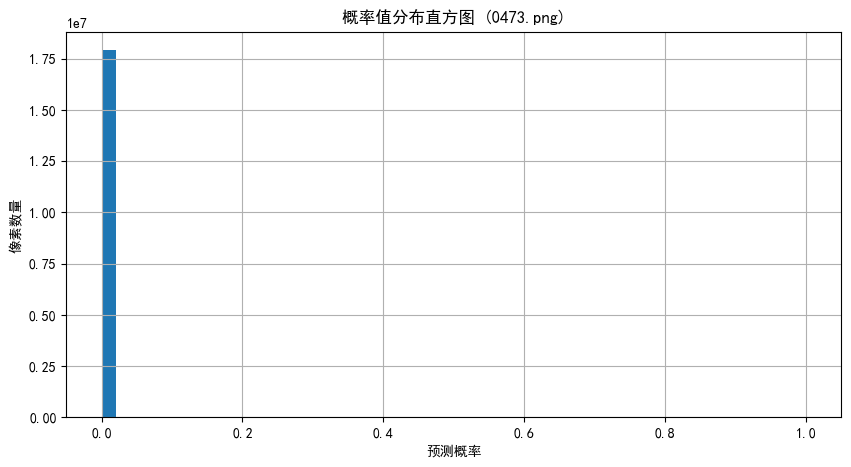

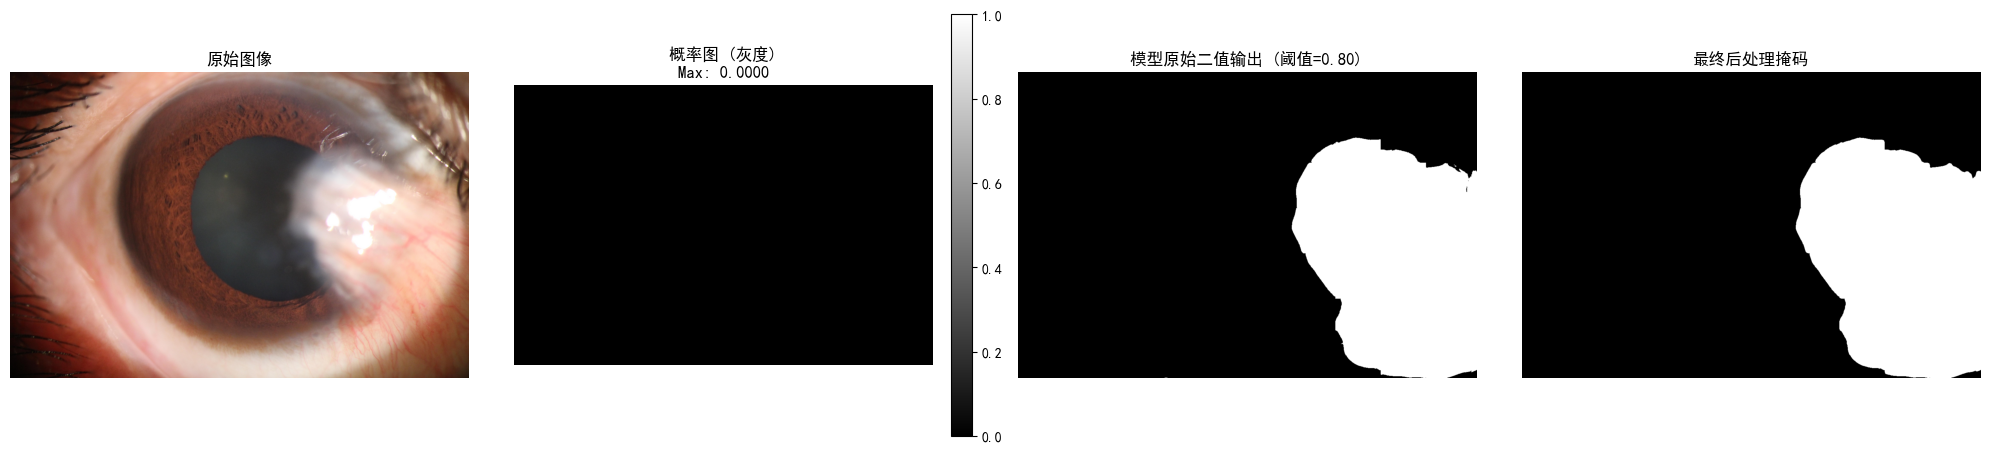

In [42]:
if 'google.colab' in sys.modules or os.path.exists("/kaggle/working"):
    test_single_image_path = '/kaggle/input/pterygium/val_img/val_img/0473.png'
    # 或者根据你的实际情况修改路径
    # test_single_image_path = '/content/trains/train/0001/0001.png' # 示例：使用训练集中的图片
else:
    test_single_image_path = 'f:/val_img/0473.png'

# 确保测试图片存在
if not os.path.exists(test_single_image_path):
    print(f"错误: 测试单张图片未找到: {test_single_image_path}")
    print("请修改 'test_single_image_path' 变量为有效的图片路径。跳过单张图片测试。")
else:
    print(f"\n--- 正在测试单张图片: {os.path.basename(test_single_image_path)} ---")

    # 设置用于单张图片推理的批次大小 (可以比训练批次大)
    # 使用和批量预测相同的推理批次大小
    segmentation_inference_batch_size = int(2.5*(tpu_batch_size if _xla_available else (cuda_batch_size if torch.cuda.is_available() else windows_batch_size))) # 可以根据显存调整

    # --- 运行预测 ---
    final_processed_mask_np, raw_thresholded_mask_np, probability_map_np = process_single_image_for_segmentation(
        model=loaded_model,
        image_path=test_single_image_path,
        patch_size=patch_size,
        stride=predict_stride,
        device=device,
        batch_size=segmentation_inference_batch_size,
        threshold=prediction_threshold,
        debug_mode=DEBUG_MODE
    )

    # --- 分析和可视化 ---
    if probability_map_np is not None:
        print(f"\n--- 分析图像: {os.path.basename(test_single_image_path)} 的预测结果 ---")

        # 1. 打印概率图的统计信息
        print("概率图统计:")
        print(f"  - Min value: {np.min(probability_map_np):.6f}")
        print(f"  - Max value: {np.max(probability_map_np):.6f}")
        print(f"  - Mean value: {np.mean(probability_map_np):.6f}")
        print(f"  - Median value: {np.median(probability_map_np):.6f}")
        print(f"  - Shape: {probability_map_np.shape}")

        # 2. 绘制概率值直方图
        plt.figure(figsize=(10, 5))
        plt.hist(probability_map_np.flatten(), bins=50, range=(0, 1)) # flatten() 将二维数组转为一维
        plt.title(f"概率值分布直方图 ({os.path.basename(test_single_image_path)})")
        plt.xlabel("预测概率")
        plt.ylabel("像素数量")
        plt.grid(True)
        plt.show()

        # 3. 可视化对比
        try:
            original_image = Image.open(test_single_image_path).convert('RGB')
            original_image_np = np.array(original_image)

            # 确保所有 NumPy 数组的尺寸一致 (应该在 process_single_image_for_segmentation 中处理好了)
            # 理论上它们的尺寸应该和 original_image_np.shape[:2] 一致
            # 可以在这里加一个断言或检查
            assert original_image_np.shape[:2] == probability_map_np.shape
            assert original_image_np.shape[:2] == raw_thresholded_mask_np.shape
            assert original_image_np.shape[:2] == final_processed_mask_np.shape


            fig, axes = plt.subplots(1, 4, figsize=(20, 5))

            # 原始图像
            axes[0].imshow(original_image_np)
            axes[0].set_title("原始图像")
            axes[0].axis('off')

            # 概率图 (灰度)
            # 注意: probability_map_np 是 float [0, 1] NumPy 数组
            im = axes[1].imshow(probability_map_np, cmap='gray', vmin=0, vmax=1) # vmin/vmax 确保颜色范围正确
            axes[1].set_title(f"概率图 (灰度)\nMax: {np.max(probability_map_np):.4f}")
            axes[1].axis('off')
            fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04) # 添加颜色条

            # 模型直接输出的二值掩码 (阈值化后，后处理前)
            # raw_thresholded_mask_np 是 uint8 [0, 1] NumPy 数组
            axes[2].imshow(raw_thresholded_mask_np, cmap='gray', vmin=0, vmax=1)
            axes[2].set_title(f"模型原始二值输出 (阈值={prediction_threshold:.2f})")
            axes[2].axis('off')

            # 最终后处理的二值掩码
            # final_processed_mask_np 是 uint8 [0, 1] NumPy 数组
            axes[3].imshow(final_processed_mask_np, cmap='gray', vmin=0, vmax=1)
            axes[3].set_title("最终后处理掩码")
            axes[3].axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"可视化图像时出错: {e}")

    else:
        print(f"未能成功处理图像 {os.path.basename(test_single_image_path)}，返回结果为 None，无法进行分析和可视化。")


--- 正在测试单张图片: 0473.png ---


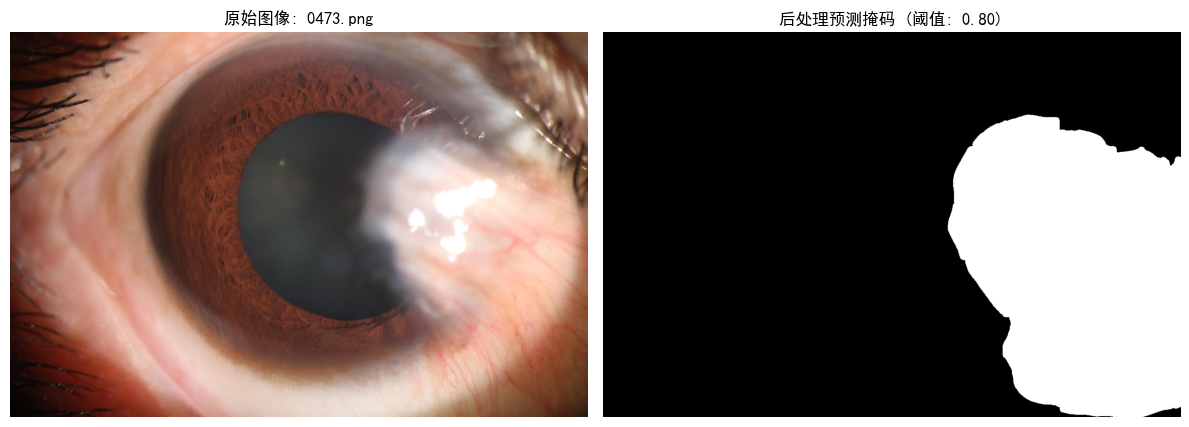

In [43]:
from doctest import debug
from re import DEBUG


test_single_image_path = '/kaggle/input/pterygium/val_img/val_img/0473.png'

# 确保测试图片存在
if not os.path.exists(test_single_image_path):
    print(f"错误: 测试单张图片未找到: {test_single_image_path}")
    print("请修改 'test_single_image_path' 变量为有效的图片路径。")
else:
    print(f"\n--- 正在测试单张图片: {os.path.basename(test_single_image_path)} ---")

    segmentation_batch_size_single = int(2.5*(tpu_batch_size if _xla_available else (cuda_batch_size if torch.cuda.is_available() else windows_batch_size)))
    try:
        processed_mask_np_01, model_output_mask_np_01,prob_map = process_single_image_for_segmentation(
            model=loaded_model, # 分割模型
            image_path=test_single_image_path,
            patch_size=patch_size,
            stride=predict_stride,
            device=device,
            batch_size=segmentation_batch_size_single,
            threshold=prediction_threshold,
            debug_mode=DEBUG_MODE
        )

        # --- 可视化结果 ---
        if processed_mask_np_01 is not None:
            try:
                # 加载原始图像用于显示
                original_image_pil = Image.open(test_single_image_path).convert('RGB')
                original_image_np = np.array(original_image_pil) # HWC, uint8

                # 确保掩码尺寸与原图尺寸一致
                if original_image_np.shape[:2] != processed_mask_np_01.shape:
                     print(f"警告: 分割结果尺寸 {processed_mask_np_01.shape} 与原图尺寸 {original_image_np.shape[:2]} 不匹配，可能存在问题。")
                     # 如果尺寸不匹配，插值到原图尺寸 (可选，但可能不准确)
                     # processed_mask_np_01 = cv2.resize(processed_mask_np_01, (original_image_np.shape[1], original_image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

                # 创建 RGB 格式的可视化掩码 (前景为红色 128,0,0)
                # 注意：这不是保存到文件的格式，只是为了方便 plt.imshow 可视化
                visual_mask_rgb = np.zeros_like(original_image_np)
                visual_mask_rgb[processed_mask_np_01 == 1, 0] = 128 # R通道设为128

                # 将原始图像和掩码叠加显示 (可选，用于更直观展示)
                # overlay_img = original_image_np.copy()
                # overlay_img[processed_mask_np_01 == 1] = visual_mask_rgb[processed_mask_np_01 == 1] # 将红色前景区域叠加到原图

                fig, axes = plt.subplots(1, 2, figsize=(12, 6))

                # 显示原始图像
                axes[0].imshow(original_image_np)
                axes[0].set_title(f"原始图像: {os.path.basename(test_single_image_path)}")
                axes[0].axis('off')

                # 显示后处理的预测掩码 (0/1 数组)
                # 使用 'gray' cmap 可以清晰显示二值掩码
                axes[1].imshow(processed_mask_np_01, cmap='gray', vmin=0, vmax=1) # vmin/vmax确保颜色映射正确
                axes[1].set_title(f"后处理预测掩码 (阈值: {prediction_threshold:.2f})")
                axes[1].axis('off')

                # 如果你想显示模型直接输出的掩码 (无后处理)，可以添加第三个图
                # fig, axes = plt.subplots(1, 3, figsize=(18, 6))
                # axes[2].imshow(model_output_mask_np_01, cmap='gray', vmin=0, vmax=1)
                # axes[2].set_title(f"模型原始输出掩码 (阈值: {prediction_threshold:.2f})")
                # axes[2].axis('off')


                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"可视化预测结果时出错: {e}")
        else:
            print(f"调用 process_single_image_for_segmentation 处理 {os.path.basename(test_single_image_path)} 失败，无法可视化。")
    except Exception as e:
        print(f"处理单张图片 {os.path.basename(test_single_image_path)} 时出错: {e}")
        processed_mask_np_01 = None # 处理失败，设置为 None
        model_output_mask_np_01 = None # 处理失败，设置为 None

### 批量处理

In [44]:
# 调用新的目录处理函数进行预测
predict_masks_for_directory(
    segmentation_model=loaded_model,
    classification_model=classification_model,
    image_dir=val_image_dir,
    output_mask_dir=output_mask_dir,
    output_mask_model_output_dir=output_mask_model_output_dir,
    output_prob_map_dir=output_mask_prob_dir,
    patch_size=patch_size,
    predict_stride=predict_stride,
    device=device,
    segmentation_batch_size=int(2.5*(tpu_batch_size if _xla_available else (cuda_batch_size if torch.cuda.is_available() else windows_batch_size))),
    segmentation_threshold=prediction_threshold,
    classification_transform=val_transform,
    debug_mode=DEBUG_MODE
)

找到 150 张待预测图像于 /kaggle/input/pterygium/val_img/val_img
注意: 调试模式下，分割预测在 1/4 缩放后的图像上进行，结果将放大回原图尺寸。


处理预测图像:   0%|          | 0/150 [00:00<?, ?it/s]


预测处理完成。
总共找到图像: 150
其中 0 张被分类为健康并跳过分割。
对其余 150 张图像进行了成功分割并保存了掩码。
有 0 张图像的分割处理失败。



可视化 10 个预测结果...


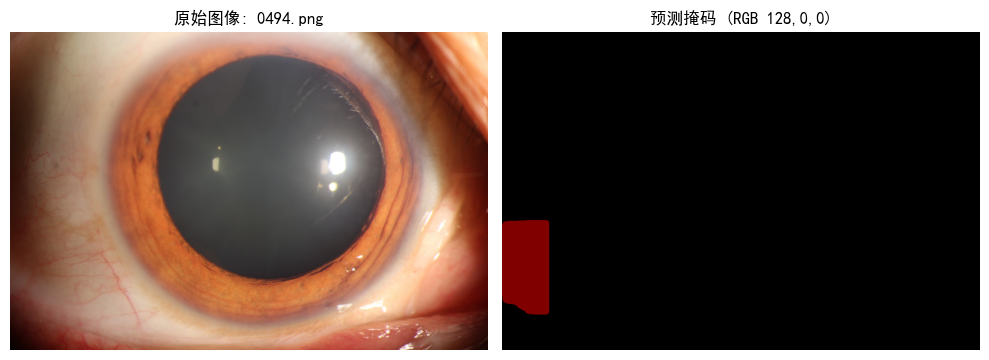

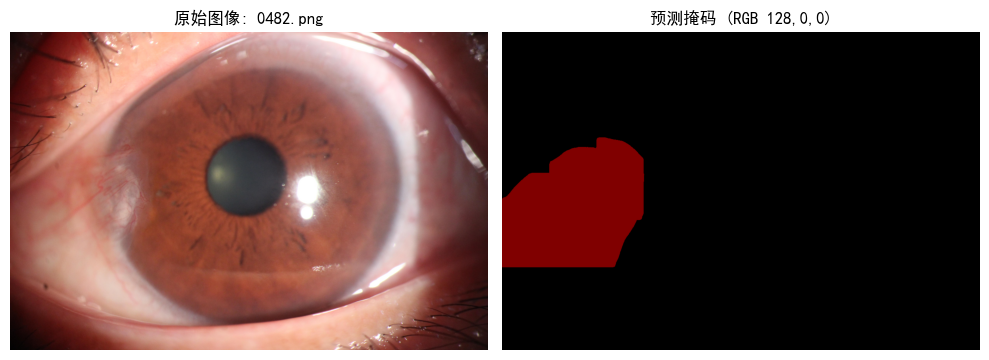

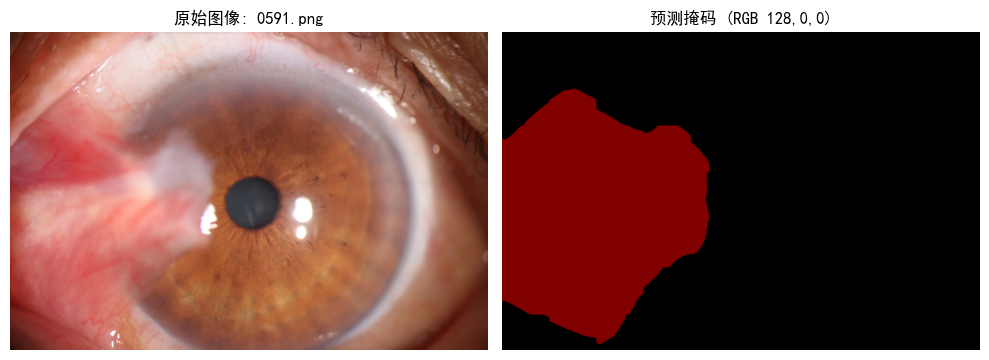

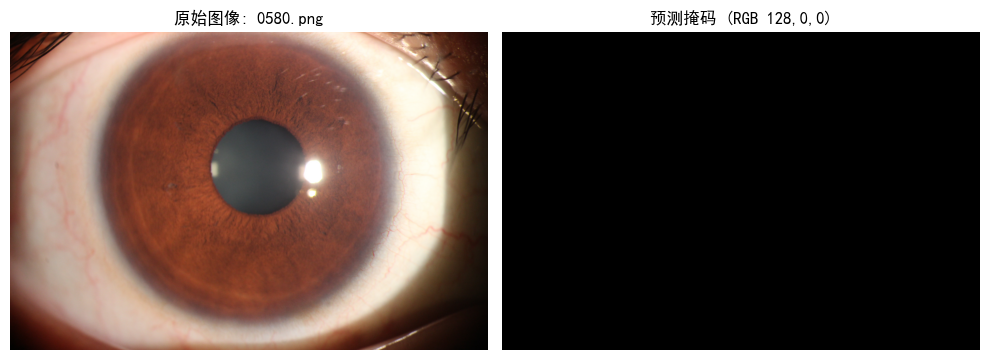

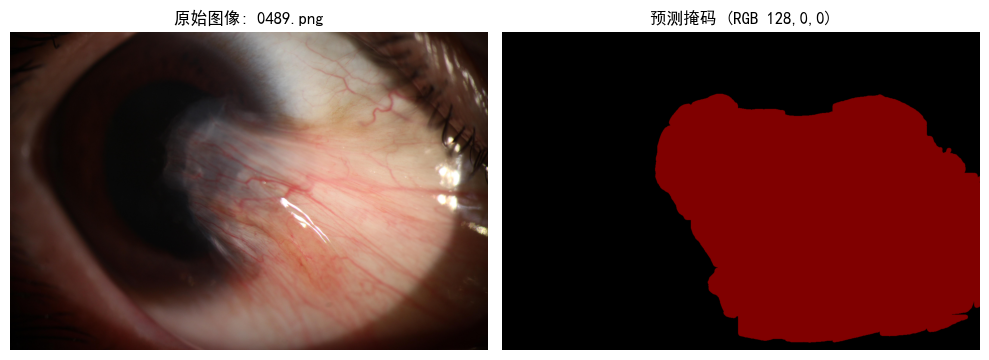

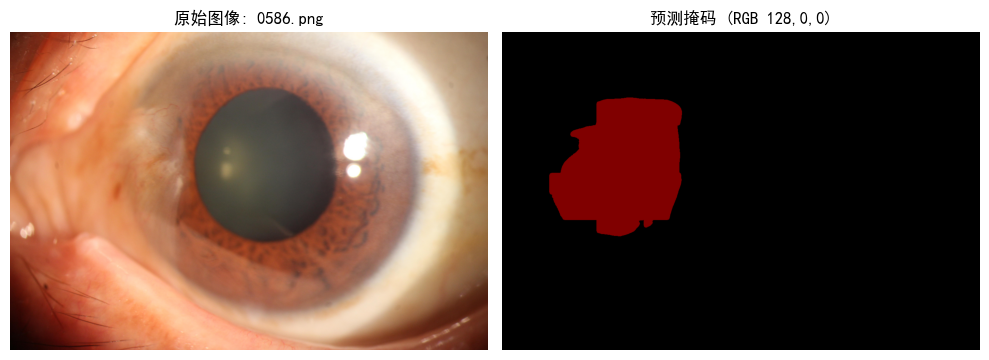

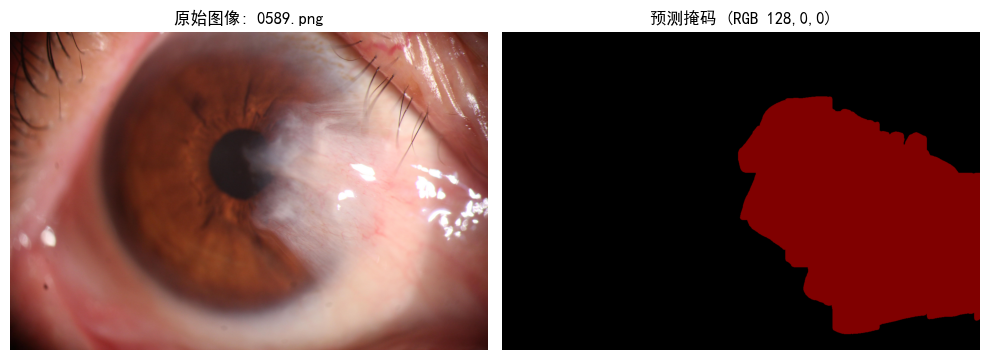

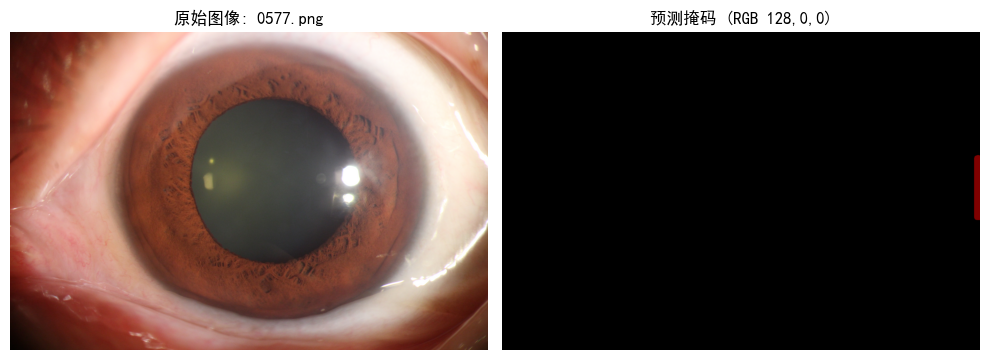

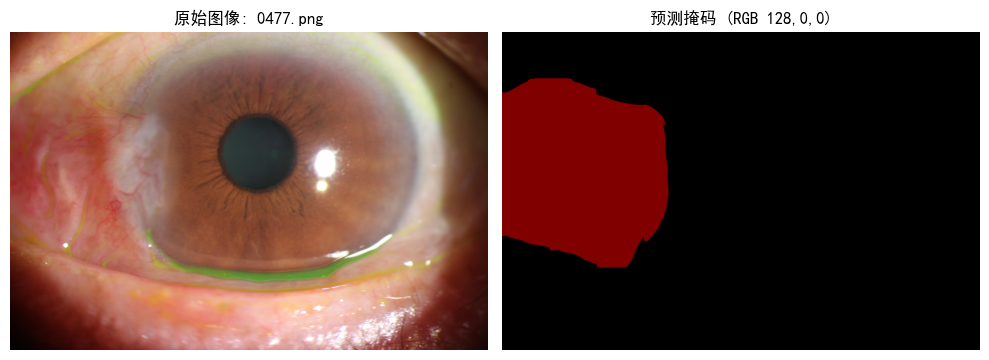

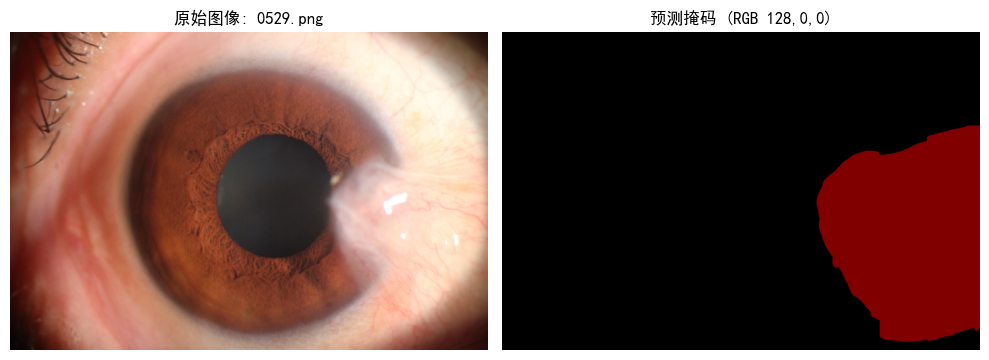

In [45]:
num_visualize = 10

if not val_image_dir or not os.path.isdir(val_image_dir):
    print(f"错误：找不到或无效的测试图像目录 {val_image_dir}，无法进行可视化。")
else:
    # 获取目录下所有 .png 图像文件的完整路径列表
    all_val_image_files = glob.glob(os.path.join(val_image_dir, '*.png')) # 你可以根据需要修改 '*.png'

    if not all_val_image_files:
        print(f"警告: 在目录 {val_image_dir} 中未找到图像文件，无法可视化。")
    else:
        # 确保样本数量不超过实际找到的文件数量
        num_visualize = min(num_visualize, len(all_val_image_files))

        if num_visualize > 0:
            # 从文件路径列表中随机抽样
            sample_paths = random.sample(all_val_image_files, num_visualize)
            print(f"\n可视化 {num_visualize} 个预测结果...")

            for img_path in sample_paths: # 现在 img_path 是一个有效的图像文件路径字符串
                try:
                    # 加载原始图像
                    original_image = Image.open(img_path).convert('RGB')

                    # 构建对应的预测掩码文件的路径
                    base_name = os.path.basename(img_path)
                    file_stem = os.path.splitext(base_name)[0]
                    mask_filename = f"{file_stem}.png" # 假设保存的掩码文件名与原图名相同
                    predicted_mask_path = os.path.join(output_mask_dir, mask_filename)

                    # 检查预测掩码文件是否存在并加载
                    if os.path.exists(predicted_mask_path):
                        predicted_mask_image = Image.open(predicted_mask_path) # 加载之前保存的RGB掩码

                        # 创建绘图
                        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

                        # 显示原始图像
                        axes[0].imshow(original_image)
                        axes[0].set_title(f"原始图像: {base_name}")
                        axes[0].axis('off')

                        # 显示对应的预测掩码
                        axes[1].imshow(predicted_mask_image) # 显示加载的对应掩码
                        axes[1].set_title("预测掩码 (RGB 128,0,0)")
                        axes[1].axis('off')

                        plt.tight_layout() # 调整布局防止重叠
                        plt.show()
                    else:
                        print(f"警告：找不到预测掩码文件 {predicted_mask_path}，无法可视化此样本。")

                except Exception as e:
                    # 这个 except 现在处理的是真正的文件加载或绘图错误
                    print(f"可视化图像 {img_path} 时出错: {e}")
        else:
            print("没有测试图像可供可视化 (num_visualize <= 0 或未找到文件)。")

## 5. 压缩结果

In [46]:
def zip_directory(directory_path):
    zip_file_path = f"{directory_path}.zip"
    if os.path.exists(directory_path) and os.listdir(directory_path):
        print(f"开始压缩目录: {directory_path}")
        try:
            with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
                files_to_zip = glob.glob(os.path.join(directory_path, '*'))
                files_to_zip = [f for f in files_to_zip if os.path.isfile(f)]

                if not files_to_zip:
                    print(f"警告: 目录 {directory_path} 为空或只包含子目录，无需压缩文件。")
                else:
                    # 使用arcname只保留文件名，避免在zip文件中包含完整的原始路径结构
                    for file in tqdm(files_to_zip, desc=f"压缩文件到 {os.path.basename(zip_file_path)}"):
                        zipf.write(file, arcname=os.path.basename(file))
                    print(f"预测结果已成功压缩到: {zip_file_path}")

                    print(f"删除原始掩码文件于: {directory_path}")
                    shutil.rmtree(directory_path)
                    print(f"原始目录 {directory_path} 已被删除。")

        except Exception as e:
            print(f"处理目录 {directory_path} 时发生错误: {e}")
    else:
        print(f"目录 {directory_path} 不存在或为空，跳过压缩和删除步骤。")

In [47]:
if 'google.colab' in sys.modules or os.path.exists("/kaggle/working"):
    print("检测到Colab或Kaggle环境，将进行结果压缩和清理。")
    zip_directory(output_mask_dir)
    zip_directory(output_mask_model_output_dir)
    zip_directory(output_mask_prob_dir)

print("\n预测处理完成。")

检测到Colab或Kaggle环境，将进行结果压缩和清理。
开始压缩目录: /kaggle/working/mask


压缩文件到 mask.zip:   0%|          | 0/150 [00:00<?, ?it/s]

预测结果已成功压缩到: /kaggle/working/mask.zip
删除原始掩码文件于: /kaggle/working/mask
原始目录 /kaggle/working/mask 已被删除。
开始压缩目录: /kaggle/working/mask_original


压缩文件到 mask_original.zip:   0%|          | 0/150 [00:00<?, ?it/s]

预测结果已成功压缩到: /kaggle/working/mask_original.zip
删除原始掩码文件于: /kaggle/working/mask_original
原始目录 /kaggle/working/mask_original 已被删除。
开始压缩目录: /kaggle/working/mask_probability


压缩文件到 mask_probability.zip:   0%|          | 0/150 [00:00<?, ?it/s]

预测结果已成功压缩到: /kaggle/working/mask_probability.zip
删除原始掩码文件于: /kaggle/working/mask_probability
原始目录 /kaggle/working/mask_probability 已被删除。

预测处理完成。


In [48]:
try:
    shutil.rmtree(OUTPUT_PATCH_DIR)
except:
    pass

# 评估模型性能

## SHAP分析
16G显存居然不够跑SHAP

In [49]:
## --- 1. 准备工作 ---
## 确保模型已加载最佳权重并处于评估模式
#if 'loaded_model' not in locals().keys():
#    print("错误：模型未加载。执行模型加载步骤。")
#    loaded_model = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)
#    if os.path.exists(model_save_path):
#        loaded_model.load_state_dict(torch.load(model_save_path, map_location=device, weights_only=True))
#        print(f"从 {model_save_path} 重新加载模型权重。")
#    else:
#        raise FileNotFoundError("无法找到模型权重文件。")
#
#loaded_model.eval()
#
## 确保验证数据集和加载器存在
#if 'val_dataset_offline' not in locals() or val_dataset_offline is None or 'val_loader' not in locals() or val_loader is None:
#    print("错误：验证数据集或加载器未定义。无法执行 SHAP 分析。")
#    raise "错误：验证数据集或加载器未定义。无法执行 SHAP 分析。"
#
#print(f"使用包含 {len(val_dataset_offline)} 个样本的验证集进行 SHAP 分析。")
#
## --- 2. 计算每个验证样本的 Dice 分数 ---
#val_results = [] # 存储 (dice_score, image_tensor, mask_tensor, index)
#print("正在计算验证集中每个样本的 Dice 分数...")
#with torch.no_grad():
#    # 使用原始的 val_loader，但确保 batch_size=1 以便单独处理
#    # 或者创建一个新的 batch_size=1 的 loader
#    temp_val_loader = DataLoader(
#        val_dataset_offline,
#        batch_size=1, # 每次处理一个样本
#        shuffle=False, # 保持顺序
#        num_workers=num_workers,
#        pin_memory=not _xla_available and torch.cuda.is_available()
#    )
#
#    for idx, (image, mask) in enumerate(tqdm(temp_val_loader, desc="Calculating Dice per sample")):
#        image, mask = image.to(device), mask.to(device)
#        output = loaded_model(image)
#        # 确保掩码尺寸匹配
#        mask_downsampled = Fnn.interpolate(mask, size=output.shape[2:], mode='nearest')
#        dice = dice_coefficient(output, mask_downsampled) # 计算单个样本的 Dice
#        # 将数据移回 CPU 存储
#        val_results.append((dice, image.cpu(), mask.cpu(), idx))

In [50]:
## --- 3. 排序并选择样本 ---
#if device.type == 'cuda':
#    torch.cuda.empty_cache()
#val_results.sort(key=lambda x: x[0]) # 按 Dice 分数升序排序
#num_explain = min(1, len(val_results) // 2)
#if num_explain == 0 and len(val_results) > 0:
#    num_explain = 1 # 至少解释一个，如果数据集很小
#if len(val_results) < 2:
#    print("验证集样本太少，无法选择最好和最差的样本进行解释。")
#else:
#    worst_samples = val_results[:num_explain]
#    best_samples = val_results[-num_explain:]
#    print(f"已选择 {num_explain} 个表现最差和 {num_explain} 个表现最好的样本进行解释。")
#
#    # --- 4. 准备 SHAP 背景数据 ---
#    num_background_samples = 32 # 选择少量训练样本作为背景
#    if 'train_dataset_offline' in locals() and len(train_dataset_offline) >= num_background_samples:
#        background_indices = np.random.choice(len(train_dataset_offline), num_background_samples, replace=False)
#        # 只取图像部分，并确保在正确的设备上
#        background_data = torch.stack([train_dataset_offline[i][0] for i in background_indices]).to(device)
#        print(f"使用 {num_background_samples} 个训练样本作为 SHAP 背景数据。")
#    
#        # --- 5. 创建 SHAP 解释器 ---
#        class SegmentationModelWrapperForSHAP(nn.Module):
#            def __init__(self, model):
#                super().__init__()
#                self.model = model
#
#            def forward(self, x):
#                logits = self.model(x) # (N, 1, H, W)
#                # 对空间和通道维度求和
#                scalar_output_per_sample = torch.sum(logits, dim=(1, 2, 3)) # Shape: (N,)
#                return scalar_output_per_sample.unsqueeze(1) # Returns shape: (N, 1)
#
#        # 确保原始模型在评估模式和正确设备上
#        loaded_model.eval()
#        loaded_model.to(device)
#
#        # 创建包装后的模型实例，并移到设备
#        shap_compatible_model = SegmentationModelWrapperForSHAP(loaded_model).to(device)
#        shap_compatible_model.eval()
#
#        print("创建 SHAP 解释器...")
#        explainer = shap.GradientExplainer(shap_compatible_model, background_data)
#    
#        # --- 6. 解释表现最差的样本 ---
#        print("\n--- 解释表现最差的样本 ---")
#        worst_images_tensor = torch.cat([s[1] for s in worst_samples], dim=0).to(device)
#        worst_masks_tensor = torch.cat([s[2] for s in worst_samples], dim=0) # CPU
#        worst_dices = [s[0] for s in worst_samples]
#        print(f"计算 {len(worst_samples)} 个最差样本的 SHAP 值...")
#        # shap_values 的形状: (N, C, H, W)，其中 C=1 (模型输出通道)
#        shap_values_worst = explainer.shap_values(worst_images_tensor)
#        print("SHAP 值计算完成。")
#        # 准备可视化数据
#        # 反归一化图像
#        images_np_worst = []
#        mean = np.array([0.485, 0.456, 0.406])
#        std = np.array([0.229, 0.224, 0.225])
#        for img_tensor in worst_images_tensor.cpu():
#            img_np = img_tensor.numpy().transpose(1, 2, 0) # CHW -> HWC
#            img_np = std * img_np + mean
#            img_np = np.clip(img_np, 0, 1)
#            images_np_worst.append(img_np)
#        images_np_worst = np.array(images_np_worst)
#        # 准备 SHAP 值和标签用于绘图
#        # shap_values_worst 是 (N, 1, H, W)
#        # image_plot 需要 (N, H, W, C) 或 (N, C, H, W)
#        # 我们将 SHAP 值视为单通道 "图像"
#        shap_values_plot_worst = shap_values_worst.transpose(0, 2, 3, 1) # N, H, W, 1
#        # 创建标签，包含 Dice 分数
#        labels_worst = np.array([[f"Dice: {d:.3f}"] for d in worst_dices])
#        print("生成最差样本的 SHAP 图像...")
#        # 由于 shap.image_plot 对多输出的处理方式，我们直接传入 shap_values_worst
#        # 它会将这个单通道解释绘制出来
#        shap.image_plot(shap_values_worst,
#                        worst_images_tensor.cpu(), # 显示原始（归一化后）图像可能更清晰
#                        # images_np_worst, # 或者显示反归一化图像
#                        labels=labels_worst,
#                        show=True)
#        # --- 7. 解释表现最好的样本 ---
#        print("\n--- 解释表现最好的样本 ---")
#        best_images_tensor = torch.cat([s[1] for s in best_samples], dim=0).to(device)
#        best_masks_tensor = torch.cat([s[2] for s in best_samples], dim=0) # CPU
#        best_dices = [s[0] for s in best_samples]
#        print(f"计算 {len(best_samples)} 个最好样本的 SHAP 值...")
#        shap_values_best = explainer.shap_values(best_images_tensor)
#        print("SHAP 值计算完成。")
#        # 准备可视化数据
#        images_np_best = []
#        for img_tensor in best_images_tensor.cpu():
#            img_np = img_tensor.numpy().transpose(1, 2, 0) # CHW -> HWC
#            img_np = std * img_np + mean
#            img_np = np.clip(img_np, 0, 1)
#            images_np_best.append(img_np)
#        images_np_best = np.array(images_np_best)
#        shap_values_plot_best = shap_values_best.transpose(0, 2, 3, 1) # N, H, W, 1
#        labels_best = np.array([[f"Dice: {d:.3f}"] for d in best_dices])
#        print("生成最好样本的 SHAP 图像...")
#        shap.image_plot(shap_values_best,
#                        best_images_tensor.cpu(),
#                        # images_np_best,
#                        labels=labels_best,
#                        show=True)
#        
#        # 清理 GPU 内存
#        del worst_images_tensor, shap_values_worst, best_images_tensor, shap_values_best, background_data, explainer
#        if device.type == 'cuda':
#            torch.cuda.empty_cache()
#    elif 'train_dataset_offline' not in locals():
#        print("错误：找不到训练数据集 'train_dataset_offline'，无法选择 SHAP 背景数据。")
#    else:
#        print(f"错误：训练数据集样本数量 ({len(train_dataset_offline)}) 不足 {num_background_samples} 个，无法选择 SHAP 背景数据。")

## 以测试集为例进行模型评估

In [51]:
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import find_boundaries
import numpy as np
import random
def calculate_dice_np(mask_pred, mask_true, smooth=1e-6):
    """
    计算两个 0/1 NumPy 掩码之间的 Dice 系数。

    Args:
        mask_pred (numpy.ndarray): 预测掩码 (0 或 1)。
        mask_true (numpy.ndarray): 真实掩码 (0 或 1)。
        smooth (float): 平滑项，用于防止除以零。

    Returns:
        float: Dice 系数。
    """
    # 确保是二值数组
    mask_pred = mask_pred.astype(bool)
    mask_true = mask_true.astype(bool)

    intersection = np.sum(mask_pred & mask_true)
    sum_masks = np.sum(mask_pred) + np.sum(mask_true)

    if sum_masks == 0:
        # 如果两个掩码都完全是背景，Dice 通常被认为是 1 (完美匹配)
        return 1.0
    else:
        return (2. * intersection + smooth) / (sum_masks + smooth)

def calculate_hd95_np(mask_pred, mask_true, voxel_spacing=(1, 1)):
    """
    计算两个 0/1 NumPy 掩码之间的 95% Hausdorff 距离。
    (基于 scipy.ndimage.distance_transform_edt)

    Args:
        mask_pred (numpy.ndarray): 预测掩码 (0 或 1)。
        mask_true (numpy.ndarray): 真实掩码 (0 或 1)。
        voxel_spacing (tuple): 图像的体素间距 (高, 宽)。默认为 (1, 1)。

    Returns:
        float: 95% Hausdorff 距离。如果任一掩码为空但另一个不为空，返回一个大数值 (表示无限距离)。
               如果两个掩码都为空，返回 0。如果两个掩码完全相同，返回 0。
    """
    # 确保是二值布尔数组
    mask_pred = mask_pred.astype(bool)
    mask_true = mask_true.astype(bool)

    # 处理全背景或全前景的特殊情况
    if np.all(~mask_true) and np.all(~mask_pred): # 两个都空
        return 0.0
    if np.all(mask_true) and np.all(mask_pred): # 两个都满 (理论上分割不会预测全满)
         return 0.0

    # 如果一个为空但另一个不为空
    if np.all(~mask_true) and np.any(mask_pred):
        return float('inf') # 或者一个很大的数，如 10000
    if np.any(mask_true) and np.all(~mask_pred):
        return float('inf') # 或者一个很大的数

    # 计算距离变换 (距离从非零像素到最近的零像素)
    # 为了计算边界间的距离，我们需要距离变换是从零像素到非零像素
    # dist_true: 距离真实前景的距离 (前景内部为0，背景为正)
    # dist_pred: 距离预测前景的距离 (前景内部为0，背景为正)
    dist_true = distance_transform_edt(~mask_true, sampling=voxel_spacing)
    dist_pred = distance_transform_edt(~mask_pred, sampling=voxel_spacing)

    # 找到边界像素
    # level=0.5 在 0/1 之间寻找边界
    boundary_true = find_boundaries(mask_true, mode='inner', connectivity=1)
    boundary_pred = find_boundaries(mask_pred, mode='inner', connectivity=1)

    # 计算从预测边界到真实边界的距离 (使用真实距离图在预测边界处的值)
    # dist_true[boundary_pred]: 预测边界点到最近的真实前景像素的距离
    distances_pred_to_true = dist_true[boundary_pred]

    # 计算从真实边界到预测边界的距离 (使用预测距离图在真实边界处的值)
    distances_true_to_pred = dist_pred[boundary_true]

    # 计算 95th 百分位数
    # 需要处理边界是空的情况，虽然前面已经排除了掩码全空的情况
    # 但有可能一个掩码非空，但边界是空的 (例如 1x1 的掩码)
    hd1 = np.percentile(distances_pred_to_true, 95) if distances_pred_to_true.size > 0 else float('inf')
    hd2 = np.percentile(distances_true_to_pred, 95) if distances_true_to_pred.size > 0 else float('inf')

    # Hausdorff 距离是两个有向距离的最大值
    hausdorff_distance = max(hd1, hd2)

    # 如果计算结果是无穷大，可能是因为某个边界是空的（虽然掩码本身非空）
    # 在实际图像分割中，这种情况很少见，除非 patch 太小或形态学处理异常
    # 如果 mask_pred 和 mask_true shape 相同且非空，通常不会出现 inf
    if np.isinf(hausdorff_distance):
        print("警告: 计算 HD95 得到 Inf，可能因为边界为空。")
        # 可以选择返回一个预设的大值，而不是 inf
        return 10000.0 # 返回一个较大的有限值

    return hausdorff_distance

def evaluate_full_images_random_subset(
    segmentation_model,
    original_train_image_dir, # 指向训练集原始大图的根目录 (如 /kaggle/input/pterygium/train/train)
    val_original_ids,         # 在数据加载时被划分为验证集的原始图像 ID 列表 (如 ['0473', '0512', ...])
    patch_size,
    predict_stride,
    device,
    segmentation_batch_size,
    segmentation_threshold,
    num_evaluation_samples=10,
    debug_mode=False
):
    """
    在随机选择的验证集原始图像子集上评估分割模型的性能 (Dice 和 HD95)。

    Args:
        segmentation_model (nn.Module): 训练好的分割模型。
        original_train_image_dir (str): 包含原始训练图像子文件夹 (如 0001, 0002...) 的目录。
        val_original_ids (list): 在数据加载时被用于验证集的原始图像 ID 列表。
        patch_size (int): 分割模型 Patch 大小 (边长)。
        predict_stride (int): 切割 Patch 时的步长 (预测步长)。
        device (torch.device): 计算设备 ('cuda' or 'cpu')。
        segmentation_batch_size (int): 分割模型推理时的批次大小。
        segmentation_threshold (float): 分割结果的二值化阈值。
        num_evaluation_samples (int): 用于评估的随机样本数量。
        debug_mode (bool): 是否启用调试模式 (影响 process_single_image_for_segmentation)。

    Returns:
        tuple: (平均Dice系数, 平均HD95)
    """
    print(f"\n--- 开始在随机 {num_evaluation_samples} 个验证集原始图像上评估 ---")
    if not val_original_ids:
        print("错误: 验证集原始图像 ID 列表为空。无法进行评估。")
        return 0.0, float('inf')

    # 随机选择评估样本的原始图像 ID
    num_evaluation_samples = min(num_evaluation_samples, len(val_original_ids))
    if num_evaluation_samples == 0:
         print("警告: 没有足够的验证集原始图像进行评估。")
         return 0.0, float('inf')

    sampled_ids = random.sample(val_original_ids, num_evaluation_samples)
    print(f"已选择以下 {len(sampled_ids)} 个原始图像 ID 进行评估: {sampled_ids}")

    dice_scores = []
    hd95_scores = []
    processed_count = 0

    # 确保模型在评估模式
    segmentation_model.eval()

    # 遍历选定的 ID 进行评估
    for img_id in tqdm(sampled_ids, desc="评估原始图像"):
        img_folder_path = os.path.join(original_train_image_dir, img_id)
        image_path = os.path.join(img_folder_path, f"{img_id}.png")
        mask_path_gt = os.path.join(img_folder_path, f"{img_id}_label.png") # 真实掩码路径

        if not os.path.exists(image_path) or not os.path.exists(mask_path_gt):
            print(f"警告: 评估图像或真实掩码文件未找到 {img_id}，跳过。")
            continue

        try:
            # --- 获取预测掩码 (0/1 NumPy array, 已是原始尺寸) ---
            # 注意: 这里我们不使用分类模型，直接对所有选中的图像进行分割，
            #       因为我们选择的是 val_ids 中的有病样本，它们理论上都有翼状胬肉。
            #       如果 val_ids 可能包含健康样本，则需要在这里集成分类过滤。
            #       根据之前的逻辑，val_ids 是从所有独特原始 ID 中划分的，可能包含健康ID。
            #       为了准确评估分割模型本身在有病样本上的表现，最好只评估有病样本。
            #       但是，如果目的是评估整个级联流程，则应该包含健康样本并期望空掩码。
            #       这里我们假设评估分割模型本身，所以选择的是 val_ids 中有 pterygium > 0 的 ID。
            #       根据之前的 train/val split 逻辑，val_ids 来自所有唯一 ID，其中包含健康和病灶。
            #       为了简化和符合“对应的mask”评估，我们直接使用 process_single_image_for_segmentation
            #       如果它返回空掩码（对于健康样本），Dice 和 HD95 计算函数会处理。

            processed_mask_np, _ , _ = process_single_image_for_segmentation(
                model=segmentation_model,
                image_path=image_path,
                patch_size=patch_size,
                stride=predict_stride,
                device=device,
                batch_size=segmentation_batch_size,
                threshold=segmentation_threshold,
                debug_mode=debug_mode
            )

            if processed_mask_np is None:
                 print(f"警告: 对图像 {img_id} 进行分割预测失败，跳过评估。")
                 continue # 预测失败，无法评估

            # --- 加载真实掩码 (0/1 NumPy array) ---
            # 注意: load_and_preprocess_image_mask 返回的是 Tensor，且会应用 debug_mode 缩放
            # 我们需要加载原始尺寸的 NumPy 掩码作为 Ground Truth
            gt_mask_pil = Image.open(mask_path_gt).convert('RGB')
            gt_mask_np_rgb = np.array(gt_mask_pil)
            gt_mask_np = (gt_mask_np_rgb[:, :, 0] == 128).astype(np.uint8) # 0/1 uint8

            # 确保预测和真实掩码尺寸匹配
            if processed_mask_np.shape != gt_mask_np.shape:
                print(f"警告: 图像 {img_id} 的预测掩码尺寸 {processed_mask_np.shape} 与真实掩码尺寸 {gt_mask_np.shape} 不匹配，跳过。")
                continue # 尺寸不匹配，跳过评估

            # --- 计算指标 ---
            dice = calculate_dice_np(processed_mask_np, gt_mask_np)
            hd95 = calculate_hd95_np(processed_mask_np, gt_mask_np)

            dice_scores.append(dice)
            hd95_scores.append(hd95)
            processed_count += 1

            # 可选: 打印单个样本分数
            # print(f"样本 {img_id}: Dice={dice:.4f}, HD95={hd95:.2f}")

        except Exception as e:
            print(f"评估图像 {img_id} 时出错: {e}，跳过。")
            # 尝试清理显存
            if device.type == 'cuda': torch.cuda.empty_cache()


    # --- 计算平均分数 ---
    avg_dice = np.mean(dice_scores) if dice_scores else 0.0
    avg_hd95 = np.mean(hd95_scores) if hd95_scores else float('inf') # 如果没有计算到HD95，平均值设为无穷大

    print("\n--- 评估结果 ---")
    print(f"在 {processed_count} 个样本上计算得到:")
    print(f"平均 Dice 系数: {avg_dice:.4f}")
    if np.isinf(avg_hd95):
         print("平均 HD95: Infinity (可能因为某些样本处理失败或没有有效边界)")
    else:
        print(f"平均 HD95: {avg_hd95:.2f}")
    print("----------------")

    return avg_dice, avg_hd95

if 'loaded_model' not in locals().keys():
    print("错误: 模型未加载。请先运行模型加载单元格。")
elif 'val_ids' not in locals().keys() or not val_ids:
    print("错误: 验证集原始图像 ID 列表 (val_ids) 不存在或为空。请先成功运行数据加载单元格。")
else:
    try:
            labels_df = pd.read_excel(label_file)
            # 筛选出翼状胬肉样本 (标签 > 0) 的原始图像 ID
            pterygium_df = labels_df[labels_df['Pterygium'] > 0].reset_index(drop=True)
            pterygium_original_ids = pterygium_df['Image'].astype(int).apply(lambda x: f"{x:04d}").tolist()
            # 找到同时在验证集划分中且有翼状胬肉的图像 ID
            val_pterygium_ids = [img_id for img_id in val_ids if img_id in pterygium_original_ids]
    except Exception as e:
        print(f'筛选翼状胬肉样本时出错，{e}。使用原始ID继续评估。')
        val_pterygium_ids = val_ids

    avg_dice_eval, avg_hd95_eval = evaluate_full_images_random_subset(
        segmentation_model=loaded_model,
        original_train_image_dir=INPUT_IMAGE_DIR,
        val_original_ids=val_pterygium_ids,
        patch_size=patch_size,
        predict_stride=predict_stride,
        device=device,
        segmentation_batch_size=segmentation_inference_batch_size,
        segmentation_threshold=prediction_threshold,
        num_evaluation_samples=min(100, len(val_pterygium_ids)),
        debug_mode=DEBUG_MODE
    )


--- 开始在随机 57 个验证集原始图像上评估 ---
已选择以下 57 个原始图像 ID 进行评估: ['0209', '0025', '0116', '0351', '0290', '0049', '0435', '0266', '0427', '0038', '0188', '0370', '0439', '0160', '0275', '0440', '0155', '0363', '0042', '0291', '0058', '0429', '0139', '0098', '0379', '0147', '0117', '0442', '0074', '0134', '0202', '0283', '0245', '0393', '0001', '0430', '0153', '0057', '0140', '0319', '0166', '0190', '0428', '0136', '0327', '0299', '0013', '0301', '0097', '0093', '0312', '0143', '0438', '0091', '0373', '0007', '0320']


评估原始图像:   0%|          | 0/57 [00:00<?, ?it/s]


--- 评估结果 ---
在 57 个样本上计算得到:
平均 Dice 系数: 0.8861
平均 HD95: 301.99
----------------
